In queste due celle, come prima cosa resetto il Runtime nel caso non andasse qualcosa e installo le dipendenze per far andare Raft, con anche i modelli per addestrati per fare le valutazioni.

In [1]:
# Reset pulito (opzionale)
!rm -rf /content/RAFT /content/oflow2d /content/outputs

# Dipendenze base (torch è già in Colab)
!pip -q install opencv-python tqdm matplotlib


In [2]:
!git clone https://github.com/princeton-vl/RAFT /content/RAFT
%cd /content/RAFT
!bash download_models.sh
%cd /content

# Verifica file essenziali
import os
for p in [
    "/content/RAFT/models/raft-small.pth",
    "/content/RAFT/models/raft-sintel.pth",
    "/content/RAFT/core/raft.py",
    "/content/RAFT/core/utils/utils.py",
]:
    print(("✓" if os.path.exists(p) else "✗"), p)


Cloning into '/content/RAFT'...
remote: Enumerating objects: 155, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 155 (delta 1), reused 0 (delta 0), pack-reused 148 (from 3)
Receiving objects: 100% (155/155), 10.02 MiB | 14.52 MiB/s, done.
Resolving deltas: 100% (58/58), done.
/content/RAFT
--2025-11-12 14:27:56--  https://dl.dropboxusercontent.com/s/4j4z58wuv8o0mfz/models.zip
Resolving dl.dropboxusercontent.com (dl.dropboxusercontent.com)... 162.125.2.15, 2620:100:6021:15::a27d:410f
Connecting to dl.dropboxusercontent.com (dl.dropboxusercontent.com)|162.125.2.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 81977417 (78M) [application/zip]
Saving to: ‘models.zip’

models.zip          100%[===================>]  78.18M  90.1MB/s    in 0.9s    

2025-11-12 14:27:58 (90.1 MB/s) - ‘models.zip’ saved [81977417/81977417]

Archive:  models.zip
   creating: models/
  inflating: models/raft-kitti.pth   


__init__.py

__all__=['common','adapters']: rende esplicito cosa esporta il pacchetto. Serve per import puliti del tipo from oflow2d.adapters import make_model

common/utils.py
load_video_frames(video_path, max_frames=None, stride=1)

Perché: ottenere una sequenza di frame RGB uint8 pronta per i modelli.

Cosa fa: apre il video con OpenCV (BGR) → converte in RGB → sottocampiona con stride → tronca a max_frames → verifica che ci siano ≥2 frame.

Uso tipico: caricamento veloce per demo single-video o per preparare coppie consecutive.

pairwise(frames)

Perché: quasi tutti i modelli di OF lavorano su coppie (t,t+1).

Cosa fa: genera (frames[i], frames[i+1]) in streaming.


common/viz.py
flow_to_color(flow, clip_flow=None)

Perché: visualizzare il flow in modo standard (hue = direzione, value = modulo).

Cosa fa: da flow (H,W,2) calcola angolo e magnitudine, mappa in HSV, converte in RGB uint8. clip_flow limita la magnitudine per evitare saturazioni.

Nota: è la classica “color wheel” (facile da confrontare con altri lavori)



common/metrics.py

Metriche quantitative rispetto alla GT.

epe(pred, gt, valid_mask=None)

Perché: metrica canonica (media distanza punto-finale).

Cosa fa: mean( sqrt( (u−u*)² + (v−v*)² ) ) con maschera valid opzionale.

fl_all(pred, gt, tau=3.0, valid_mask=None)

Perché: metrica richiesta da KITTI (outlier rate).

Cosa fa: percentuale di pixel con EPE > tau.

Nota importante: la definizione ufficiale KITTI usa doppia soglia: outlier se (EPE > 3px) AND (EPE/|gt| > 0.05)



adapters/__init__.py
make_model(name: str, **kwargs)

Perché: factory unificata per istanziare modelli con la stessa API (qui parte da RAFT, ma si estende a SPyNet/FlowNet2/PWCNet).

Cosa fa: normalizza name e ritorna l’adapter richiesto. Se il nome non è supportato → ValueError.


adapters/raft.py

Adapter “sottile” che incapsula RAFT originale e restituisce sempre flow (H,W,2) float32 in pixel/frame.

Scelte progettuali (e motivazioni)

RAFT_ROOT: legge la variabile d’ambiente (default /content/RAFT) per trovare il codice ufficiale. Evita hard-coding nelle import e rende l’ambiente portabile.

sys.path injection: aggiunge RAFT/core e RAFT al PYTHONPATH se mancano (Colab spesso non ha install).

_DotArgs: finge gli argomenti di argparse attesi da RAFT (small, mixed_precision, alternate_corr) senza parsare la CLI.

Caricamento pesi robusto: gestisce checkpoint con/ senza chiave state_dict e rimuove il prefisso module. (tipico di training con DataParallel).

strict=False: tollera piccole discrepanze dei nomi dei layer tra versioni; stampa cosa manca/è in più.

device auto: usa cuda se disponibile, altrimenti cpu.

Padding/Unpadding (InputPadder): RAFT richiede dimensioni multiple del “coarse stride”; pad/unpad evita artefatti sui bordi.

__call__(im0, im1, iters=8):

converte RGB uint8 → torch float [0,1] (CHW, batch=1)

pad → inferenza (test_mode=True) → unpad

ritorna flow H×W×2 float32

mixed_precision=True (default): abilita autocast FP16 su GPU → maggiore FPS con minima perdita di accuratezza.

small=True: usa RAFT-small per restare leggero su GPU/Colab; puoi aumentare iters per più accuratezza.

In [3]:

import os, pathlib, textwrap
base = pathlib.Path("/content/oflow2d")
(base/"common").mkdir(parents=True, exist_ok=True)
(base/"adapters").mkdir(parents=True, exist_ok=True)

# __init__.py
(base/"__init__.py").write_text("__all__=['common','adapters']\n")

# common/utils.py
(base/"common"/"utils.py").write_text(textwrap.dedent("""
import cv2, numpy as np

def load_video_frames(video_path, max_frames=None, stride=1):
    cap = cv2.VideoCapture(str(video_path))
    assert cap.isOpened(), f'Impossibile aprire {video_path}'
    frames, i = [], 0
    while True:
        ok, frame = cap.read()
        if not ok: break
        if i % stride == 0:
            frames.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            if max_frames and len(frames) >= max_frames: break
        i += 1
    cap.release()
    if len(frames) < 2: raise RuntimeError("Servono almeno 2 frame nel video.")
    return frames

def pairwise(frames):
    for i in range(len(frames)-1):
        yield frames[i], frames[i+1]
"""))

# common/viz.py
(base/"common"/"viz.py").write_text(textwrap.dedent("""
import numpy as np, cv2
def flow_to_color(flow, clip_flow=None):
    fx = flow[...,0]; fy = flow[...,1]
    rad = (fx**2 + fy**2) ** 0.5
    ang = np.arctan2(fy, fx)
    if clip_flow is not None: rad = np.clip(rad, 0, clip_flow)
    rad_n = (rad - rad.min()) / (rad.max() - rad.min() + 1e-8)
    ang_n = (ang + np.pi) / (2*np.pi)
    hsv = np.zeros((*flow.shape[:2],3), dtype=np.float32)
    hsv[...,0] = ang_n * 179.0; hsv[...,1] = 1.0; hsv[...,2] = rad_n
    bgr = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    return (bgr[:,:,::-1]*255.0).astype('uint8')
"""))

# common/metrics.py (se userai GT)
(base/"common"/"metrics.py").write_text(textwrap.dedent("""
import numpy as np
def epe(pred, gt, valid_mask=None):
    diff = pred - gt
    dist = np.sqrt((diff**2).sum(axis=-1))
    if valid_mask is not None: dist = dist[valid_mask>0]
    return float(dist.mean()) if dist.size>0 else float('nan')

def fl_all(pred, gt, tau=3.0, valid_mask=None):
    diff = pred - gt
    dist = np.sqrt((diff**2).sum(axis=-1))
    if valid_mask is not None: dist = dist[valid_mask>0]
    if dist.size==0: return float('nan')
    return float((dist>tau).mean()*100.0)

def angular_error(pred, gt, eps=1e-6, valid_mask=None):
    px,py = pred[...,0], pred[...,1]
    gx,gy = gt[...,0], gt[...,1]
    pnorm = np.sqrt(px*px+py*py)+eps
    gnorm = np.sqrt(gx*gx+gy*gy)+eps
    dot = (px*gx+py*gy)/(pnorm*gnorm)
    dot = np.clip(dot,-1,1)
    ang = np.degrees(np.arccos(dot))
    if valid_mask is not None: ang = ang[valid_mask>0]
    return float(ang.mean()) if ang.size>0 else float('nan')
"""))

# adapters/__init__.py
(base/"adapters"/"__init__.py").write_text(textwrap.dedent("""
def make_model(name:str, **kwargs):
    name = name.lower()
    if name == 'raft':
        from .raft import RAFTAdapter
        return RAFTAdapter(**kwargs)
    raise ValueError(f"Modello '{name}' non supportato. Usa 'raft'.")
"""))

# adapters/raft.py — robusto: RAFT-small+FP16, niente alt_cuda_corr, pesi con/ senza 'module.'
(base/"adapters"/"raft.py").write_text(textwrap.dedent("""
import os, sys, torch, numpy as np

class _DotArgs(dict):
    __getattr__ = dict.get
    def __setattr__(self, k, v): self[k] = v
    def __contains__(self, k): return dict.__contains__(self, k)

class RAFTAdapter:
    def __init__(self, weights:str, device:str=None,
                 small:bool=True, mixed_precision:bool=True, alternate_corr:bool=False):
        raft_root = os.environ.get("RAFT_ROOT", "/content/RAFT")
        core_path = os.path.join(raft_root, "core")
        for p in (core_path, raft_root):
            if p not in sys.path: sys.path.insert(0, p)

        try:
            from core.raft import RAFT as RAFTCore
            from core.utils.utils import InputPadder
        except Exception as e:
            raise ImportError("RAFT non trovato. Aggiungi /content/RAFT e /content/RAFT/core a sys.path.") from e

        self.device = torch.device(device) if device else torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.args = _DotArgs(small=small, mixed_precision=mixed_precision, alternate_corr=alternate_corr)
        self.net = RAFTCore(self.args)

        state = torch.load(weights, map_location='cpu')
        if isinstance(state, dict) and 'state_dict' in state and isinstance(state['state_dict'], dict):
            state = state['state_dict']
        if isinstance(state, dict):
            state = { (k.split('module.',1)[-1]): v for k,v in state.items() }

        missing, unexpected = self.net.load_state_dict(state, strict=False)
        if missing:    print("[RAFTAdapter] missing:", len(missing))
        if unexpected: print("[RAFTAdapter] unexpected:", len(unexpected))

        self.net.to(self.device).eval()

    @torch.no_grad()
    def __call__(self, im0, im1, iters:int=8):
        from core.utils.utils import InputPadder
        t0 = torch.from_numpy(im0.transpose(2,0,1)).float().unsqueeze(0)/255.0
        t1 = torch.from_numpy(im1.transpose(2,0,1)).float().unsqueeze(0)/255.0
        t0 = t0.to(self.device); t1 = t1.to(self.device)
        padder = InputPadder(t0.shape)
        t0p, t1p = padder.pad(t0, t1)
        _, flow_up = self.net(t0p, t1p, iters=iters, test_mode=True)
        flow = padder.unpad(flow_up)[0].permute(1,2,0).detach().cpu().numpy().astype('float32')
        return flow
"""))

print("Framework creato in /content/oflow2d ✓")


Framework creato in /content/oflow2d ✓


sys.path – rendere visibile il codice RAFT

Perché: in Colab il codice non è “installato” come pacchetto. Aggiungiamo le cartelle al PYTHONPATH così i moduli si possono importare con import core.raft, ecc.

Cosa abilita:

/content/oflow2d → il tuo mini-framework (adapters/common).

/content/RAFT e /content/RAFT/core → la repo ufficiale di RAFT clonata su disco.

Senza questo: ModuleNotFoundError: No module named 'core.raft'.


In [4]:
import sys, os
for p in ["/content/oflow2d", "/content/RAFT", "/content/RAFT/core"]:
    if p not in sys.path: sys.path.insert(0, p)

# Evita frammentazione CUDA
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True,max_split_size_mb:64"

# Smoke test import dei moduli core
from core.raft import RAFT
from core.utils.utils import InputPadder
import update, extractor, corr
print("Import core/* OK ✓")


Import core/* OK ✓


A livello prestazionale o comunque per non avere problemi di compatibltà con i modelli, è necessario per quello che si vuole fare di dover limitare la grandezza di quello che si butta dentro i modelli.

In [5]:
# ==== CONFIG ====
MAX_EDGE = 640      # 512 se vuoi più sicurezza, 768 se la GPU regge
ITERS    = 8        # 6–12
VIZ_FPS  = None     # None = usa fps del video, oppure metti un numero (es. 25.0)
SAVE_FLO = True     # salva anche i flow in formato .flo standard
# ===============


resize_pair(f0, f1, max_edge=640)

Cosa fa: ridimensiona entrambi i frame mantenendo l’aspect ratio, in modo che il lato più lungo diventi max_edge.
Arrotonda la nuova size a multipli di 8 (//8*8) per evitare padding interni (RAFT/SPyNet lavorano bene su multipli di 8).

Perché serve: meno risoluzione ⇒ meno VRAM e più FPS; i multipli di 8 evitano errori/artefatti nei modelli piramidali.

Valori restituiti: i due frame ridimensionati, il fattore di scala scale (≤1) e la size originale (h,w) che useremo per riportare il flow alla risoluzione nativa.

upsample_flow(flow, orig_hw, scale)

Cosa fa: se abbiamo ridotto i frame, ricampiona il flow alla size originale e riscala i vettori dividendo per scale.

Perché: il flow è in px/frame. Se riduci di 0.5×, i vettori diventano metà; quando torni a (H,W) originale devi dividere per 0.5 per riportarli nella metrica giusta (pixel dell’immagine originale).


video_fps(path, default=25.0)

Cosa fa: prova a leggere gli FPS originali dal video d’ingresso; se mancano, usa default (25.0).

Perché: vogliamo salvare il video di viz con un framerate credibile; alcuni file non hanno FPS valorizzati.


process_video(in_path, out_dir, model, max_edge=640, iters=8, viz_fps=None, save_flo_flag=True)


Load di tutti i frame (RGB).

semplice e chiaro; per video lunghi potresti streammare (leggere 2 frame per volta), ma qui privilegiamo la leggibilità.

Loop su coppie consecutive:

Ridimensiona con resize_pair.

Inferenza: flow = model(f0s, f1s, iters=iters)
(il tuo adapter RAFT/SPyNet accetta RGB uint8 e ritorna (H,W,2) float32).

Upsample + rescale con upsample_flow per tornare alla size nativa in px.

Persistenza:

npy del flow (comodo in Python).

.flo opzionale (standard inter-tool) controllato da save_flo_flag.

Visualizzazione: flow_to_color(flow) → viz (RGB uint8).

Housekeeping: ogni 10 frame svuota un po’ la cache CUDA (torch.cuda.empty_cache()) per evitare frammentazione su Colab.

Timing: salva il tempo per la metrica di velocità.

Metriche globali:

fps_model = 1 / mean(times) → FPS medi di inferenza del modello (solo il core, senza I/O e video writer).

Video di viz:

FPS di uscita = viz_fps se lo passi, altrimenti video_fps(in_path) (o 25).

Scrive flow_viz.mp4 (sequenza delle mappe colore).

Summary JSON:

metrics.json con pairs e fps_model.

Ritorna:

fps_model e il path del video (flow_viz.mp4).

In [6]:
import cv2, numpy as np, json, time, torch, os, pathlib
from oflow2d.common.viz import flow_to_color

def resize_pair(f0, f1, max_edge=640):
    h, w = f0.shape[:2]
    scale = min(1.0, max_edge / max(h, w))
    if scale < 1.0:
        new_w = int((w*scale)//8*8)
        new_h = int((h*scale)//8*8)
        f0s = cv2.resize(f0, (new_w, new_h), interpolation=cv2.INTER_AREA)
        f1s = cv2.resize(f1, (new_w, new_h), interpolation=cv2.INTER_AREA)
        return f0s, f1s, scale, (h, w)
    return f0, f1, 1.0, (h, w)

def upsample_flow(flow, orig_hw, scale):
    H, W = orig_hw
    if scale < 1.0:
        flow = cv2.resize(flow, (W, H), interpolation=cv2.INTER_LINEAR)
        flow = flow / scale
    return flow

def save_flo(path, flow):
    with open(path, 'wb') as f:
        f.write(b'PIEH')
        np.array([flow.shape[1]], np.int32).tofile(f)  # width
        np.array([flow.shape[0]], np.int32).tofile(f)  # height
        flow.astype(np.float32).tofile(f)

def video_fps(path, default=25.0):
    cap = cv2.VideoCapture(path); fps = cap.get(cv2.CAP_PROP_FPS) or default; cap.release()
    return float(fps) if fps and fps>0 else default

def process_video(in_path, out_dir, model, max_edge=640, iters=8, viz_fps=None, save_flo_flag=True):
    os.makedirs(out_dir, exist_ok=True)
    cap = cv2.VideoCapture(in_path); frames=[]
    ok=True
    while ok:
        ok, frame = cap.read()
        if ok: frames.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    cap.release()
    assert len(frames)>=2, "Il video deve avere almeno 2 frame."

    times=[]; viz=[]
    for i in range(len(frames)-1):
        f0, f1 = frames[i], frames[i+1]
        f0s, f1s, scale, orig_hw = resize_pair(f0, f1, max_edge)
        t0=time.time()
        flow = model(f0s, f1s, iters=iters)
        flow = upsample_flow(flow, orig_hw, scale)
        times.append(time.time()-t0)
        np.save(f"{out_dir}/flow_{i:06d}.npy", flow)
        if save_flo_flag: save_flo(f"{out_dir}/flow_{i:06d}.flo", flow)
        viz.append(flow_to_color(flow))
        if torch.cuda.is_available() and i%10==0: torch.cuda.empty_cache()

    fps_model = 1/np.mean(times)
    fps_out = viz_fps if viz_fps else video_fps(in_path)
    h,w,_ = viz[0].shape
    vw = cv2.VideoWriter(f"{out_dir}/flow_viz.mp4", cv2.VideoWriter_fourcc(*"mp4v"), fps_out, (w,h))
    for f in viz: vw.write(cv2.cvtColor(f, cv2.COLOR_RGB2BGR))
    vw.release()

    with open(f"{out_dir}/metrics.json","w") as f:
        json.dump({"pairs": len(times), "fps_model": float(fps_model)}, f, indent=2)
    return fps_model, f"{out_dir}/flow_viz.mp4"


Qui importo i modelli che ho caricati nella repository che sto usando per far andare Raft, e decido quale peso eventualmente usare.

In [7]:
from oflow2d.adapters import make_model
weights_small = "/content/RAFT/models/raft-small.pth"
weights_std   = "/content/RAFT/models/raft-sintel.pth"
use_small = os.path.exists(weights_small)

model = make_model(
    "raft",
    weights = (weights_small if use_small else weights_std),
    small = True if use_small else False,
    mixed_precision = True,    # FP16 → memoria più bassa
    alternate_corr = False     # niente estensioni CUDA custom
)
print("Model ready. small:", use_small)


Model ready. small: True


In [8]:
#from oflow2d.adapters import make_model
#model = make_model(
 #   "raft",
  #  weights="/content/RAFT/models/raft-sintel.pth",
   # small=False,                 # <— full
   # mixed_precision=True,
   # alternate_corr=False
#)
#


#se voglio usare RAFT maxato

importo il video che poi dovrò usare

In [9]:
from google.colab import files
uploaded = files.upload()  # seleziona uno o più .mp4/.mov/.mkv


os.makedirs("/content/outputs", exist_ok=True): cartella radice dove salvare tutti gli output dei video.

for name in uploaded:: cicla i nomi dei file caricati.

In Colab uploaded di solito arriva da files.upload() ed è un dict {filename: bytes}; iterarlo restituisce i filename.

in_path = f"/content/{name}": path assoluto del video appena caricato (Colab salva in /content).

base = pathlib.Path(name).stem: nome “base” senza estensione (es. clip.mp4 → clip).

out_dir = f"/content/outputs/{base}_raft": una cartella per ogni video, qui etichettata _raft perché stai usando RAFT.

fps, mp4 = process_video(...): chiama la pipeline che:

legge il video,

ridimensiona i frame a MAX_EDGE (mantiene aspect ratio, multipli di 8),

stima il flow con model per ogni coppia (usa ITERS iterazioni),

salva i flow (.npy e, se SAVE_FLO=True, anche .flo standard),

genera il video di visualizzazione con VIZ_FPS (o gli FPS originali),

ritorna gli FPS del modello (solo inferenza) e il path del mp4 di viz.

print(f"... FPS modello: {fps:.2f} | {mp4}"): riepilogo rapido per ogni video.

display(Video(mp4, embed=True)): incorpora il video di viz direttamente nel notebook.




In [10]:
import pathlib, os
from IPython.display import Video, display

os.makedirs("/content/outputs", exist_ok=True)

for name in uploaded:
    in_path = f"/content/{name}"
    base = pathlib.Path(name).stem
    out_dir = f"/content/outputs/{base}_raft"
    fps, mp4 = process_video(in_path, out_dir, model,
                             max_edge=MAX_EDGE, iters=ITERS,
                             viz_fps=VIZ_FPS, save_flo_flag=SAVE_FLO)
    print(f"{name}  ->  FPS modello: {fps:.2f}  |  {mp4}")
    display(Video(mp4, embed=True))


SPYNET
QUi é per RAFT ora andiamo avanti


Qui carico i modello SpyNet, semplicemente scarico la Repo da git  PyPi o altrimenti da Github, non uso quello fornito dalla prof, che dava incompatibilità con questo ambiente, installo anche pytorch che mi permette di far funzionare tutto.

In [11]:
# SPyNet: prova PyPI, se fallisce usa la repo GitHub
import sys, subprocess
def pip_install(spec):
    subprocess.run([sys.executable, "-m", "pip", "install", "-qU", spec], check=True)

try:
    pip_install("spynet-pytorch")
    print("✓ spynet-pytorch da PyPI")
except Exception:
    pip_install("git+https://github.com/Guillem96/spynet-pytorch")
    print("✓ spynet-pytorch da GitHub")


✓ spynet-pytorch da GitHub


/content/oflow2d/adapters/spynet_pkg.py:

Converte i frame nel formato del nostro modello

Si comporta come quello di RAFT

In [12]:
# /content/oflow2d/adapters/spynet_pkg.py
import pathlib, textwrap, importlib, shutil, os
pathlib.Path("/content/oflow2d/adapters").mkdir(parents=True, exist_ok=True)

pathlib.Path("/content/oflow2d/adapters/spynet_pkg.py").write_text(textwrap.dedent("""
import torch, numpy as np, torch.nn.functional as F

def _to_tensor(img):
    # img: HxWx3 uint8 RGB -> (1,3,H,W) float in [0,1]
    t = torch.from_numpy(img).permute(2,0,1).float().div(255.0)
    return t.unsqueeze(0)

class SPyNetPkgAdapter:
    def __init__(self, device=None, k: int = 5):
        # Import dal pacchetto funzionante
        try:
            from spynet.model import SpyNet as Net
        except Exception as e:
            raise ImportError("Pacchetto 'spynet-pytorch' non importabile.") from e

        self.device = torch.device(device) if device else torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        # Istanzia con pesi pre-addestrati (le versioni differiscono leggermente, gestiamo i casi)
        net = None
        # Tentativi robusti
        for attempt in (
            lambda: Net(pretrained=True),
            lambda: Net(k=k),            # crea i livelli e poi carichi tu i pesi se servisse
        ):
            try:
                net = attempt()
                break
            except Exception:
                pass
        if net is None:
            net = Net(k=k)

        self.net = net.to(self.device).eval()

    @torch.no_grad()
    def __call__(self, im0, im1, iters=None):
        t0 = _to_tensor(im0).to(self.device)
        t1 = _to_tensor(im1).to(self.device)

        # Alcune implementazioni richiedono multipli di 32
        H, W = t0.shape[-2], t0.shape[-1]
        Hp = (H + 31)//32*32; Wp = (W + 31)//32*32
        pad = (0, Wp-W, 0, Hp-H)
        t0p = F.pad(t0, pad, mode='replicate')
        t1p = F.pad(t1, pad, mode='replicate')

        # Forward: diverse firme → prova in ordine sicuro
        out = None
        try:
            out = self.net([t0p, t1p], limit_k=-1)
        except Exception:
            try:
                out = self.net([t0p, t1p])
            except Exception:
                try:
                    out = self.net((t0p, t1p))
                except Exception:
                    out = self.net(t0p, t1p)

        # Alcune versioni ritornano lista/tupla
        if isinstance(out, (list, tuple)):
            out = out[0]
        # Taglia padding e converti a (H,W,2) float32
        flow = out[:, :, :H, :W][0].permute(1,2,0).detach().cpu().numpy().astype("float32")
        return flow
"""))

# Aggiorna il factory del framework per includere 'spynet_pkg'
factory = "/content/oflow2d/adapters/__init__.py"
if not os.path.exists(factory) or "spynet_pkg" not in open(factory, "r").read():
    open(factory, "w").write("""
def make_model(name: str, **kwargs):
    name = name.lower()
    if name == 'raft':
        from .raft import RAFTAdapter
        return RAFTAdapter(**kwargs)
    if name in ('spynet', 'spynet_pkg', 'spynet-niklaus'):
        from .spynet_pkg import SPyNetPkgAdapter
        return SPyNetPkgAdapter(**kwargs)
    raise ValueError(f"Modello '{name}' non supportato. Usa 'raft' o 'spynet'.")
""")

# pulisci cache py e ricarica
shutil.rmtree("/content/oflow2d/__pycache__", ignore_errors=True)
shutil.rmtree("/content/oflow2d/adapters/__pycache__", ignore_errors=True)
import oflow2d.adapters as adapters; importlib.reload(adapters)
print("Adapter SPyNetPkg scritto e factory aggiornato ✓")


Adapter SPyNetPkg scritto e factory aggiornato ✓


semplicemente fa un controllo fittizzio

In [13]:
import numpy as np
from oflow2d.adapters import make_model

spynet = make_model("spynet")  # alias: 'spynet' / 'spynet_pkg'
a = np.zeros((240,320,3), np.uint8); b = a.copy(); b[:,10:] = 255
f = spynet(a,b)
print(f.shape, f.dtype, np.isfinite(f).all())


(240, 320, 2) float32 True


Qui giusto perchè prima runnava anche Raft, viene scelto dalla Repository SpyNet e viene fatto girare sullo stesso video dove è stato caricato.
Importo altri pacchetti combatibili con Spy e faccio andare il modello, alla fine estrapolo i .CSV e gli fps medi per ora, dopo quando attacco dataset si valuteranno le metriche.

Crea il modello SPyNet tramite la tua factory (make_model("spynet")).

Caricamento input
Se uploaded non esiste, apre il picker di Colab (files.upload()). uploaded contiene i file video caricati in /content.

Elaborazione video → flow
Per ogni video:

chiama process_video(...) con i tuoi knob globali:

MAX_EDGE (ridimensiona il lato lungo: qualità vs FPS/VRAM),

ITERS (ignorato da SPyNet, non fa danni),

VIZ_FPS (FPS del video di visualizzazione, non della rete),

SAVE_FLO (se True, salva anche i .flo standard).

produce:

flow per-frame (flow_XXXXX.npy e opz. .flo),

video colore del flow flow_viz.mp4,

metrics.json con pairs e fps_model.

Anteprima e tabella riassunto

Stampa [SPyNet] nome.mp4 -> XX.XX FPS | /content/outputs/<base>_SPyNet/flow_viz.mp4.

Mostra l’MP4 in notebook (display(Video(...))).

Aggiunge una riga a rows con: video, model, fps_model, viz, out_dir.

Salva CSV: /content/outputs/compare_summary.csv.

In [14]:
# --- SOLO SPyNet ---
SELECTED_MODELS = [
    ("SPyNet", dict(name="spynet")),
]

from oflow2d.adapters import make_model
models = {tag: make_model(cfg.pop("name"), **cfg) for tag, cfg in [(t, c.copy()) for t, c in SELECTED_MODELS]}

# carica video se serve
from google.colab import files
if "uploaded" not in globals() or not uploaded:
    uploaded = files.upload()

import pathlib, pandas as pd
from IPython.display import Video, display

rows = []
for name in uploaded:
    vp = f"/content/{name}"
    base = pathlib.Path(name).stem
    for tag, m in models.items():
        out_dir = f"/content/outputs/{base}_{tag.replace(' ','_')}"
        fps, mp4 = process_video(
            vp, out_dir, m,
            max_edge=MAX_EDGE, iters=ITERS, viz_fps=VIZ_FPS, save_flo_flag=SAVE_FLO
        )
        print(f"[{tag}] {name} -> {fps:.2f} FPS | {mp4}")
        display(Video(mp4, embed=True))
        rows.append({"video": base, "model": tag, "fps_model": float(fps), "viz": mp4, "out_dir": out_dir})

pd.DataFrame(rows).to_csv("/content/outputs/compare_summary.csv", index=False)


FLOWNET2
SPYnet funziona di brutto con RAFT ora andiamo avanti


Per quanto riguarda FlowNet2, bisogna creare un ambiente separato, perchè pecca di compatibilità con le altre tecniche di optical flow.
Quindi creo una sezione apposita per far andare questa tecnica, installo li le nuove dipendenze e i nuovi pacchetti

In [15]:
# FlowNet2 deps in an isolated site + expose it on sys.path
FLOW_SITE = "/content/_flow_site"

# crea la cartella e installa i pacchetti pin
!mkdir -p "$FLOW_SITE"
!python -m pip -q install -t "$FLOW_SITE" \
  numpy==1.26.4 scipy==1.11.4 \
  torchmetrics==1.3.2 "lightning>=2.3,<2.5" \
  ptlflow==0.4.1 "timm>=0.9.12" \
  opencv-python-headless==4.8.1.78 loguru>=0.7 jsonargparse>=4.27 \
  requests>=2.31 einops>=0.6 yacs>=0.1.8 rich>=13.0

# aggiunge il site isolato al PYTHONPATH corrente
import site, importlib.util
site.addsitedir(FLOW_SITE)

# verifica rapida
print("ptlflow visibile?", importlib.util.find_spec("ptlflow") is not None)
import ptlflow
print("PTLFlow version:", getattr(ptlflow, "__version__", "unknown"))


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.
google-colab 1.0.0 requires requests==2.32.4, but you have requests 2.32.5 which is incompatible.
google-ai-generativelanguage 0.6.15 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<6.0.0dev,>=3.20.2, but you have protobuf 6.33.0 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
pytensor 2.35.1 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
transformers 4.57.1 requires huggingface-hub<1.0,>=0.34.0, but you have huggingface-hub 1.1.2 which is incompatible.
grpcio-status 1.71.2 requires protobuf<6.0dev,>=5.26.1, but y

/usr/local/lib/python3.12/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


PTLFlow version: 0.4.1


Definisce un context manager (use_flow_site()) che:

Inserisce in testa a sys.path la cartella "/content/_flow_site" (dove hai installato in modo isolato le dipendenze di FlowNet2/PTLFlow).

Esegue il blocco with ...: dando priorità a quel sito per la risoluzione degli import.

Ripristina sys.path rimuovendo quella voce all’uscita, così il resto del notebook torna al suo ambiente “normale”.

Perché serve

Evita conflitti di dipendenze: dentro il blocco, import ptlflow, lightning, torchmetrics, ecc. vengono presi dal tuo sito isolato.

Non “sporca” l’ambiente globale: fuori dal blocco, gli import tornano a usare i pacchetti standard.

In [21]:
# Context manager che aggiunge/rimuove il path di Flow temporaneamente
import sys, contextlib

FLOW_SITE = "/content/_flow_site"

@contextlib.contextmanager
def use_flow_site():
    sys.path.insert(0, FLOW_SITE)
    try:
        yield
    finally:
        # rimuove solo la prima occorrenza se presente
        if FLOW_SITE in sys.path:
            sys.path.remove(FLOW_SITE)


Qui c'è l'Adapter di FlowNet2 che per necessità sarà diverso a causa dei suoi problemi di incopatbilità, installo di nuovo i pacchetti in modo che vadano in questa sezione

Scopo: dare a FlowNet2 la stessa API degli altri modelli (input: due immagini RGB uint8; output: campo di flusso HxWx2 in pixel).

Perché il context manager: PTLFlow e le sue dipendenze (Lightning, torchmetrics, ecc.) sono installate in /content/_flow_site. Con use_flow_site() metti quel path in testa a sys.path solo durante l’import/uso di PTLFlow → zero conflitti con RAFT/SPyNet.



In [22]:
# Crea/aggiorna l'adapter usando il context manager
import os, textwrap, pathlib
base="/content"; pkg=f"{base}/oflow2d"; adp=f"{pkg}/adapters"
os.makedirs(adp, exist_ok=True); open(f"{pkg}/__init__.py","a").close(); open(f"{adp}/__init__.py","a").close()

adapter_code = f"""
import time, torch, numpy as np, cv2 as cv
from types import SimpleNamespace as _NS

# userà il context manager definito nel notebook (importato via __main__)
try:
    from __main__ import use_flow_site
except Exception:
    # fallback: aggiunge FLOW_SITE sempre
    import sys
    FLOW_SITE = '{"/content/_flow_site"}'
    def use_flow_site():
        class _Ctx:
            def __enter__(self): sys.path.insert(0, FLOW_SITE)
            def __exit__(self, *args):
                if FLOW_SITE in sys.path: sys.path.remove(FLOW_SITE)
        return _Ctx()

class FlowNet2Adapter:
    def __init__(self, device=None, ckpt="things"):
        self.device = torch.device(device) if device else torch.device("cuda" if torch.cuda.is_available() else "cpu")
        with use_flow_site():
            import ptlflow
            self._ptlflow = ptlflow
            self.model = ptlflow.get_model('flownet2', ckpt_path=ckpt).to(self.device).eval()
            from ptlflow.utils.io_adapter import IOAdapter
            self.IOAdapter = IOAdapter
            from ptlflow.utils import flow_utils as _fu
            self._flow_to_rgb = _fu.flow_to_rgb
        self._io = None

    @torch.inference_mode()
    def __call__(self, img0_uint8, img1_uint8, return_rgb=False):
        assert img0_uint8.dtype == np.uint8 and img1_uint8.dtype == np.uint8
        h, w = img0_uint8.shape[:2]
        if self._io is None:
            self._io = self.IOAdapter(self.model, (h, w))
        inputs = self._io.prepare_inputs([img0_uint8, img1_uint8])  # {{'images': (1,2,3,H,W)}}
        for k in inputs: inputs[k] = inputs[k].to(self.device, non_blocking=True)

        t0 = time.time()
        preds = self.model(inputs)
        t1 = time.time()

        flows = preds.get("flows", preds.get("flow", None))
        if flows is None:
            raise RuntimeError("PTLFlow: output 'flows'/'flow' non trovato.")
        ft = flows[-1] if isinstance(flows,(list,tuple)) else flows
        if ft.dim() == 5: ft = ft[:,0]  # (B,1,2,H,W)->(B,2,H,W)
        flow = ft[0].permute(1,2,0).detach().cpu().float().numpy()  # HxWx2

        vis = None
        if return_rgb:
            rgb = self._flow_to_rgb(ft)[0].permute(1,2,0).detach().cpu().numpy()
            vis = cv.cvtColor((rgb*255).astype(np.uint8), cv.COLOR_RGB2BGR)
        return flow, vis, (t1 - t0)
"""
with open(f"{adp}/flownet2_adapter.py","w") as f:
    f.write(textwrap.dedent(adapter_code))
print("Scritto:", f"{adp}/flownet2_adapter.py")


Scritto: /content/oflow2d/adapters/flownet2_adapter.py


Factory per chiamare il modello

In [23]:
from pathlib import Path
Path("/content/oflow2d/adapters/__init__.py").write_text(r'''
from .flownet2_adapter import FlowNet2Adapter

def make_model(name: str, **kwargs):
    n = (name or "").lower()
    if n in ("raft","raft_small","raft_sintel"):
        from .raft_adapter import RaftAdapter; return RaftAdapter(**kwargs)
    if n in ("spynet","spy","spynet_pkg","spynet-niklaus"):
        try:
            from .spynet_adapter import SpyNetAdapter; return SpyNetAdapter(**kwargs)
        except Exception:
            from .spynet_pkg import SpyNetPkgAdapter; return SpyNetPkgAdapter(**kwargs)
    if n in ("flownet2","flownet","fn2"):
        return FlowNet2Adapter(**kwargs)
    raise ValueError(f"Unknown model: {name}")
''')
print("Factory pronta.")


Factory pronta.


Questo è semplicemente uno smoketest per vedere se funziona il modello

2025-11-12 14:35:06.847 | INFO     | ptlflow:restore_model:283 - Restored model state from checkpoint: things


Flow: (240, 320, 2) float32   dt=0.088s (FPS~11.3)


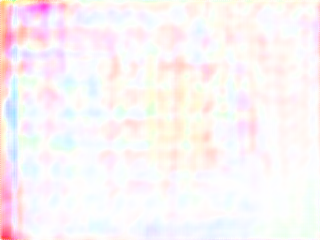

In [24]:
import importlib, numpy as np, torch
import oflow2d.adapters as adapters
importlib.reload(adapters)
from oflow2d.adapters import make_model

# due frame finti
a = np.zeros((240,320,3), np.uint8)
b = a.copy(); b[:,15:] = 255

fn2 = make_model("flownet2", device="cuda" if torch.cuda.is_available() else "cpu")
flow, vis, dt = fn2(a, b, return_rgb=True)
print("Flow:", flow.shape, flow.dtype, "  dt=%.3fs (FPS~%.1f)" % (dt, 1.0/max(1e-6, dt)))

try:
    from google.colab.patches import cv2_imshow
    if vis is not None: cv2_imshow(vis)
except Exception:
    import cv2; cv2.imwrite("/content/flow_vis_bgr.png", vis); print("Salvato /content/flow_vis_bgr.png")


rimetto il video appunto perchè ho creato un ambiente separato dove valutare Flownet2

In [26]:
from google.colab import files
up = files.upload()
VIDEO_PATH = "/content/" + next(iter(up.keys()))
print("VIDEO_PATH =", VIDEO_PATH)


Saving videotesi.mp4 to videotesi.mp4
VIDEO_PATH = /content/videotesi.mp4


warp_with_flow(img_bgr, flow)

Input: img_bgr (H×W×3, uint8), flow (H×W×2, float32) con componenti (u,v) in pixel per frame.

Cosa fa: costruisce le mappe di campionamento map_x = x + u, map_y = y + v e usa cv.remap per warp-are l’immagine (backward warping).

Perché serve: ti permette di confrontare cur con warp(prev, flow) e calcolare la diff |cur − warp(prev)|, che misura quanto bene il flow spiega il movimento.

Note utili:

Convenzione: u>0 → destra, v>0 → in giù (origine in alto a sinistra).

Se hai ridimensionato i frame prima dell’inferenza, ricordati di riportare il flow alla risoluzione originale e dividere per la scala.

borderMode=REPLICATE riduce artefatti ai bordi; puoi usare CONSTANT se preferisci bande nere.

magnitude_heatmap(flow)

Input: flow (H×W×2).

Cosa fa: calcola la magnitudo ‖(u,v)‖, normalizza su [0,255] per quel frame e applica la colormap TURBO → BGR uint8 pronto per OpenCV.

Perché serve: viz semplice e robusta quando non hai la “color wheel” (hue direzione) o vuoi solo vedere quanto ci si muove.

Attenzione: la normalizzazione è per-frame → il colore non è comparabile tra frame diversi. Se vuoi coerenza su un video, fissa una soglia (es. clip a P95 globale) e normalizza con quella.

In [27]:
# Helpers per warpare il frame col flow e creare visualizzazioni
import numpy as np, cv2 as cv

def warp_with_flow(img_bgr, flow):  # img_bgr: HxWx3 uint8, flow: HxWx2 float32 (u,v)
    h, w = img_bgr.shape[:2]
    # mappe di destinazione = coordinate + flow
    grid_x, grid_y = np.meshgrid(np.arange(w), np.arange(h))
    map_x = (grid_x + flow[...,0]).astype(np.float32)
    map_y = (grid_y + flow[...,1]).astype(np.float32)
    warped = cv.remap(img_bgr, map_x, map_y, interpolation=cv.INTER_LINEAR, borderMode=cv.BORDER_REPLICATE)
    return warped

def magnitude_heatmap(flow):  # ritorna BGR uint8 heatmap della magnitudo
    mag = np.linalg.norm(flow, axis=2)  # HxW
    mag_norm = (255 * (mag / (mag.max() + 1e-6))).astype(np.uint8)
    return cv.applyColorMap(mag_norm, cv.COLORMAP_TURBO)

def stack_horiz(*imgs):
    # ridimensiona alla stessa altezza e concatena orizzontalmente
    hs = [im.shape[0] for im in imgs if im is not None]
    if not hs: return None
    H = min(hs)
    rs = [cv.resize(im, (int(im.shape[1]*H/im.shape[0]), H)) for im in imgs]
    return cv.hconcat(rs)


Helper

warp_with_flow(img_bgr, flow): applica il campo di flusso per warp-pare prev verso cur (serve per la mappa di differenza).

magnitude_heatmap(flow): viz semplice della norma del flusso (fallback se il modello non fornisce una viz).

stack_horiz(...): concatena immagini alla stessa altezza (per il side-by-side).

normalize_flow_to_hw2(...): rende l’output del modello sempre (H,W,2) float32 anche se arriva come dict/list/torch [2,H,W] etc. (utile perché i modelli non hanno tutti la stessa forma d’uscita).


I/O video

Apre VIDEO_PATH, legge fps/size e crea 3 writer:

*_flownet2_flow.mp4 → mappa colore del flow

*_flownet2_diff.mp4 → |cur − warp(prev)| (quanto il flow spiega il movimento)

*_flownet2_side.mp4 → orig | flow | diff affiancati


Modello

fn2 = make_model("flownet2", device=...) → istanzia l’adapter FlowNet2 (PTLFlow), già pronto a ricevere immagini uint8 e a restituire flow (H,W,2).

Loop frame-to-frame

Per ogni coppia (prev, cur):

out = fn2(prev, cur, return_rgb=True) → inferenza (e viz del flow se disponibile).

Uniforma il formato con normalize_flow_to_hw2.

Calcola prev_warp = warp_with_flow(prev, flow) e poi diff = |cur − prev_warp|.

Scrive i tre stream (flow-vis, diff, side).

Stima FPS di inferenza (solo tempo modello, non include I/O).

Output finale

Stampa FPS medio (inference) e i tre percorsi MP4 salvati.

In [ ]:
# === FlowNet2: salva flow puro, diff warping, side-by-side (orig | flow | diff) ===
import os, time, math
import cv2, numpy as np, torch
from oflow2d.adapters import make_model
from google.colab.patches import cv2_imshow

assert 'VIDEO_PATH' in globals(), "Definisci prima VIDEO_PATH (o esegui l'upload)."

# ------- Helpers -------
def warp_with_flow(img_bgr, flow):
    h, w = img_bgr.shape[:2]
    gx, gy = np.meshgrid(np.arange(w), np.arange(h))
    map_x = (gx + flow[...,0]).astype(np.float32)
    map_y = (gy + flow[...,1]).astype(np.float32)
    return cv2.remap(img_bgr, map_x, map_y, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REPLICATE)

def magnitude_heatmap(flow):
    mag = np.linalg.norm(flow, axis=-1)        # [H,W]
    if mag.max() > 0: mag = mag / mag.max()
    mag8 = (mag * 255).astype(np.uint8)
    return cv2.applyColorMap(mag8, cv2.COLORMAP_TURBO)

def stack_horiz(*imgs):
    H = min(im.shape[0] for im in imgs)
    rs = [cv2.resize(im, (int(im.shape[1]*H/im.shape[0]), H)) for im in imgs]
    return cv2.hconcat(rs)

def normalize_flow_to_hw2(flow):
    # Accetta tensor/dict/list e restituisce np.float32 [H,W,2]
    if isinstance(flow, dict):
        flow = flow.get('flow', flow.get('flows', [None])[-1])
    if hasattr(flow, 'detach'):
        flow = flow.detach().float().cpu().numpy()
    if isinstance(flow, (list, tuple)):
        flow = flow[-1]
        if hasattr(flow, 'detach'):
            flow = flow.detach().float().cpu().numpy()
    flow = np.asarray(flow)
    if flow.ndim == 3 and flow.shape[0] == 2:  # [2,H,W] -> [H,W,2]
        flow = np.transpose(flow, (1,2,0))
    return flow.astype(np.float32)

# ------- IO video -------
cap = cv2.VideoCapture(VIDEO_PATH)
assert cap.isOpened(), f"Non riesco ad aprire: {VIDEO_PATH}"
in_fps = cap.get(cv2.CAP_PROP_FPS) or 30.0
W  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
H  = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fourcc = cv2.VideoWriter_fourcc(*"mp4v")

base_out = os.path.splitext(os.path.basename(VIDEO_PATH))[0]
OUT_FLOW = f"/content/{base_out}_flownet2_flow.mp4"
OUT_DIFF = f"/content/{base_out}_flownet2_diff.mp4"
OUT_SIDE = f"/content/{base_out}_flownet2_side.mp4"

vw_flow = cv2.VideoWriter(OUT_FLOW, fourcc, in_fps, (W, H))
vw_diff = cv2.VideoWriter(OUT_DIFF, fourcc, in_fps, (W, H))
vw_side = cv2.VideoWriter(OUT_SIDE, fourcc, in_fps, (W*3, H))

# ------- Modello -------
device = "cuda" if torch.cuda.is_available() else "cpu"
fn2 = make_model("flownet2", device=device)

ret, prev = cap.read()
assert ret, "Video non leggibile."
frame_idx = 0
fps_hist = []

# Primo frame “dummy” per allineare i writer
zero = np.zeros_like(prev)
vw_flow.write(zero)
vw_diff.write(zero)
vw_side.write(cv2.hconcat([prev, zero, zero]))

while True:
    ret, cur = cap.read()
    if not ret:
        break

    t0 = time.time()
    out = fn2(prev, cur, return_rgb=True)      # atteso: (flow, vis, dt) oppure (flow, vis)
    t1 = time.time()

    # Unpack robusto + timing
    if isinstance(out, tuple):
        if len(out) == 3: flow, flow_vis, dt = out
        else:             flow, flow_vis, dt = out[0], out[1], (t1 - t0)
    else:
        flow, flow_vis, dt = out, None, (t1 - t0)

    flow = normalize_flow_to_hw2(flow)
    if flow_vis is None:
        flow_vis = magnitude_heatmap(flow)     # fallback sobrio

    prev_warp = warp_with_flow(prev, flow)
    diff_bgr  = cv2.absdiff(cur, prev_warp)

    vw_flow.write(flow_vis)
    vw_diff.write(diff_bgr)

    side = stack_horiz(cur, flow_vis, diff_bgr)
    side = cv2.resize(side, (W*3, H))
    vw_side.write(side)

    if frame_idx % 30 == 0:
        try: cv2_imshow(side)
        except: pass

    fps_hist.append(1.0 / max(1e-6, dt))
    prev = cur
    frame_idx += 1

cap.release()
vw_flow.release(); vw_diff.release(); vw_side.release()

if fps_hist:
    print("Frame elaborati:", frame_idx+1)
    print("FPS medio (inference): %.2f" % (sum(fps_hist)/len(fps_hist)))
print("Salvati:")
print(" - Flow vis   ->", OUT_FLOW)
print(" - Differenze ->", OUT_DIFF)
print(" - Side-by-side (orig | flow | diff) ->", OUT_SIDE)


Qui funziona anche FLOWNET2 ora proseguiamo con PWC

assert os.path.isdir(FLOW_SITE): verifica che l’“area isolata” con i pacchetti (installati con pip -t /content/_flow_site) esista.

use_flow_site() (context manager): inserisce FLOW_SITE in testa a sys.path solo dentro il blocco with, così gli import risolvono prima i moduli da lì; all’uscita lo rimuove, ripristinando l’ambiente.

A cosa serve

Evitare conflitti di versioni (Lightning, torchmetrics, ecc.) tra PTLFlow/FlowNet2 e il resto del notebook (RAFT, SPyNet, OpenCV).

Tenere l’ambiente pulito e riproducibile: PTLFlow usa le sue dipendenze senza “sporcare” il global.

In [28]:
# Site-packages isolato già usato per FlowNet2
FLOW_SITE = "/content/_flow_site"

import sys, contextlib, os
assert os.path.isdir(FLOW_SITE), "FLOW_SITE non trovato: reinstallalo (la cella che fa pip -t /content/_flow_site ...)"

@contextlib.contextmanager
def use_flow_site():
    sys.path.insert(0, FLOW_SITE)
    try:
        yield
    finally:
        if FLOW_SITE in sys.path:
            sys.path.remove(FLOW_SITE)


Entra nel contesto with use_flow_site(): e importa ptlflow.

Prova a leggere il registro ufficiale dei modelli:
from ptlflow.utils.registry import MODEL_REGISTRY → prende le chiavi e le ordina.

Se la versione di PTLFlow non espone il registro, fa un fallback: tenta a istanziare alcuni nomi noti ("pwcnet", "pwc") con ptlflow.get_model(...); se l’instanziazione va, aggiunge il nome alla lista.

Stampa un estratto filtrato sui modelli di interesse ("pwc", "flownet", "raft"). Nel tuo output risulta: ['pwcnet']
→ significa che, nell’installazione corrente, PWC-Net è disponibile (mentre FlowNet/RAFT no o non registrati).

Garantisce version pinning e compatibilità (FlowNet2 e PTLFlow spesso hanno dipendenze delicate).

Ti dà un check rapido su quali modelli puoi effettivamente usare prima di procedere con l’adapter PWC.

In [29]:
with use_flow_site():
    import ptlflow
    try:
        # Alcune versioni espongono il registro
        from ptlflow.utils.registry import MODEL_REGISTRY
        names = sorted(list(MODEL_REGISTRY.keys()))
    except Exception:
        # Fallback: prova a istanziare i nomi più comuni e vedi quali passano
        names = []
        for n in ("pwcnet", "pwc"):
            try:
                _ = ptlflow.get_model(n, ckpt_path=None)
                names.append(n)
            except Exception:
                pass
    print("Modelli PTLFlow disponibili (estratto):", [n for n in names if "pwc" in n or "flownet" in n or "raft" in n])


Modelli PTLFlow disponibili (estratto): ['pwcnet']


Context manager use_flow_site(): importa PTLFlow e dipendenze dal recinto /content/_flow_site per evitare conflitti con RAFT/SPyNet.

Costruzione modello:

Prova ptlflow.get_model('pwcnet', ckpt_path=ckpt) e in fallback 'pwc'.

Mette il modello su cuda se disponibile, in eval().

Prepara IOAdapter di PTLFlow per formattare gli input correttamente (batch (1,2,3,H,W)).

Chiamata __call__(img0_uint8, img1_uint8, return_rgb=False):

Verifica uint8 (frame OpenCV).

Usa IOAdapter.prepare_inputs([...]) per creare gli input.

Esegue il forward e prende l’ultimo flow (gestisce sia preds['flows'] che preds['flow'], e shape [B,1,2,H,W]).

Converte sempre l’output in (H, W, 2) float32.

Se richiesto, crea una viz RGB con flow_to_rgb di PTLFlow (poi convertita BGR per OpenCV).

Ritorna (flow, vis, dt).

Perché serve

API unificata: tutti i modelli rispondono allo stesso modo (flow H×W×2), integrandosi al volo con process_video e con i loop di valutazione.

Ambiente stabile: PTLFlow e le sue versioni di lightning/torchmetrics/timm restano nel loro recinto, senza toccare RAFT/SPyNet.

In [30]:
# oflow2d/adapters/pwcnet_adapter.py
import os, textwrap, pathlib
base="/content"; pkg=f"{base}/oflow2d"; adp=f"{pkg}/adapters"
os.makedirs(adp, exist_ok=True); pathlib.Path(f"{pkg}/__init__.py").touch(); pathlib.Path(f"{adp}/__init__.py").touch()

code = r'''
import time, torch, numpy as np, cv2 as cv

# usa il context manager del notebook per caricare PTLFlow dal site isolato
try:
    from __main__ import use_flow_site
except Exception:
    import sys
    FLOW_SITE = "/content/_flow_site"
    def use_flow_site():
        class _Ctx:
            def __enter__(self): sys.path.insert(0, FLOW_SITE)
            def __exit__(self, *a):
                if FLOW_SITE in sys.path: sys.path.remove(FLOW_SITE)
        return _Ctx()

class PWCNetAdapter:
    def __init__(self, device=None, ckpt="things"):
        self.device = torch.device(device) if device else torch.device("cuda" if torch.cuda.is_available() else "cpu")
        with use_flow_site():
            import ptlflow
            last_err = None
            for name in ("pwcnet", "pwc"):
                try:
                    self.model = ptlflow.get_model(name, ckpt_path=ckpt).to(self.device).eval()
                    self._model_name = name
                    break
                except Exception as e:
                    last_err = e
            if not hasattr(self, "model"):
                raise RuntimeError(f"PWCNet non trovato in PTLFlow: {type(last_err).__name__}: {last_err}")

            from ptlflow.utils.io_adapter import IOAdapter
            from ptlflow.utils import flow_utils
            self.IOAdapter = IOAdapter
            self._flow_to_rgb = flow_utils.flow_to_rgb

        self._io = None

    @torch.inference_mode()
    def __call__(self, img0_uint8, img1_uint8, return_rgb=False):
        assert img0_uint8.dtype == np.uint8 and img1_uint8.dtype == np.uint8, "Servono frame uint8 BGR"
        h, w = img0_uint8.shape[:2]
        if self._io is None:
            self._io = self.IOAdapter(self.model, (h, w))

        x = self._io.prepare_inputs([img0_uint8, img1_uint8])  # {'images': (1,2,3,H,W)}
        for k in x: x[k] = x[k].to(self.device, non_blocking=True)

        t0 = time.time()
        preds = self.model(x)
        t1 = time.time()

        flows = preds.get("flows", preds.get("flow", None))
        if flows is None:
            raise RuntimeError("PTLFlow/PWCNet: output 'flows'/'flow' non trovato.")

        ft = flows[-1] if isinstance(flows, (list, tuple)) else flows
        if ft.dim() == 5:  # (B,1,2,H,W) -> (B,2,H,W)
            ft = ft[:, 0]

        flow = ft[0].permute(1,2,0).detach().cpu().float().numpy()  # HxWx2

        vis = None
        if return_rgb:
            rgb = self._flow_to_rgb(ft)[0].permute(1,2,0).detach().cpu().numpy()
            vis = cv.cvtColor((rgb*255).astype(np.uint8), cv.COLOR_RGB2BGR)

        return flow, vis, (t1 - t0)
'''
open(f"{adp}/pwcnet_adapter.py","w").write(textwrap.dedent(code))
print("Scritto:", f"{adp}/pwcnet_adapter.py")


Scritto: /content/oflow2d/adapters/pwcnet_adapter.py


Apre .../oflow2d/adapters/__init__.py e legge il testo.

Se non trova una definizione di make_model(...):

scrive un file nuovo che importa gli adapter (FlowNet2Adapter, PWCNetAdapter, e opzionalmente RAFT/SpyNet) e definisce make_model(name, **kwargs) con le alias:

RAFT: "raft","raft_small","raft_sintel"

SpyNet: "spynet","spy","spynet_pkg","spynet-niklaus" (con fallback tra due adapter)

FlowNet2: "flownet2","flownet","fn2"

PWC-Net: "pwc","pwcnet","pwc-net"

Se la factory esiste già:

Si assicura che in testa ci siano gli import di PWCNetAdapter e FlowNet2Adapter (se mancano li aggiunge).

Inserisce il ramo if n in ("pwc","pwcnet","pwc-net") prima del raise ValueError(...), se non è già presente.

Salva il file aggiornato e stampa a video il contenuto finale per controllo.

In [31]:
# Aggiorna / crea la factory includendo 'pwc'/'pwcnet'/'pwc-net'
from pathlib import Path
f = Path("/content/oflow2d/adapters/__init__.py")
txt = f.read_text()

if "def make_model(" not in txt:
    # crea una factory completa se non esiste
    txt = """from .flownet2_adapter import FlowNet2Adapter
from .pwcnet_adapter import PWCNetAdapter
def make_model(name: str, **kwargs):
    n = (name or "").lower()
    if n in ("raft","raft_small","raft_sintel"):
        from .raft_adapter import RaftAdapter; return RaftAdapter(**kwargs)
    if n in ("spynet","spy","spynet_pkg","spynet-niklaus"):
        try:
            from .spynet_adapter import SpyNetAdapter; return SpyNetAdapter(**kwargs)
        except Exception:
            from .spynet_pkg import SpyNetPkgAdapter; return SpyNetPkgAdapter(**kwargs)
    if n in ("flownet2","flownet","fn2"): return FlowNet2Adapter(**kwargs)
    if n in ("pwc","pwcnet","pwc-net"): return PWCNetAdapter(**kwargs)
    raise ValueError(f"Unknown model: {name}")
"""
else:
    # garantisci gli import in testa
    if "from .pwcnet_adapter import PWCNetAdapter" not in txt:
        txt = "from .pwcnet_adapter import PWCNetAdapter\n" + txt
    if "from .flownet2_adapter import FlowNet2Adapter" not in txt:
        txt = "from .flownet2_adapter import FlowNet2Adapter\n" + txt
    # inserisci il ramo PWC prima del raise finale
    if '("pwc","pwcnet","pwc-net")' not in txt:
        txt = txt.replace(
            "    raise ValueError(f\"Unknown model: {name}\")",
            "    if n in (\"pwc\",\"pwcnet\",\"pwc-net\"): return PWCNetAdapter(**kwargs)\n"
            "    raise ValueError(f\"Unknown model: {name}\")"
        )

f.write_text(txt)
print("Factory aggiornata.\n--- FILE ---\n", f.read_text())


Factory aggiornata.
--- FILE ---
 from .pwcnet_adapter import PWCNetAdapter

from .flownet2_adapter import FlowNet2Adapter

def make_model(name: str, **kwargs):
    n = (name or "").lower()
    if n in ("raft","raft_small","raft_sintel"):
        from .raft_adapter import RaftAdapter; return RaftAdapter(**kwargs)
    if n in ("spynet","spy","spynet_pkg","spynet-niklaus"):
        try:
            from .spynet_adapter import SpyNetAdapter; return SpyNetAdapter(**kwargs)
        except Exception:
            from .spynet_pkg import SpyNetPkgAdapter; return SpyNetPkgAdapter(**kwargs)
    if n in ("flownet2","flownet","fn2"):
        return FlowNet2Adapter(**kwargs)
    if n in ("pwc","pwcnet","pwc-net"): return PWCNetAdapter(**kwargs)
    raise ValueError(f"Unknown model: {name}")



Smoke test generico su PWC

Downloading: "https://github.com/hmorimitsu/ptlflow/releases/download/weights1/pwcdcnet-things-cc223701.ckpt" to /root/.cache/torch/hub/checkpoints/pwcdcnet-things-cc223701.ckpt


100%|██████████| 35.8M/35.8M [00:00<00:00, 49.4MB/s]
2025-11-12 14:35:45.833 | INFO     | ptlflow:restore_model:283 - Restored model state from checkpoint: things


PWCNet -> (240, 320, 2) float32  dt=0.082s (FPS~12.2)


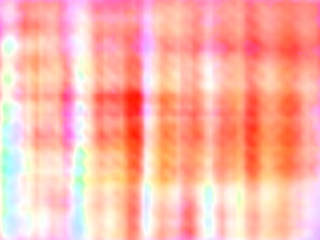

In [32]:
# Smoke test
import importlib, numpy as np, torch
import oflow2d.adapters as adapters
importlib.reload(adapters)
from oflow2d.adapters import make_model

a = np.zeros((240,320,3), np.uint8)
b = a.copy(); b[:,15:] = 255

pwc = make_model("pwcnet", device="cuda" if torch.cuda.is_available() else "cpu")
flow, vis, dt = pwc(a, b, return_rgb=True)
print("PWCNet ->", flow.shape, flow.dtype, " dt=%.3fs (FPS~%.1f)" % (dt, 1.0/max(1e-6, dt)))

try:
    from google.colab.patches import cv2_imshow
    if vis is not None: cv2_imshow(vis)
except Exception:
    import cv2; cv2.imwrite("/content/pwcnet_flow_vis.png", vis); print("Salvato /content/pwcnet_flow_vis.png")


la stessa cella che abbiamo messo sopra Flownet2

In [33]:
# Se li hai già nel notebook, SALTA questa cella.
import numpy as np, cv2 as cv

def warp_with_flow(img_bgr, flow):
    h, w = img_bgr.shape[:2]
    gx, gy = np.meshgrid(np.arange(w), np.arange(h))
    map_x = (gx + flow[...,0]).astype(np.float32)
    map_y = (gy + flow[...,1]).astype(np.float32)
    return cv.remap(img_bgr, map_x, map_y, interpolation=cv.INTER_LINEAR, borderMode=cv.BORDER_REPLICATE)

def magnitude_heatmap(flow):
    mag = np.linalg.norm(flow, axis=2)
    mag = (255 * (mag / (mag.max() + 1e-6))).astype(np.uint8)
    return cv.applyColorMap(mag, cv.COLORMAP_TURBO)

def stack_horiz(*imgs):
    hs = [im.shape[0] for im in imgs if im is not None]
    H = min(hs)
    rs = [cv.resize(im, (int(im.shape[1]*H/im.shape[0]), H)) for im in imgs]
    return cv.hconcat(rs)


altro helper per la visualizzazione

In [34]:
# Warp col flow + util per montage
import numpy as np, cv2 as cv

def warp_with_flow(img_bgr, flow):
    h, w = img_bgr.shape[:2]
    gx, gy = np.meshgrid(np.arange(w), np.arange(h))
    map_x = (gx + flow[...,0]).astype(np.float32)
    map_y = (gy + flow[...,1]).astype(np.float32)
    return cv.remap(img_bgr, map_x, map_y, interpolation=cv.INTER_LINEAR, borderMode=cv.BORDER_REPLICATE)

def stack_horiz(*imgs):
    H = min(im.shape[0] for im in imgs if im is not None)
    rs = [cv.resize(im, (int(im.shape[1]*H/im.shape[0]), H)) for im in imgs]
    return cv.hconcat(rs)


Input & setup
Verifica VIDEO_PATH, apre il video con OpenCV, legge FPS/dimensioni e prepara tre VideoWriter in /content/outputs/:

*_pwcnet_flow.mp4 (visualizzazione del flow)

*_pwcnet_diff.mp4 (residuo |cur − warp(prev, flow)|)

*_pwcnet_side.mp4 (affiancato: cur | flow | diff).
Istanzia il modello con make_model("pwcnet", device=...) (GPU se disponibile).

Allineamento timeline
Scrive una prima riga dummy: un frame nero per flow/diff e un side-by-side con prev a sinistra, così gli output hanno la stessa lunghezza del video originale.

Loop di elaborazione (prev → cur)
Per ogni coppia di frame consecutivi:

esegue PWC-Net e ottiene flow (H×W×2) e, se disponibile, flow_vis (RGB→BGR già pronto a video);

misura un tempo esterno dt (quindi l’FPS calcolato include anche un po’ di overhead I/O, non solo la pura inferenza);

fa il warping di prev con il flow e calcola la differenza assoluta col frame corrente (diff_bgr);

scrive i tre flussi video: flow_vis (o diff_bgr come fallback), diff_bgr, e il side-by-side ridimensionato a (W*3, H);

mostra un’anteprima ogni ~30 frame.

Chiusura & report
Rilascia tutto, stampa i frame processati, l’FPS medio (dal timing esterno) e i percorsi dei tre file salvati.

In [ ]:
# Se non hai VIDEO_PATH:
# from google.colab import files
# up = files.upload()
# VIDEO_PATH = "/content/" + next(iter(up.keys()))
assert 'VIDEO_PATH' in globals(), "Definisci prima VIDEO_PATH (o carica un video)."

import os, cv2, time, numpy as np, torch
from oflow2d.adapters import make_model
from google.colab.patches import cv2_imshow

cap = cv2.VideoCapture(VIDEO_PATH); assert cap.isOpened(), VIDEO_PATH
fps_in = cap.get(cv2.CAP_PROP_FPS) or 30.0
W  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
H  = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fourcc = cv2.VideoWriter_fourcc(*"mp4v")

base = os.path.splitext(os.path.basename(VIDEO_PATH))[0]
OUT_DIR = "/content/outputs"; os.makedirs(OUT_DIR, exist_ok=True)
OUT_FLOW = f"{OUT_DIR}/{base}_pwcnet_flow.mp4"
OUT_DIFF = f"{OUT_DIR}/{base}_pwcnet_diff.mp4"
OUT_SIDE = f"{OUT_DIR}/{base}_pwcnet_side.mp4"

vw_flow = cv2.VideoWriter(OUT_FLOW, fourcc, fps_in, (W, H))
vw_diff = cv2.VideoWriter(OUT_DIFF, fourcc, fps_in, (W, H))
vw_side = cv2.VideoWriter(OUT_SIDE, fourcc, fps_in, (W*3, H))

device = "cuda" if torch.cuda.is_available() else "cpu"
pwc = make_model("pwcnet", device=device)

ret, prev = cap.read(); assert ret
fps_hist, i = [], 0

# prima riga “dummy” per avere stesso numero frame
blank = np.zeros_like(prev)
vw_flow.write(blank); vw_diff.write(blank); vw_side.write(cv2.hconcat([prev, blank, blank]))

while True:
    ret, cur = cap.read()
    if not ret: break

    t0 = time.time()
    flow, flow_vis, _ = pwc(prev, cur, return_rgb=True)
    dt = time.time() - t0
    fps_hist.append(1.0/max(1e-6, dt))

    prev_warp = warp_with_flow(prev, flow)
    diff_bgr  = cv2.absdiff(cur, prev_warp)

    vw_flow.write(flow_vis if flow_vis is not None else diff_bgr)
    vw_diff.write(diff_bgr)
    side = stack_horiz(cur, flow_vis if flow_vis is not None else diff_bgr, diff_bgr)
    side = cv2.resize(side, (W*3, H))
    vw_side.write(side)

    if i % 30 == 0:
        try: cv2_imshow(side)
        except: pass

    prev = cur; i += 1

cap.release(); vw_flow.release(); vw_diff.release(); vw_side.release()

print(f"Frame elaborati: {i+1}")
if fps_hist: print("FPS medio (PWC-Net): %.2f" % (sum(fps_hist)/len(fps_hist)))
print("Salvati:")
print(" - Flow vis:", OUT_FLOW)
print(" - Differenze:", OUT_DIFF)
print(" - Side-by-side:", OUT_SIDE)


Funziona anche PWC perfetto , ora procediamo con l'unione


In [35]:
print(torch.__version__)

2.8.0+cu126


In [36]:
# === CELLA 1: CREA/RESETTA LA CARTELLA DI LAVORO ===
import os, shutil
from pathlib import Path

TARGET_DIR = "/content/oflow_exports"   # <-- puoi cambiare path se vuoi

# Crea la cartella se non esiste
Path(TARGET_DIR).mkdir(parents=True, exist_ok=True)

# (Opzionale) Svuota la cartella per evitare confusione con file vecchi
for p in Path(TARGET_DIR).glob("*"):
    try:
        p.unlink()
    except IsADirectoryError:
        shutil.rmtree(p)

print(f"✅ Cartella pronta: {TARGET_DIR}")


✅ Cartella pronta: /content/oflow_exports


In [37]:
# === CELLA 2: CARICA I 4 VIDEO NELLA CARTELLA ===
from pathlib import Path
import os, shutil, sys

# Usa il selettore file di Colab (se sei in Colab)
try:
    from google.colab import files
    uploaded = files.upload()  # seleziona i 4 .mp4
    src_files = list(uploaded.keys())
except Exception as e:
    print("ℹ️ Non sei in Colab o file.upload non disponibile. "
          "Copiami manualmente 4 .mp4 dentro:", TARGET_DIR)
    src_files = []

# Sposta i file caricati nella cartella di lavoro
moved = []
for name in src_files:
    if not name.lower().endswith(".mp4"):
        print(f"⚠️ Salto (non .mp4): {name}")
        continue
    dst = str(Path(TARGET_DIR) / Path(name).name)
    shutil.move(name, dst)
    moved.append(dst)

# Verifica
videos = sorted([p for p in Path(TARGET_DIR).glob("*.mp4") if p.is_file()])
print(f"\nTrovati {len(videos)} video in {TARGET_DIR}:")
for v in videos:
    print(" -", v.name)

assert len(videos) == 4, (
    f"Attesi 4 .mp4 in {TARGET_DIR}. Ne ho trovati {len(videos)}. "
    "Ricarica/aggiungi i file e rilancia questa cella."
)
print("✅ Ok: 4 video pronti.")


Saving Flownet.mp4 to Flownet.mp4
Saving Pwc.mp4 to Pwc.mp4
Saving Raft.mp4 to Raft.mp4
Saving Spy.mp4 to Spy.mp4

Trovati 4 video in /content/oflow_exports:
 - Flownet.mp4
 - Pwc.mp4
 - Raft.mp4
 - Spy.mp4
✅ Ok: 4 video pronti.


Input: cerca esattamente 4 MP4 in TARGET_DIR (puoi cambiare pattern="*.mp4").

Probe video: fps, n. frame, risoluzione, durata.

Scansione: legge i frame ogni sample_every (default 2) fino a max_frames.

Metriche per-video (tutte su frame in scala di grigi):

frame_diff_avg/std: media/deviazione della differenza |t − (t−1)|.

TJI: Temporal Jitter Index (qui uguale a std(diff)): quanto “balla” nel tempo.

ssim_avg/std: SSIM tra frame consecutivi (stabilità temporale: più alto = meglio).

ecr_avg/std: Edge Change Ratio (Canny + XOR tra bordi consecutivi).

Proxy da colori HSV (se assume_hsv=True):

hsv_mag_avg/std: media/deviazione della magnitudo (dal canale V).

dir_vec_u/v_(avg/std): media dei vettori di direzione (cos/sin(Hue)).

⚠️ Vale se i video sono viz HSV in cui Hue = direzione e Value = magnitudo (come la tua flow_to_color). Se i video non rispettano questa convenzione, metti assume_hsv=False.

Accordo tra video (make_pairwise=True): per ogni coppia tra i 4, SSIM medio e std tra le sequenze (downscalate a 320×180) → misura quanto due viz sono simili nel tempo.

Output:

metrics_per_video.csv

pairwise_agreement.csv (se calcolato)

report_metrics.html con le tabelle.

Perché è utile

Consente un confronto rapido tra viz di modelli diversi senza GT né runtime dei modelli.

Dà indicatori di stabilità temporale (SSIM, TJI) e variazione strutturale (ECR).

I proxy HSV danno un’idea aggregata di intensità del movimento e direzione media.

Limiti e dritte

In [38]:
# === CELLA 3: METRICHE SU 4 VIDEO ESISTENTI (NO RUNTIME MODELLI) ===
import os, itertools
from pathlib import Path
import cv2
import numpy as np
import pandas as pd

# Dipendenza: scikit-image per SSIM
try:
    from skimage.metrics import structural_similarity as ssim
except Exception:
    import sys
    !{sys.executable} -q -m pip install scikit-image
    from skimage.metrics import structural_similarity as ssim

def _video_probe(path):
    cap = cv2.VideoCapture(path)
    if not cap.isOpened():
        return None
    fps = cap.get(cv2.CAP_PROP_FPS) or 0.0
    n   = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    w   = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    h   = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    cap.release()
    return dict(file=Path(path).name, path=str(path), fps=fps, frames=n, width=w, height=h,
                duration_s=(n/fps if fps>0 else float("nan")))

def _frame_iter(path, sample_every=2, max_frames=800):
    cap = cv2.VideoCapture(path)
    if not cap.isOpened():
        return
    total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    limit = min(total, max_frames) if max_frames else total
    idx = 0
    while idx < limit:
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ok, frame = cap.read()
        if not ok: break
        yield frame
        idx += sample_every
    cap.release()

def _gray(frame):
    return cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

def _edges(gray):
    g = cv2.GaussianBlur(gray, (3,3), 0)
    return cv2.Canny(g, 64, 128)

def _flow_hsv_proxy(frame_bgr):
    # Proxy per flow-viz HSV (OpenCV): direzione ~ Hue, magnitudine ~ Value
    hsv = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2HSV)
    H = hsv[...,0].astype(np.float32) * 2.0     # 0..360 approx (OpenCV usa 0..180)
    V = hsv[...,2].astype(np.float32) / 255.0   # magnitudine proxy
    ang = np.deg2rad(H)
    u = np.cos(ang); v = np.sin(ang)
    return V, u, v

def analyze_flow_videos(
    input_dir,
    pattern="*.mp4",
    sample_every=2,
    max_frames=800,
    assume_hsv=True,
    make_pairwise=True,
    save_report=True
):
    input_dir = Path(input_dir)
    files = sorted([p for p in input_dir.glob(pattern) if p.is_file()])
    assert len(files) == 4, f"Attesi 4 .mp4, trovati {len(files)}."

    rows = []
    per_video_series = {}

    for p in files:
        pr = _video_probe(str(p))
        if pr is None:
            print(f"⚠️ Salto file non apribile: {p}")
            continue

        diffs, ssims, ecrs = [], [], []
        mags, us_list, vs_list = [], [], []
        prev_gray = None
        prev_edges = None
        series_gray = []

        for frame in _frame_iter(str(p), sample_every=sample_every, max_frames=max_frames):
            g = _gray(frame).astype(np.float32)
            series_gray.append(cv2.resize(g, (320, 180)))

            if prev_gray is not None:
                diffs.append(float(np.mean(np.abs(g - prev_gray))))
                s = ssim(prev_gray.astype(np.uint8), g.astype(np.uint8), data_range=255)
                ssims.append(float(s))
                e_prev = prev_edges
                e_cur  = _edges(g.astype(np.uint8))
                if e_prev is not None:
                    changed = np.logical_xor(e_prev>0, e_cur>0).mean()
                    ecrs.append(float(changed))
                prev_edges = e_cur
            else:
                prev_edges = _edges(g.astype(np.uint8))

            if assume_hsv:
                mag, u, v = _flow_hsv_proxy(frame)
                mags.append(float(np.mean(mag)))
                us_list.append(float(np.mean(u)))
                vs_list.append(float(np.mean(v)))

            prev_gray = g

        row = dict(
            file=pr["file"],
            fps=round(pr["fps"],3),
            frames=pr["frames"],
            width=pr["width"], height=pr["height"],
            duration_s=(round(pr["duration_s"],3) if isinstance(pr["duration_s"], (int,float)) else float("nan")),
            TJI=round(float(np.std(diffs)) if diffs else float("nan"), 6),
            frame_diff_avg=round(float(np.mean(diffs)) if diffs else float("nan"), 6),
            frame_diff_std=round(float(np.std(diffs)) if diffs else float("nan"), 6),
            ssim_avg=round(float(np.mean(ssims)) if ssims else float("nan"), 6),
            ssim_std=round(float(np.std(ssims)) if ssims else float("nan"), 6),
            ecr_avg=round(float(np.mean(ecrs)) if ecrs else float("nan"), 6),
            ecr_std=round(float(np.std(ecrs)) if ecrs else float("nan"), 6),
        )
        if assume_hsv and mags:
            row.update(
                hsv_mag_avg=round(float(np.mean(mags)), 6),
                hsv_mag_std=round(float(np.std(mags)), 6),
                dir_vec_u_avg=round(float(np.mean(us_list)), 6),
                dir_vec_v_avg=round(float(np.mean(vs_list)), 6),
                dir_vec_u_std=round(float(np.std(us_list)), 6),
                dir_vec_v_std=round(float(np.std(vs_list)), 6),
            )
        rows.append(row)
        per_video_series[pr["file"]] = series_gray

    df = pd.DataFrame(rows)
    out_csv1 = input_dir / "metrics_per_video.csv"
    df.to_csv(out_csv1, index=False)

    pair_rows = []
    if make_pairwise:
        names = list(per_video_series.keys())
        for a, b in itertools.combinations(names, 2):
            sa, sb = per_video_series[a], per_video_series[b]
            L = min(len(sa), len(sb))
            if L < 3:
                continue
            vals = []
            for i in range(L):
                ga = cv2.normalize(sa[i], None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
                gb = cv2.normalize(sb[i], None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
                vals.append(ssim(ga, gb, data_range=255))
            pair_rows.append(dict(
                video_a=a, video_b=b,
                pairwise_ssim_avg=float(np.mean(vals)),
                pairwise_ssim_std=float(np.std(vals)),
                frames_compared=L
            ))
    df_pairs = pd.DataFrame(pair_rows)
    out_csv2 = input_dir / "pairwise_agreement.csv"
    if not df_pairs.empty:
        df_pairs.to_csv(out_csv2, index=False)

    if save_report:
        html_path = input_dir / "report_metrics.html"
        with open(html_path, "w", encoding="utf-8") as f:
            f.write("<h2>Optical-Flow Video Diagnostics (no-runtime)</h2>")
            f.write("<h3>Per-video metrics</h3>")
            f.write(df.to_html(index=False))
            if not df_pairs.empty:
                f.write("<h3>Pairwise agreement (SSIM)</h3>")
                f.write(df_pairs.to_html(index=False))
            f.write("<p><i>Note:</i> EPE/Fl-all/Angular Error richiedono il campo di flusso o GT. "
                    "Qui usiamo proxy robusti calcolati direttamente dai video.</p>")

    print(f"✅ Salvato: {out_csv1}")
    if not df_pairs.empty:
        print(f"✅ Salvato: {out_csv2}")
    if save_report:
        print(f"✅ Salvato: {html_path}")

# ESECUZIONE (usa la stessa TARGET_DIR della Cella 1/2)
analyze_flow_videos(
    input_dir=TARGET_DIR,
    pattern="*.mp4",
    sample_every=2,     # aumenta (3-4) se i video sono lunghi
    max_frames=800,     # limita i frame per velocità
    assume_hsv=True,    # True se i video sono flow-viz HSV
    make_pairwise=True,
    save_report=True
)


✅ Salvato: /content/oflow_exports/metrics_per_video.csv
✅ Salvato: /content/oflow_exports/pairwise_agreement.csv
✅ Salvato: /content/oflow_exports/report_metrics.html


Provo a caricare i dataset


In [39]:
# Monta Drive se sei in Colab
try:
    import google.colab  # noqa
    from google.colab import drive
    drive.mount('/content/drive')
    print("✓ Drive montato in /content/drive")
except Exception as e:
    print("⚠️ Non sei in Colab o mount non disponibile:", e)


Mounted at /content/drive
✓ Drive montato in /content/drive


In [40]:
# Reimposta i path (gli stessi che avevamo già validato)
SINTEL_ROOT = "/content/drive/MyDrive/datasets/MPI-Sintel-complete"
CHAIRS_ROOT = "/content/drive/MyDrive/datasets/FlyingChairs/FlyingChairs_release"

SINTEL_SUBSET = None
CHAIRS_SUBSET = None

print("SINTEL_ROOT =", SINTEL_ROOT)
print("CHAIRS_ROOT  =", CHAIRS_ROOT)


SINTEL_ROOT = /content/drive/MyDrive/datasets/MPI-Sintel-complete
CHAIRS_ROOT  = /content/drive/MyDrive/datasets/FlyingChairs/FlyingChairs_release


In [41]:
import os, glob

print("[SINTEL] final:", os.path.isdir(f"{SINTEL_ROOT}/training/final"),
      "clean:", os.path.isdir(f"{SINTEL_ROOT}/training/clean"),
      "flow:",  os.path.isdir(f"{SINTEL_ROOT}/training/flow"))

print("[CHAIRS] data:", os.path.isdir(f"{CHAIRS_ROOT}/data"))

# Conto esempi base (senza subset)
len_sintel = len(sorted(glob.glob(f"{SINTEL_ROOT}/training/final/*/frame_0001.png")))
len_chairs = len(sorted(glob.glob(f"{CHAIRS_ROOT}/data/*_img1.ppm")))
print(f"Campioni Sintel (frame_0001): {len_sintel}")
print(f"Campioni Chairs (_img1.ppm):  {len_chairs}")


[SINTEL] final: True clean: True flow: True
[CHAIRS] data: True
Campioni Sintel (frame_0001): 23
Campioni Chairs (_img1.ppm):  0


1) Lettori del GT
read_flo(path)

I file .flo (Sintel, FlyingChairs) contengono direttamente i vettori di flusso.

Dentro c’è:

un numeretto magico (202021.25) per riconoscere il formato,

larghezza, altezza,

poi i valori (u,v) per ogni pixel.

La funzione legge tutto e ti restituisce un array (H, W, 2) in float32 con u (spostamento orizzontale) e v (verticale), espressi in pixel.

read_kitti_png(path)

In KITTI 2015 il GT è salvato in PNG a 16 bit con una codifica strana:

canale R = u codificato come (R − 2^15) / 64,

canale G = v codificato come (G − 2^15) / 64,

canale B > 0 significa pixel valido (dove il GT esiste).

La funzione decodifica tutto e ritorna:

flow (H, W, 2) in float32,

valid (H, W) booleano (True dove il GT è affidabile).

Nota: la convenzione è la solita: u>0 verso destra, v>0 verso il basso.


2) Metriche

Tutte usano la mask valid per ignorare i pixel senza GT (importantissimo in KITTI).

epe(pred, gt, valid)

EPE = “End-Point Error”.

Per ogni pixel valido calcola la distanza tra il vettore stimato e quello vero:
|pred − gt|

Ritorna la media (in pixel). Più basso = meglio.

fl_all(pred, gt, valid, thr_pix=3, thr_rel=0.05)

Fl-all % (metrica ufficiale KITTI): un pixel è “sbagliato” se entrambe:

errore > 3 px, e

errore > 5% della magnitudo del GT.

Ritorna la percentuale di pixel “bad” (sui validi). Più basso = meglio.

angular_error(pred, gt, valid)

Angular Error = angolo medio (in gradi) tra i vettori pred e gt.

Per evitare problemi quando il flusso è quasi zero, usa un trucchetto classico: confronta i vettori (u, v, 1) invece di (u, v) (così non dividi per zero).

Più basso = meglio.



In [42]:
# === D1: readers (.flo Sintel, .png KITTI) + metriche ===
import numpy as np, cv2, struct

TAG_FLOAT = 202021.25  # .flo tag

def read_flo(path: str) -> np.ndarray:
    with open(path, 'rb') as f:
        tag = struct.unpack('f', f.read(4))[0]
        if tag != TAG_FLOAT:
            raise ValueError(f"Invalid .flo tag: {path}")
        w = struct.unpack('i', f.read(4))[0]
        h = struct.unpack('i', f.read(4))[0]
        data = np.fromfile(f, np.float32, count=2*w*h)
        return np.reshape(data, (h, w, 2))

def read_kitti_png(path: str):
    """Ritorna (flow HxWx2 float32, valid HxW bool) da KITTI 2015 .png"""
    im = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    if im is None:
        raise FileNotFoundError(path)
    B = im[:,:,0].astype(np.float32)
    G = im[:,:,1].astype(np.float32)
    R = im[:,:,2].astype(np.float32)
    valid = B > 0
    u = (R - 2**15) / 64.0
    v = (G - 2**15) / 64.0
    flow = np.stack([u, v], axis=-1).astype(np.float32)
    return flow, valid

# --- metriche ---
def epe(pred: np.ndarray, gt: np.ndarray, valid: np.ndarray) -> float:
    dv = pred - gt
    mag = np.linalg.norm(dv, axis=-1)
    return float(np.mean(mag[valid]))

def fl_all(pred: np.ndarray, gt: np.ndarray, valid: np.ndarray, thr_pix: float = 3.0, thr_rel: float = 0.05) -> float:
    dv = pred - gt
    err = np.linalg.norm(dv, axis=-1)
    gmag = np.linalg.norm(gt, axis=-1)
    bad = (err > thr_pix) & (err / (gmag + 1e-6) > thr_rel)
    bad &= valid
    return float(100.0 * bad.sum() / (valid.sum() + 1e-6))

def angular_error(pred: np.ndarray, gt: np.ndarray, valid: np.ndarray) -> float:
    u1, v1 = pred[...,0], pred[...,1]
    u2, v2 = gt[...,0], gt[...,1]
    dot = u1*u2 + v1*v2 + 1.0
    n1  = np.sqrt(u1*u1 + v1*v1 + 1.0)
    n2  = np.sqrt(u2*u2 + v2*v2 + 1.0)
    cos = np.clip(dot / (n1*n2 + 1e-6), -1.0, 1.0)
    ang = np.degrees(np.arccos(cos))
    return float(np.mean(ang[valid]))


D2 – Loader
MPISintel

Assume struttura
ROOT/training/final|clean/SCENA/frame_0001.png, frame_0002.png
ROOT/training/flow/SCENA/frame_0001.flo

Costruisce la lista di coppie (img1,img2,flowGT): per ogni frame_0001 prende frame_0002 e il .flo corrispondente.

__getitem__ restituisce:
img1 RGB, img2 RGB, flow_gt (H,W,2), valid = ones(H,W), e un piccolo meta con i path.

FlyingChairs

Assume struttura
ROOT/data/00001_img1.ppm, 00001_img2.ppm, 00001_flow.flo

Stessa logica: crea triple (img1,img2,flowGT) a partire dai filename.

KITTI15

Assume struttura
ROOT/training/image_2/*_10.png e *_11.png
ROOT/training/flow_occ/*_10.png (o flow_noc/)

Per ogni *_10.png abbina *_11.png e il PNG del flow GT.

__getitem__ usa read_kitti_png → ritorna anche la mask valid (fondamentale per le metriche).



D3 – Modelli + valutatore
_InferWrapper + get_model

Rende “uniforme” l’inferenza: qualunque oggetto che abbia infer(...) o __call__(...) o predict(...) viene chiamato allo stesso modo.

get_model(name, **kwargs) richiama la tua factory (oflow2d.adapters.make_model) e lo incarta nel wrapper.

_to_numpy_flow(x)

Normalizza l’output del modello in formato (H,W,2) float32:

accetta dict ({'flow': ..., 'flows': [...]}), liste/tuple, torch.Tensor con shape diverse ([B,2,H,W], [2,H,W]…), e le converte sempre in (H,W,2).

_match_size(flow_pred, ref_h, ref_w)

Se il modello ha lavorato su immagini ridotte, ridimensiona il flow alla risoluzione GT e scala le componenti (u,v) per mantenere l’unità in pixel.

get_dataset(...)

Router che istanzia il loader giusto a partire da name ("sintel", "chairs", "kitti15"…).

(Per VKITTI2 delega a una classe esterna VirtualKitti2 se ce l’hai nel file indicato.)

run_batch_eval(model_name, dataset_name, root, subset=None, **dkw)

Ciclo completo di valutazione:

Crea il dataset (usa dkw per cose come pass_name, flow_subdir).

Crea il modello (passa dkw anche qui: in pratica gli extra non usati vengono ignorati).

Per ogni sample: inferenza → _to_numpy_flow → _match_size → metriche (EPE, Fl-all, AE) → tempo.

Ritorna un dict con le medie e l’FPS mediano.

pretty_print_results(...) stampa il riepilogo in modo pulito.

In [43]:
# === D2: dataset loader (Sintel, FlyingChairs; KITTI opzionale) ===
import os, glob
import numpy as np, cv2

class MPISintel:
    """
    Struttura:
      ROOT/
        training/
          final|clean/SCENE/frame_0001.png, frame_0002.png, ...
        training/flow/SCENE/frame_0001.flo
    subset_list (opzionale): righe tipo "training/final/SCENA/frame_0001" (senza estensione)
    """
    def __init__(self, root: str, pass_name: str = "final", subset_list: str = None):
        assert pass_name in ("final","clean")
        self.root = root; self.pass_name = pass_name
        self.samples = []
        if subset_list and os.path.isfile(subset_list):
            with open(subset_list,'r') as f:
                lines=[l.strip() for l in f if l.strip() and not l.strip().startswith('#')]
            for base in lines:
                img1 = os.path.join(root, f"{base}.png")
                img2 = img1.replace("frame_0001","frame_0002")
                flow = os.path.splitext(img1.replace(f"training/{pass_name}", "training/flow"))[0]+".flo"
                self.samples.append((img1,img2,flow))
        else:
            pattern = os.path.join(root, f"training/{pass_name}/*/frame_0001.png")
            for img1 in sorted(glob.glob(pattern)):
                img2 = img1.replace("frame_0001","frame_0002")
                flow = os.path.splitext(img1.replace(f"training/{pass_name}", "training/flow"))[0]+".flo"
                if os.path.exists(img2) and os.path.exists(flow):
                    self.samples.append((img1,img2,flow))

    def __len__(self): return len(self.samples)
    def __getitem__(self, idx):
        i1,i2,fl = self.samples[idx]
        img1 = cv2.cvtColor(cv2.imread(i1), cv2.COLOR_BGR2RGB)
        img2 = cv2.cvtColor(cv2.imread(i2), cv2.COLOR_BGR2RGB)
        flow = read_flo(fl); valid = np.ones(flow.shape[:2], bool)
        return img1,img2,flow,valid,{"img1":i1,"img2":i2,"flow":fl}

class FlyingChairs:
    """
    Struttura:
      ROOT/
        data/00001_img1.ppm
        data/00001_img2.ppm
        data/00001_flow.flo
    subset_list (opzionale): righe tipo "data/00001"
    """
    def __init__(self, root: str, subset_list: str = None):
        self.root = root
        if subset_list and os.path.isfile(subset_list):
            with open(subset_list,'r') as f:
                bases=[os.path.join(root, l.strip()) for l in f if l.strip() and not l.startswith('#')]
        else:
            bases=[os.path.splitext(p)[0].replace("_img1","")
                   for p in sorted(glob.glob(os.path.join(root,"data/*_img1.ppm")))]
        self.samples=[(f"{b}_img1.ppm", f"{b}_img2.ppm", f"{b}_flow.flo") for b in bases]

    def __len__(self): return len(self.samples)
    def __getitem__(self, idx):
        i1,i2,fl = self.samples[idx]
        img1 = cv2.cvtColor(cv2.imread(i1), cv2.COLOR_BGR2RGB)
        img2 = cv2.cvtColor(cv2.imread(i2), cv2.COLOR_BGR2RGB)
        flow = read_flo(fl); valid = np.ones(flow.shape[:2], bool)
        return img1,img2,flow,valid,{"img1":i1,"img2":i2,"flow":fl}

# --- opzionale KITTI (userai quando avrai anche training/image_2) ---
class KITTI15:
    def __init__(self, root: str, flow_subdir: str = "flow_occ", subset_list: str = None):
        self.root = root; self.flow_subdir = flow_subdir
        if subset_list and os.path.isfile(subset_list):
            with open(subset_list,'r') as f:
                bases=[os.path.join(root, l.strip()) for l in f if l.strip() and not l.startswith('#')]
            self.pairs=[(b+".png",(b+".png").replace("_10.png","_11.png"), (b+".png").replace("image_2",flow_subdir))
                        for b in bases]
        else:
            imgs10 = sorted(glob.glob(os.path.join(root,"training/image_2/*_10.png")))
            self.pairs=[(p, p.replace("_10.png","_11.png"), p.replace("image_2", flow_subdir)) for p in imgs10]
    def __len__(self): return len(self.pairs)
    def __getitem__(self, idx):
        i1,i2,fl = self.pairs[idx]
        img1 = cv2.cvtColor(cv2.imread(i1), cv2.COLOR_BGR2RGB)
        img2 = cv2.cvtColor(cv2.imread(i2), cv2.COLOR_BGR2RGB)
        flow, valid = read_kitti_png(fl)
        return img1,img2,flow,valid,{"img1":i1,"img2":i2,"flow":fl}

# === D3: helpers modello + evaluator batch (robusto a (flow,vis,dt), tensor, dict, size mismatch) ===
import importlib, numpy as np, cv2

class _InferWrapper:
    def __init__(self, obj): self._obj = obj
    def infer(self, img1, img2):
        if hasattr(self._obj, "infer"):   return self._obj.infer(img1, img2)
        if hasattr(self._obj, "__call__"): return self._obj(img1, img2)
        if hasattr(self._obj, "predict"): return self._obj.predict(img1, img2)
        raise AttributeError("Modello senza infer/predict/call")

def get_model(model_name: str, **kwargs):
    of2d = importlib.import_module('oflow2d.adapters')
    m = of2d.make_model(model_name, **kwargs)
    return _InferWrapper(m)

def _to_numpy_flow(x):
    if isinstance(x, (list, tuple)) and len(x)>0:
        x = x[0]
    if isinstance(x, dict):
        if 'flows' in x:
            x = x['flows']; x = x[-1] if isinstance(x,(list,tuple)) and len(x)>0 else x
        elif 'flow' in x:
            x = x['flow']
    try:
        import torch
        if isinstance(x, torch.Tensor):
            if x.dim()==5: x = x[:,0]     # (B,1,2,H,W)
            if x.dim()==4:               # (B,2,H,W)
                x = x[0].permute(1,2,0).detach().cpu().float().numpy()
            elif x.dim()==3:
                if x.size(0)==2: x = x.permute(1,2,0)
                x = x.detach().cpu().float().numpy()
    except Exception:
        pass
    x = np.asarray(x)
    if x.ndim==3 and x.shape[0]==2 and x.shape[-1]!=2:
        x = np.transpose(x,(1,2,0))
    if x.ndim!=3 or x.shape[2]!=2:
        raise ValueError(f"Output modello non è HxWx2: shape={x.shape}")
    return x.astype(np.float32, copy=False)

def _match_size(flow_pred, ref_h, ref_w):
    h,w = flow_pred.shape[:2]
    if (h,w)==(ref_h,ref_w): return flow_pred
    sx = ref_w/max(w,1); sy = ref_h/max(h,1)
    fr = cv2.resize(flow_pred, (ref_w, ref_h), interpolation=cv2.INTER_LINEAR)
    fr[...,0]*=sx; fr[...,1]*=sy
    return fr

def get_dataset(name: str, root: str, subset: str = None, **dkw):
    n = name.lower()
    if n == "sintel":  return MPISintel(root, pass_name=dkw.get("pass_name","final"), subset_list=subset)
    if n in ("chairs","flyingchairs"): return FlyingChairs(root, subset_list=subset)
    if n in ("kitti","kitti15"): return KITTI15(root, flow_subdir=dkw.get("flow_subdir","flow_occ"), subset_list=subset)
    if n in ("vkitti2","virtualkitti2","vkitti"):
        from .vkitti2_dataset import VirtualKitti2 # Assuming the VKITTI2 class is in vkitti2_dataset.py
        return VirtualKitti2(dkw["rgb_root"], dkw["flow_root"], subset_list=subset)
    raise ValueError(f"Dataset non supportato: {name}")

def run_batch_eval(model_name: str, dataset_name: str, root: str, subset: str = None, **dkw) -> dict:
    ds = get_dataset(dataset_name, root, subset, **dkw)
    model = get_model(model_name, **dkw)
    timings=[]; epe_list=[]; fl_list=[]; ang_list=[]
    import time
    for i in range(len(ds)):
        img1,img2,flow_gt,valid,meta = ds[i]
        t0=time.time(); raw = model.infer(img1,img2); dt=time.time()-t0
        timings.append(1.0/max(dt,1e-9))
        flow = _to_numpy_flow(raw); flow = _match_size(flow, *flow_gt.shape[:2])
        epe_list.append(epe(flow,flow_gt,valid))
        fl_list.append(fl_all(flow,flow_gt,valid))
        ang_list.append(angular_error(flow,flow_gt,valid))
    import numpy as _np
    return {
        "EPE": float(_np.mean(epe_list)) if epe_list else None,
        "Fl-all_%": float(_np.mean(fl_list)) if fl_list else None,
        "AngularError_deg": float(_np.mean(ang_list)) if ang_list else None,
        "FPS_median": float(_np.median(timings)) if timings else None,
        "N": len(ds)
    }

def pretty_print_results(title: str, res: dict):
    print(f"=== {title} ===")
    for k in ["EPE","Fl-all_%","AngularError_deg","FPS_median","N"]:
        print(f"{k:>16}: {res.get(k)}")

per sopra

D1 = formule e decoder dei file GT.

D2 = prepara i “pezzi” (img1, img2, GT) pronti da usare.

D3 = esegue il lavoro end-to-end: chiama il modello, adatta le dimensioni, applica le metriche di D1 ai campioni forniti da D2, e produce il report.

1) _InferWrapper

Uniforma la chiamata al modello:

se il tuo oggetto ha infer(), usa quello;

altrimenti prova __call__(); poi predict().
Così qualsiasi adapter (RAFT, SPyNet, FlowNet2, PWC…) lo puoi chiamare allo stesso modo.

2) get_model(model_name, **kwargs)

Chiama la tua factory oflow2d.adapters.make_model(...), crea il modello e lo incarta nel wrapper di cui sopra.
Esempio: get_model("raft", device="cuda").

3) _to_numpy_flow(x)

Normalizza l’output del modello in (H, W, 2) float32:

accetta dict ({"flow": ...}, {"flows":[...,...]}), liste/tuple, o torch.Tensor con shape tipo [B,2,H,W], [2,H,W], ecc.;

estrae l’ultimo flow, porta su CPU, trasforma in (H,W,2).

4) _match_size(flow_pred, ref_h, ref_w)

Allinea la risoluzione del flow predetto a quella del GT:

ridimensiona a (ref_w, ref_h);

scala i vettori (u,v) con i fattori sx, sy (importantissimo per mantenere i px/frame corretti).

5) get_dataset(name, root, subset=None, **dkw)

Restituisce il loader giusto:

"sintel" → MPISintel(..., pass_name=...)

"chairs" / "flyingchairs" → FlyingChairs(...)

"kitti" / "kitti15" → KITTI15(..., flow_subdir=...)
Se non riconosce il nome, lancia ValueError.

6) run_batch_eval(model_name, dataset_name, root, subset=None, **dkw)

Il loop di valutazione batch:

crea ds = get_dataset(...)

crea model = get_model(...)

per ogni sample:

prende img1, img2, flow_gt, valid, meta

misura tempo di inferenza → accumula FPS = 1/dt

flow_pred = _to_numpy_flow(raw) → _match_size(...)

calcola EPE, Fl-all%, AngularError sui pixel valid

ritorna un dict con medie e FPS mediano + N (n. campioni).

7) pretty_print_results(title, res)

Stampa pulita di: EPE, Fl-all_%, AngularError_deg, FPS_median, N.

In [44]:
# === D3: helpers modello + evaluator batch (robusto a (flow,vis,dt), tensor, dict, size mismatch) ===
import importlib, numpy as np, cv2

class _InferWrapper:
    def __init__(self, obj): self._obj = obj
    def infer(self, img1, img2):
        if hasattr(self._obj, "infer"):   return self._obj.infer(img1, img2)
        if hasattr(self._obj, "__call__"): return self._obj(img1, img2)
        if hasattr(self._obj, "predict"): return self._obj.predict(img1, img2)
        raise AttributeError("Modello senza infer/predict/call")

def get_model(model_name: str, **kwargs):
    of2d = importlib.import_module('oflow2d.adapters')
    m = of2d.make_model(model_name, **kwargs)
    return _InferWrapper(m)

def _to_numpy_flow(x):
    if isinstance(x, (list, tuple)) and len(x)>0:
        x = x[0]
    if isinstance(x, dict):
        if 'flows' in x:
            x = x['flows']; x = x[-1] if isinstance(x,(list,tuple)) and len(x)>0 else x
        elif 'flow' in x:
            x = x['flow']
    try:
        import torch
        if isinstance(x, torch.Tensor):
            if x.dim()==5: x = x[:,0]     # (B,1,2,H,W)
            if x.dim()==4:               # (B,2,H,W)
                x = x[0].permute(1,2,0).detach().cpu().float().numpy()
            elif x.dim()==3:
                if x.size(0)==2: x = x.permute(1,2,0)
                x = x.detach().cpu().float().numpy()
    except Exception:
        pass
    x = np.asarray(x)
    if x.ndim==3 and x.shape[0]==2 and x.shape[-1]!=2:
        x = np.transpose(x,(1,2,0))
    if x.ndim!=3 or x.shape[2]!=2:
        raise ValueError(f"Output modello non è HxWx2: shape={x.shape}")
    return x.astype(np.float32, copy=False)

def _match_size(flow_pred, ref_h, ref_w):
    h,w = flow_pred.shape[:2]
    if (h,w)==(ref_h,ref_w): return flow_pred
    sx = ref_w/max(w,1); sy = ref_h/max(h,1)
    fr = cv2.resize(flow_pred, (ref_w, ref_h), interpolation=cv2.INTER_LINEAR)
    fr[...,0]*=sx; fr[...,1]*=sy
    return fr

def get_dataset(name: str, root: str, subset: str = None, **dkw):
    n = name.lower()
    if n == "sintel":  return MPISintel(root, pass_name=dkw.get("pass_name","final"), subset_list=subset)
    if n in ("chairs","flyingchairs"): return FlyingChairs(root, subset_list=subset)
    if n in ("kitti","kitti15"): return KITTI15(root, flow_subdir=dkw.get("flow_subdir","flow_occ"), subset_list=subset)
    raise ValueError(f"Dataset non supportato: {name}")

def run_batch_eval(model_name: str, dataset_name: str, root: str, subset: str = None, **dkw) -> dict:
    ds = get_dataset(dataset_name, root, subset, **dkw)
    model = get_model(model_name, **dkw)
    timings=[]; epe_list=[]; fl_list=[]; ang_list=[]
    import time
    for i in range(len(ds)):
        img1,img2,flow_gt,valid,meta = ds[i]
        t0=time.time(); raw = model.infer(img1,img2); dt=time.time()-t0
        timings.append(1.0/max(dt,1e-9))
        flow = _to_numpy_flow(raw); flow = _match_size(flow, *flow_gt.shape[:2])
        epe_list.append(epe(flow,flow_gt,valid))
        fl_list.append(fl_all(flow,flow_gt,valid))
        ang_list.append(angular_error(flow,flow_gt,valid))
    import numpy as _np
    return {
        "EPE": float(_np.mean(epe_list)) if epe_list else None,
        "Fl-all_%": float(_np.mean(fl_list)) if fl_list else None,
        "AngularError_deg": float(_np.mean(ang_list)) if ang_list else None,
        "FPS_median": float(_np.median(timings)) if timings else None,
        "N": len(ds)
    }

def pretty_print_results(title: str, res: dict):
    print(f"=== {title} ===")
    for k in ["EPE","Fl-all_%","AngularError_deg","FPS_median","N"]:
        print(f"{k:>16}: {res.get(k)}")


Definisce i percorsi root: SINTEL_ROOT, CHAIRS_ROOT (più eventuali *_SUBSET).

Verifica l’esistenza delle cartelle chiave:

Sintel: training/final, training/clean, training/flow

Chairs: data
→ stampa True/False per ciascuna.

Conta rapidamente i campioni usando i tuoi loader:

LEN Sintel: numero di triple (frame_0001, frame_0002, flow) in Sintel (pass final).

LEN Chairs: numero di triple in FlyingChairs.

Serve a confermare che i path sono corretti e che i loader vedono i dati.

In [45]:
# === D4: ROOT + sanity ===
import os

SINTEL_ROOT = "/content/drive/MyDrive/datasets/MPI-Sintel-complete"                # OK
CHAIRS_ROOT = "/content/drive/MyDrive/datasets/FlyingChairs/FlyingChairs_release"  # OK
SINTEL_SUBSET = None
CHAIRS_SUBSET = None

print("[SINTEL]",
      os.path.isdir(f"{SINTEL_ROOT}/training/final"),
      os.path.isdir(f"{SINTEL_ROOT}/training/clean"),
      os.path.isdir(f"{SINTEL_ROOT}/training/flow"))
print("[CHAIRS]", os.path.isdir(f"{CHAIRS_ROOT}/data"))

# Conteggi rapidi
print("LEN Sintel:", len(MPISintel(SINTEL_ROOT, pass_name="final", subset_list=None)))
print("LEN Chairs:", len(FlyingChairs(CHAIRS_ROOT, subset_list=None)))


[SINTEL] True True True
[CHAIRS] True
LEN Sintel: 23
LEN Chairs: 22872


Cosa fa:

Whitelisting dei kwargs per i modelli
Tiene solo queste chiavi quando istanzia l’adapter:

device (es. "cuda")

ckpt (per PTLFlow, es. "things")

weights, small, mixed_precision, alternate_corr (per RAFT)

Nuova get_model
Filtra i kwargs con _filter_model_kwargs(...) prima di chiamare oflow2d.adapters.make_model(...).

Wrapper invariato
_InferWrapper resta uguale (accetta infer/__call__/predict).

In [46]:
# --- PATCH: filtra i kwargs che vanno ai MODELLI ---
import importlib

# tieni SOLO questi parametri per i modelli (gli altri sono per i dataset)
_MODEL_KW_ALLOWED = {
    "device",               # es. "cuda"
    "ckpt",                 # ptlflow checkpoint, es. "things"
    "weights",              # RAFT
    "small", "mixed_precision", "alternate_corr"  # RAFT
}

def _filter_model_kwargs(kwargs: dict) -> dict:
    return {k: v for k, v in kwargs.items() if k in _MODEL_KW_ALLOWED}

# Sovrascrive la get_model definita prima
class _InferWrapper:
    def __init__(self, obj): self._obj = obj
    def infer(self, img1, img2):
        if hasattr(self._obj, "infer"):   return self._obj.infer(img1, img2)
        if hasattr(self._obj, "__call__"): return self._obj(img1, img2)
        if hasattr(self._obj, "predict"): return self._obj.predict(img1, img2)
        raise AttributeError("Modello senza infer/predict/call")

def get_model(model_name: str, **kwargs):
    of2d = importlib.import_module('oflow2d.adapters')
    model_kwargs = _filter_model_kwargs(kwargs)
    m = of2d.make_model(model_name, **model_kwargs)
    return _InferWrapper(m)

print("✅ Patch-P1 applicata: i kwargs dei dataset (es. pass_name, flow_subdir) non vanno più ai modelli.")


✅ Patch-P1 applicata: i kwargs dei dataset (es. pass_name, flow_subdir) non vanno più ai modelli.


Riscrive /content/oflow2d/adapters/__init__.py con una make_model(name, **kwargs) che:

per raft | raft_small | raftsintel importa .raft.RAFTAdapter;

per spynet | spynet_pkg | spynet-niklaus importa .spynet_pkg.SPyNetPkgAdapter;

per flownet2 | flownet | fn2 ritorna FlowNet2Adapter (PTLFlow);

per pwc | pwcnet | pwc-net ritorna PWCNetAdapter (PTLFlow).

altrimenti lancia ValueError("Unknown model").

Pulisce le cache (__pycache__) per evitare che Python usi versioni vecchie.

Ricarica il modulo oflow2d.adapters così la nuova factory è subito attiva.

Perché serve

Centralizza tutta la logica di selezione dei modelli in un unico punto stabile.

Garantisce che i nomi brevi (“raft”, “spynet”, “flownet2”, “pwc”) creino la classe giusta.

Evita ambiguità con file/nomi vecchi (reset della cache + reload).

In [47]:
# RISCRIVE la factory in /content/oflow2d/adapters/__init__.py
from pathlib import Path
factory = Path("/content/oflow2d/adapters/__init__.py")
factory.write_text("""
from .flownet2_adapter import FlowNet2Adapter
from .pwcnet_adapter import PWCNetAdapter

def make_model(name: str, **kwargs):
    n = (name or '').lower()
    # RAFT (file: raft.py, classe: RAFTAdapter)
    if n in ('raft','raft_small','raftsintel'):
        from .raft import RAFTAdapter
        return RAFTAdapter(**kwargs)
    # SPyNet (file: spynet_pkg.py, classe: SPyNetPkgAdapter)
    if n in ('spynet','spynet_pkg','spynet-niklaus'):
        from .spynet_pkg import SPyNetPkgAdapter
        return SPyNetPkgAdapter(**kwargs)
    # FlowNet2 (PTLFlow)
    if n in ('flownet2','flownet','fn2'):
        return FlowNet2Adapter(**kwargs)
    # PWCNet (PTLFlow)
    if n in ('pwc','pwcnet','pwc-net'):
        return PWCNetAdapter(**kwargs)
    raise ValueError(f"Unknown model: {name}")
""")
print("✅ Factory aggiornata -> usa .raft.RAFTAdapter e .spynet_pkg.SPyNetPkgAdapter")

# Pulisci cache e ricarica
import shutil, importlib
shutil.rmtree("/content/oflow2d/__pycache__", ignore_errors=True)
shutil.rmtree("/content/oflow2d/adapters/__pycache__", ignore_errors=True)
ad = importlib.import_module("oflow2d.adapters")
importlib.reload(ad)
print("✅ Moduli ricaricati.")


✅ Factory aggiornata -> usa .raft.RAFTAdapter e .spynet_pkg.SPyNetPkgAdapter
✅ Moduli ricaricati.


os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True,max_split_size_mb:64"
dice all’allocatore CUDA di usare segmenti di memoria “espandibili” e di non spezzare i blocchi oltre ~64 MB. Riduce la frammentazione e aiuta a prevenire OOM “strani” quando fai molte alloc/free di tensori grossi.

torch.backends.cudnn.benchmark = True
cuDNN prova varie implementazioni dei layer (conv, ecc.) e sceglie la più veloce per quella shape. È ottimo se le dimensioni dei tuoi input sono costanti o poco variabili; se cambiano spesso, può perdere tempo in auto-tuning. (Per run riproducibili, di solito si mette False.)

cv2.setNumThreads(0)
disattiva il multi-threading interno di OpenCV. Evita che OpenCV “rubi” thread alla pipeline PyTorch creando oversubscription (utile quando il carico principale è in GPU e non vuoi saturare la CPU).

print("GPU:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")

In [48]:
# F0 — Fast config
import os, torch, cv2
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True,max_split_size_mb:64"
torch.backends.cudnn.benchmark = True      # abilita autotuning cuDNN
cv2.setNumThreads(0)                        # evita oversubscription CPU
print("GPU:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")


GPU: Tesla T4


Inserisce un blocco torch.cuda.amp.autocast() nella forward di FlowNet2, PWC-Net e SPyNet.

Su GPU CUDA le operazioni idonee girano in FP16 → più FPS e meno VRAM; su CPU non cambia nulla.

RAFT non viene toccato perché ha già il suo mixed-precision interno.

L’output degli adapter resta in (H,W,2) float32, quindi le metriche non cambiano.

Patch idempotente (non si duplica): se già presente, salta.

Effetto collaterale atteso: minime differenze numeriche vs FP32, ininfluenti in inferenza.

In [49]:
# F1 — Inserisce autocast FP16 nei forward degli adapter

import io, re, os, pathlib, textwrap

def _patch_autocast(path, sentinel, block):
    txt = pathlib.Path(path).read_text()
    if sentinel in txt:
        print("✓ già patchato:", path)
        return
    txt = txt.replace("preds = self.model(x)",
                      f"{sentinel}\nwith (torch.cuda.amp.autocast() if use_amp else contextlib.nullcontext()):\n        preds = self.model(x)")
    pathlib.Path(path).write_text(txt)
    print("✓ patch applicata:", path)

# FlowNet2
fn2 = "/content/oflow2d/adapters/flownet2_adapter.py"
if os.path.exists(fn2):
    txt = pathlib.Path(fn2).read_text()
    if "use_amp =" not in txt:
        txt = txt.replace("preds = self.model(inputs)", "use_amp = (self.device.type == 'cuda')\n        import contextlib\n        with (torch.cuda.amp.autocast() if use_amp else contextlib.nullcontext()):\n            preds = self.model(inputs)")
        pathlib.Path(fn2).write_text(txt)
        print("✓ patch AMP FlowNet2")
    else:
        print("✓ AMP FlowNet2 già presente")

# PWCNet
pwc = "/content/oflow2d/adapters/pwcnet_adapter.py"
if os.path.exists(pwc):
    txt = pathlib.Path(pwc).read_text()
    if "use_amp =" not in txt:
        txt = txt.replace("preds = self.model(x)", "use_amp = (self.device.type == 'cuda')\n        import contextlib\n        with (torch.cuda.amp.autocast() if use_amp else contextlib.nullcontext()):\n            preds = self.model(x)")
        pathlib.Path(pwc).write_text(txt)
        print("✓ patch AMP PWCNet")
    else:
        print("✓ AMP PWCNet già presente")

# SPyNet (spynet_pkg.py)
spy = "/content/oflow2d/adapters/spynet_pkg.py"
if os.path.exists(spy):
    txt = pathlib.Path(spy).read_text()
    if "autocast" not in txt:
        txt = txt.replace("        # Forward: diverse firme → prova in ordine sicuro",
                          "        # Forward con autocast FP16\n        use_amp = (self.device.type == 'cuda')\n        import contextlib\n        with (torch.cuda.amp.autocast() if use_amp else contextlib.nullcontext()):\n            # Forward: diverse firme → prova in ordine sicuro")
        pathlib.Path(spy).write_text(txt)
        print("✓ patch AMP SPyNet")
    else:
        print("✓ AMP SPyNet già presente")


✓ patch AMP FlowNet2
✓ patch AMP PWCNet
✓ patch AMP SPyNet


Scopo: creare rapidamente un sottoinsieme locale di FlyingChairs (es. 300 campioni) copiando solo i file necessari su /content, così le valutazioni girano più veloci e senza I/O da Drive.

Parametri chiave

CHAIRS_ROOT: dove sta FlyingChairs su Drive.

LOCAL_CHAIRS: cartella locale di destinazione.

N_SAMPLES: quanti campioni prendere.

MAX_WORKERS: copie in parallelo (thread).

TIME_BUDGET_SEC: tempo massimo per la copia (resume-friendly).

SEED: per mescolare i campioni sempre allo stesso modo.

Come funziona

Elenca i “base” (data/#####) cercando *_img1.ppm, li mescola (seed fisso) e ne seleziona N_SAMPLES.

Per ogni campione prepara la tripletta: _img1.ppm, _img2.ppm, _flow.flo.

Salta i file già copiati (resume) e segnala eventuali sorgenti mancanti.

Copia in parallelo con progress bar tqdm, rispettando il time budget.

Stampa un riepilogo (nuovi file, file già presenti) e fa un sanity check dei conteggi locali.

Perché utile

Riduce latenza I/O e tempi di test su Colab.

È ripetibile (seed) e riprendibile (resume).

Ti dà subito un subset coerente (img1, img2, flow) pronto per l’eval.

In [50]:
# F2-bis — subset locale di FlyingChairs (progress bar + parallel copy + resume)
import os, glob, random, shutil, time, subprocess, sys
from pathlib import Path
from concurrent.futures import ThreadPoolExecutor, as_completed

# tqdm: prova a importare, altrimenti installa in runtime (senza usare !pip)
try:
    from tqdm import tqdm
except Exception:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "tqdm"])
    from tqdm import tqdm

# ====== CONFIG ======
CHAIRS_ROOT     = "/content/drive/MyDrive/datasets/FlyingChairs/FlyingChairs_release"  # ← tuo path
LOCAL_CHAIRS    = "/content/_chairs_subset"                                            # dove copiare
N_SAMPLES       = 300          # ← parti da 200–300 per velocità; poi puoi rifare 600–1000
MAX_WORKERS     = 8            # 4–8 va bene su Colab
TIME_BUDGET_SEC = 8*60         # ← opzionale: stop copia dopo N minuti (None per illimitato)
SEED            = 1337
# ====================

t_start = time.time()
random.seed(SEED)
Path(LOCAL_CHAIRS, "data").mkdir(parents=True, exist_ok=True)

# 1) Elenca i "base" (data/#####) e seleziona
bases = [Path(p).with_suffix("").as_posix().replace("_img1","")
         for p in sorted(glob.glob(f"{CHAIRS_ROOT}/data/*_img1.ppm"))]
if not bases:
    raise RuntimeError("Non trovo file *_img1.ppm in CHAIRS_ROOT. Controlla il path.")
random.shuffle(bases)
sel = bases[:N_SAMPLES]

# 2) Costruisci lista (src, dst) per i tre file di ogni sample, saltando quelli già copiati
pairs = []
already_present = 0
missing_sources = []
for b in sel:
    for suf in ("_img1.ppm", "_img2.ppm", "_flow.flo"):
        src = f"{b}{suf}"
        dst = f"{LOCAL_CHAIRS}/data/{Path(src).name}"
        if not os.path.exists(src):
            missing_sources.append(src)
            continue
        if os.path.exists(dst):
            already_present += 1
        else:
            pairs.append((src, dst))

if missing_sources:
    print(f"⚠️ Attenzione: {len(missing_sources)} sorgenti mancanti (mostro le prime 5):")
    for s in missing_sources[:5]:
        print("   -", s)

# 3) Copia in parallelo con progress bar + resume + time budget
copied = 0
if pairs:
    pbar = tqdm(total=len(pairs), desc="Copying Chairs subset", unit="file")
    with ThreadPoolExecutor(max_workers=MAX_WORKERS) as ex:
        futures = {}
        for (src, dst) in pairs:
            # rispetta time budget
            if TIME_BUDGET_SEC is not None and (time.time() - t_start) >= TIME_BUDGET_SEC:
                break
            # assicura cartella destinazione
            Path(Path(dst).parent).mkdir(parents=True, exist_ok=True)
            futures[ex.submit(shutil.copy2, src, dst)] = (src, dst)
        for fut in as_completed(futures):
            try:
                _ = fut.result()
                copied += 1
            except Exception as e:
                src, dst = futures[fut]
                print(f"⚠️ errore copia: {src} -> {dst} | {type(e).__name__}: {e}")
            pbar.update(1)
    pbar.close()
else:
    print("Niente da copiare: tutti i file selezionati sono già presenti (o sorgenti mancanti).")

print(f"✓ Copia completata/resumable.")
print(f"   Nuovi file copiati: {copied}")
print(f"   File già presenti (selezionati): {already_present}")
print(f"   Subset pronto in: {LOCAL_CHAIRS}/data")

# 4) Sanity check: conta sample disponibili localmente
n_img1 = len(glob.glob(f"{LOCAL_CHAIRS}/data/*_img1.ppm"))
n_img2 = len(glob.glob(f"{LOCAL_CHAIRS}/data/*_img2.ppm"))
n_flo  = len(glob.glob(f"{LOCAL_CHAIRS}/data/*_flow.flo"))
print(f"Local counts -> img1: {n_img1}, img2: {n_img2}, flow: {n_flo} (triplette ~ {min(n_img1,n_img2,n_flo)})")


Copying Chairs subset: 100%|██████████| 900/900 [01:25<00:00, 10.51file/s]

✓ Copia completata/resumable.
   Nuovi file copiati: 900
   File già presenti (selezionati): 0
   Subset pronto in: /content/_chairs_subset/data
Local counts -> img1: 300, img2: 300, flow: 300 (triplette ~ 300)


Evaluator con prefetch + limiter (che fa in pratica)

Nasconde la latenza I/O: legge i campioni del dataset su un thread mentre la GPU elabora il precedente ⇒ meno tempi morti (utile soprattutto se i dati sono su Drive).

Limita il carico: puoi

campionare con stride (every_k),

troncare a N esempi (max_items),

mescolare (shuffle),

mettere un tetto di tempo (time_budget_sec) che interrompe pulito la run.

Stabilizza i tempi: fa un warmup di 1 coppia per attivare/cuDNN e rendere gli FPS più stabili.

Rende l’output pronto da riportare: ritorna un dict con EPE, Fl-all %, Angular Error, FPS_median (solo forward del modello, non include I/O grazie al prefetch) e N (coppie effettivamente valutate).

Robusto ai formati: normalizza l’output dei modelli in HxWx2 e adatta la size del flow alla GT corrente.

In [51]:
# F3 — Evaluator con prefetch + limiter
from queue import Queue
from threading import Thread
from tqdm import tqdm
import time, random, numpy as np, cv2

def _prefetch_iter(ds, idxs, qsize=8):
    q = Queue(maxsize=qsize)
    stop = object()
    def worker():
        try:
            for i in idxs:
                q.put(ds[i], block=True)
        finally:
            q.put(stop)
    th = Thread(target=worker, daemon=True); th.start()
    while True:
        item = q.get()
        if item is stop: break
        yield item

def run_batch_eval(model_name: str,
                   dataset_name: str,
                   root: str,
                   subset: str = None,
                   *,
                   max_items: int | None = None,
                   every_k: int = 1,
                   shuffle: bool = False,
                   time_budget_sec: float | None = None,
                   prefetch_q: int = 8,
                   **dkw) -> dict:
    ds = get_dataset(dataset_name, root, subset, **dkw)
    model = get_model(model_name, **dkw)

    idxs = list(range(len(ds)))
    if every_k > 1: idxs = idxs[::every_k]
    if shuffle: random.shuffle(idxs)
    if max_items is not None: idxs = idxs[:max_items]

    timings=[]; epe_list=[]; fl_list=[]; ang_list=[]
    t0_all = time.time()

    # warmup (accende i kernel e stabilizza tempi)
    if idxs:
        img1,img2,flow_gt,valid,_ = ds[idxs[0]]
        _ = model.infer(img1, img2)

    for (img1,img2,flow_gt,valid,_) in tqdm(_prefetch_iter(ds, idxs), total=len(idxs), leave=False, desc=f"{model_name}@{dataset_name}"):
        if time_budget_sec is not None and (time.time()-t0_all) >= time_budget_sec:
            break
        t0 = time.time()
        raw = model.infer(img1, img2)
        dt = time.time() - t0
        timings.append(1.0/max(dt,1e-9))

        flow = _to_numpy_flow(raw)
        flow = _match_size(flow, *flow_gt.shape[:2])

        epe_list.append(epe(flow,flow_gt,valid))
        fl_list.append(fl_all(flow,flow_gt,valid))
        ang_list.append(angular_error(flow,flow_gt,valid))

    import numpy as _np
    return {
        "EPE": float(_np.mean(epe_list)) if epe_list else None,
        "Fl-all_%": float(_np.mean(fl_list)) if fl_list else None,
        "AngularError_deg": float(_np.mean(ang_list)) if ang_list else None,
        "FPS_median": float(_np.median(timings)) if timings else None,
        "N": len(timings)
    }


Pulisce i parametri: quando chiami get_model(...) butta via quelli da dataset (es. pass_name, flow_subdir) e tiene solo quelli del modello (device, ckpt, weights, small, mixed_precision, alternate_corr).
→ Evita errori tipo unexpected keyword argument.

Capisce il nome del modello: qualunque variante di scrittura (" RaFt ", "raft_small") viene normalizzata a un nome valido.

Sceglie i pesi di RAFT da solo se non li passi tu: li cerca in quest’ordine e usa il primo che trova:

/content/RAFT/models/raft-small.pth (imposta anche small=True)

raft-sintel.pth → raft-things.pth → raft-kitti.pth → raft-chairs.pth
Se non trova nulla, ti dice chiaramente di scaricarli.

Uniforma l’interfaccia: qualunque adapter tu abbia, alla fine puoi chiamarlo sempre così:
model.infer(img1, img2) (anche se internamente usa __call__ o predict).

Perché è utile

Niente crash stupidi perché parametri del dataset finiscono dentro al modello.

Meno sbattimento: non devi ricordarti ogni volta il path dei pesi di RAFT.

Codice più semplice: run_batch_eval(...) può lavorare sempre allo stesso modo.

In [52]:
# Fix-R1: re-define get_model with RAFT auto-weights + kwargs filtering
import os, importlib

# Permetti solo kwargs dei MODELLI; ignora quelli dei dataset (pass_name, flow_subdir, ecc.)
_MODEL_KW_ALLOWED = {
    "device", "ckpt",
    "weights", "small", "mixed_precision", "alternate_corr"   # RAFT
}

def _filter_model_kwargs(kwargs: dict) -> dict:
    return {k: v for k, v in kwargs.items() if k in _MODEL_KW_ALLOWED}

def _norm_model_name(name: str) -> str:
    return (name or "").strip().lower().replace(" ", "")

def _pick_raft_weights():
    # priorità: small -> sintel -> things -> kitti -> chairs
    cands = [
        ("/content/RAFT/models/raft-small.pth", True),
        ("/content/RAFT/models/raft-sintel.pth", False),
        ("/content/RAFT/models/raft-things.pth", False),
        ("/content/RAFT/models/raft-kitti.pth",  False),
        ("/content/RAFT/models/raft-chairs.pth", False),
    ]
    for p, is_small in cands:
        if os.path.exists(p):
            return p, is_small
    raise FileNotFoundError(
        "Pesi RAFT non trovati in /content/RAFT/models/*.pth. "
        "Esegui la cella di download modelli RAFT."
    )

# wrapper uniforme (infer/predict/call)
class _InferWrapper:
    def __init__(self, obj): self._obj = obj
    def infer(self, img1, img2):
        if hasattr(self._obj, "infer"):   return self._obj.infer(img1, img2)
        if hasattr(self._obj, "predict"): return self._obj.predict(img1, img2)
        if callable(self._obj):           return self._obj(img1, img2)
        raise AttributeError("Modello senza infer/predict/call")

def get_model(model_name: str, **kwargs):
    of2d = importlib.import_module('oflow2d.adapters')
    n = _norm_model_name(model_name)
    mk = _filter_model_kwargs(kwargs)

    # RAFT: se non passi 'weights', li scelgo automaticamente
    if n in ("raft","raft_small","raftsintel"):
        if "weights" not in mk or not mk["weights"] or not os.path.exists(mk["weights"]):
            w, is_small = _pick_raft_weights()
            mk.setdefault("small", bool(is_small))
            mk["weights"] = w
            print(f"[get_model] RAFT weights: {w}  | small={mk['small']}")

    m = of2d.make_model(n, **mk)
    return _InferWrapper(m)

print("✅ Fix-R1 applicato (RAFT auto-weights + kwargs filtering).")


✅ Fix-R1 applicato (RAFT auto-weights + kwargs filtering).


Obiettivo
Valutare rapidamente RAFT, SPyNet, PWCNet, FlowNet2 su più dataset e salvare un CSV unico con le metriche.

Input (percorsi)

SINTEL_ROOT → MPI-Sintel: training/final + training/flow

CHAIRS_LOCAL → subset locale (F2/F2-bis); se assente usa CHAIRS_DRIVE

KITTI15_ROOT → KITTI 2015: training/image_2 + training/flow_occ

Modelli
ALL_MODELS = ["RAFT", "SPyNet", "PWCNet", "FlowNet2"]

Limiter “fast”

sintel: max_items=None, every_k=1 (full)

chairs: se su Drive usa limiter (es. max_items=400, every_k=40); se subset locale → full

kitti15: limiter “fast” (es. max_items=300, every_k=10)

Pipeline

Sintel (pass final): valuta tutti i modelli.

Chairs: usa subset locale; altrimenti Drive con limiter.

KITTI15: valuta solo se presenti image_2 e flow_occ.

Per ogni (modello, dataset): esegue run_batch_eval(...), stampa risultati e accumula una riga.

Metriche raccolte (per riga)
EPE, Fl-all_%, AngularError_deg, FPS_median (solo inferenza), N, più dataset e model.

Output
CSV in /content/outputs/benchmark_fast_<timestamp>.csv + visualizzazione DataFrame finale.

In [75]:
# === EVAL-ALL FAST: Sintel(full) + Chairs(subset/fast) + KITTI(fast se presente) ===
import os, glob, datetime as dt, pandas as pd

# --- Path (riusa i tuoi se già definiti) ---
SINTEL_ROOT = globals().get("SINTEL_ROOT", "/content/drive/MyDrive/datasets/MPI-Sintel-complete")
CHAIRS_DRIVE = "/content/drive/MyDrive/datasets/FlyingChairs/FlyingChairs_release"
CHAIRS_LOCAL = "/content/_chairs_subset"   # creato con F2/F2-bis
KITTI15_ROOT = globals().get("KITTI15_ROOT", "/content/drive/MyDrive/datasets/data_stereo_flow")

# --- Modelli da valutare ---
ALL_MODELS = ["RAFT", "SPyNet", "PWCNet", "FlowNet2"]

# --- Limiter veloci per dataset ---
LIMITS = {
    "sintel":  dict(max_items=None, every_k=1,   time_budget_sec=None),  # piccolo → full
    "chairs":  dict(max_items=400,  every_k=40,  time_budget_sec=None),  # se usa Drive
    "kitti15": dict(max_items=300,  every_k=10,  time_budget_sec=None),  # se presente
}

rows = []

def eval_ds(ds_name, model_name, **dkw):
    res = run_batch_eval(model_name=model_name, dataset_name=ds_name, subset=None, **dkw)
    pretty_print_results(f"{model_name} @ {ds_name}", res)
    rows.append({
        "dataset": ds_name, "model": model_name,
        "EPE": res.get("EPE"), "Fl-all_%": res.get("Fl-all_%"),
        "AngularError_deg": res.get("AngularError_deg"),
        "FPS_median": res.get("FPS_median"), "N": res.get("N")
    })

# ---------- SINTEL (full) ----------
if os.path.isdir(f"{SINTEL_ROOT}/training/final") and os.path.isdir(f"{SINTEL_ROOT}/training/flow"):
    for m in ALL_MODELS:
        eval_ds("sintel", m, root=SINTEL_ROOT, pass_name="final", **LIMITS["sintel"])
else:
    print("⚠️ Sintel non trovato: salto.")

# ---------- CHAIRS (subset locale se c'è, altrimenti fast su Drive) ----------
if os.path.isdir(f"{CHAIRS_LOCAL}/data") and len(glob.glob(f"{CHAIRS_LOCAL}/data/*_img1.ppm")):
    print("✓ Chairs: uso subset locale:", CHAIRS_LOCAL)
    for m in ALL_MODELS:
        eval_ds("chairs", m, root=CHAIRS_LOCAL, max_items=None, every_k=1, time_budget_sec=None)
elif os.path.isdir(f"{CHAIRS_DRIVE}/data"):
    print("ℹ️ Chairs: subset locale assente, uso Drive con limiter FAST.")
    for m in ALL_MODELS:
        eval_ds("chairs", m, root=CHAIRS_DRIVE, **LIMITS["chairs"])
else:
    print("⚠️ Chairs non trovato: salto.")

# ---------- KITTI15 (fast) ----------
has_kitti = (
    os.path.isdir(f"{KITTI15_ROOT}/training/image_2") and
    os.path.isdir(f"{KITTI15_ROOT}/training/flow_occ")
)
if has_kitti:
    for m in ALL_MODELS:
        eval_ds("kitti15", m, root=KITTI15_ROOT, flow_subdir="flow_occ", **LIMITS["kitti15"])
else:
    print("ℹ️ KITTI15 non completo (manca image_2 o flow_occ): salto.")

# ---------- Salva CSV unico ----------
os.makedirs("/content/outputs", exist_ok=True)
df = pd.DataFrame(rows)
stamp = dt.datetime.now().strftime("%Y%m%d_%H%M%S")
out_csv = f"/content/outputs/benchmark_fast_{stamp}.csv"
df.to_csv(out_csv, index=False)
print(f"\n✅ Salvato report: {out_csv}")
display(df)


[get_model] RAFT weights: /content/RAFT/models/raft-small.pth  | small=True


=== RAFT @ sintel ===
             EPE: 4.1054800476716915
        Fl-all_%: 22.513300648757912
AngularError_deg: 15.980948116468346
      FPS_median: 18.421278240399143
               N: 23


=== SPyNet @ sintel ===
             EPE: 10.906097487263057
        Fl-all_%: 55.737694221679114
AngularError_deg: 73.15270797066067
      FPS_median: 25.045704799780253
               N: 23


2025-11-12 16:43:37.670 | INFO     | ptlflow:restore_model:283 - Restored model state from checkpoint: things


=== PWCNet @ sintel ===
             EPE: 2.498762531125027
        Fl-all_%: 13.938141173433083
AngularError_deg: 11.770483835883763
      FPS_median: 11.918548281682456
               N: 23


2025-11-12 16:43:45.751 | INFO     | ptlflow:restore_model:283 - Restored model state from checkpoint: things


=== FlowNet2 @ sintel ===
             EPE: 2.800132067307182
        Fl-all_%: 12.875394208686757
AngularError_deg: 12.338005833003832
      FPS_median: 5.049594159557536
               N: 23
✓ Chairs: uso subset locale: /content/_chairs_subset
[get_model] RAFT weights: /content/RAFT/models/raft-small.pth  | small=True


=== RAFT @ chairs ===
             EPE: 4.533869195530812
        Fl-all_%: 19.362721760969222
AngularError_deg: 16.597146829565364
      FPS_median: 28.396204807674216
               N: 300


=== SPyNet @ chairs ===
             EPE: 11.488168056209883
        Fl-all_%: 61.87432183128251
AngularError_deg: 69.3239792696635
      FPS_median: 26.256985606317542
               N: 300


2025-11-12 16:44:26.355 | INFO     | ptlflow:restore_model:283 - Restored model state from checkpoint: things


=== PWCNet @ chairs ===
             EPE: 2.247520031929016
        Fl-all_%: 11.566021389372596
AngularError_deg: 11.64555955906709
      FPS_median: 21.41540842051649
               N: 300


2025-11-12 16:44:51.322 | INFO     | ptlflow:restore_model:283 - Restored model state from checkpoint: things


=== FlowNet2 @ chairs ===
             EPE: 1.9462090349694092
        Fl-all_%: 9.933063083174304
AngularError_deg: 9.737847726444404
      FPS_median: 10.453641206217949
               N: 300
[get_model] RAFT weights: /content/RAFT/models/raft-small.pth  | small=True


=== RAFT @ kitti15 ===
             EPE: 24.62049055695534
        Fl-all_%: 48.83501471347629
AngularError_deg: 14.924424785375596
      FPS_median: 14.61555666764745
               N: 20


=== SPyNet @ kitti15 ===
             EPE: 42.159713697433475
        Fl-all_%: 90.46964572716665
AngularError_deg: 92.24613742828369
      FPS_median: 19.824676586458196
               N: 20


2025-11-12 16:46:07.645 | INFO     | ptlflow:restore_model:283 - Restored model state from checkpoint: things


=== PWCNet @ kitti15 ===
             EPE: 14.496290645003318
        Fl-all_%: 39.87173993805597
AngularError_deg: 6.04327783882618
      FPS_median: 7.455566116578355
               N: 20


2025-11-12 16:46:15.387 | INFO     | ptlflow:restore_model:283 - Restored model state from checkpoint: things
                                                                 

=== FlowNet2 @ kitti15 ===
             EPE: 13.348838242888451
        Fl-all_%: 36.48813681670371
AngularError_deg: 3.4258463859558104
      FPS_median: 4.741301127431122
               N: 20

✅ Salvato report: /content/outputs/benchmark_fast_20251112_164621.csv


,dataset,model,EPE,Fl-all_%,AngularError_deg,FPS_median,N
0,sintel,RAFT,4.105480,22.513301,15.980948,18.421278,23
1,sintel,SPyNet,10.906097,55.737694,73.152708,25.045705,23
2,sintel,PWCNet,2.498763,13.938141,11.770484,11.918548,23
3,sintel,FlowNet2,2.800132,12.875394,12.338006,5.049594,23
4,chairs,RAFT,4.533869,19.362722,16.597147,28.396205,300
5,chairs,SPyNet,11.488168,61.874322,69.323979,26.256986,300
6,chairs,PWCNet,2.247520,11.566021,11.645560,21.415408,300
7,chairs,FlowNet2,1.946209,9.933063,9.737848,10.453641,300
8,kitti15,RAFT,24.620491,48.835015,14.924425,14.615557,20
9,kitti15,SPyNet,42.159714,90.469646,92.246137,19.824677,20


Scopo
Leggere la ground truth di Virtual KITTI 2 per il canale forwardFlow e restituire:

flow → array float32 di shape (H, W, 2) con componenti (u,v) in pixel/frame

valid → maschera booleana (H, W) di pixel validi

Formati supportati

PNG 16-bit stile KITTI (3 canali, uint16)

B = validità (pixel validi se B>0)

R,G contengono u,v codificati come:
u = (R - 2^15) / 64 · v = (G - 2^15) / 64
→ Ritorna (flow, valid).

Immagini float (es. EXR o PNG float)

Prime 2 channel = u,v già in float

Validità: tutti True.

Raro: 2 canali uint16

Decodifica come (1) ma con due canali invece di tre; validità: tutti True.

Error handling

FileNotFoundError se il file non si apre

ValueError se il formato non corrisponde ai casi gestiti (così te ne accorgi subito)

Perché serve
VKITTI2 pubblica il flow GT in più formati; questa funzione è un reader unico e robusto che normalizza tutto a (flow, valid) così puoi usare direttamente le metriche (EPE, Fl-all, Angular Error) senza scrivere codice diverso per ogni variante di file.

In [54]:
# VK-1: reader del forwardFlow (supporta PNG16 stile KITTI o float)
import numpy as np, cv2
def read_vkitti2_flow(path: str):
    im = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    if im is None: raise FileNotFoundError(path)
    if im.ndim==3 and im.shape[2]==3 and im.dtype==np.uint16:  # stile KITTI
        B,G,R = [im[...,i].astype(np.float32) for i in (0,1,2)]
        valid = B>0
        u = (R - 2**15) / 64.0; v = (G - 2**15) / 64.0
        return np.dstack([u,v]).astype(np.float32), valid
    if im.dtype in (np.float32, np.float64):                   # EXR/PNG float
        if im.ndim==3 and im.shape[2]>=2:
            flow = im[...,:2].astype(np.float32)
            return flow, np.ones(flow.shape[:2], bool)
    if im.ndim==3 and im.shape[2]==2 and im.dtype==np.uint16:   # raro
        u = (im[...,0].astype(np.float32)-2**15)/64.0
        v = (im[...,1].astype(np.float32)-2**15)/64.0
        return np.dstack([u,v]).astype(np.float32), np.ones(im.shape[:2], bool)
    raise ValueError(f"Formato VKITTI2 flow non riconosciuto: {im.shape}, {im.dtype}")


Che cos’è: un lettore del dataset Virtual KITTI 2 che prepara, per ogni sequenza e camera, le coppie di fotogrammi consecutivi e la corrispondente ground truth di forward optical flow.


Come lavora: scansiona le cartelle RGB, raggruppa i frame per scena/camera, li ordina temporalmente e crea le coppie (t, t+1). Per ciascuna coppia trova il file di flow “gemello” nella struttura forwardFlow della stessa scena/camera.


Cosa fornisce alla pipeline:


due immagini RGB consecutive;


il campo di flusso in formato standard (HxWx2, float);


una maschera di validità dei pixel;


metadati basilari (percorsi dei file).
Questo formato è già pronto per calcolare EPE, Fl-all e Angular Error, esattamente come per Sintel/KITTI.




Perché è utile: uniforma VKITTI2 agli altri dataset del framework, così puoi riusare lo stesso evaluator e avere risultati comparabili senza scrivere logica ad hoc.


Assunzioni/limiti: si aspetta la struttura “classica” di VKITTI2 (stesse scene/camere per RGB e forwardFlow, nomi coerenti tra rgb_XXXXX e flow_XXXXX). Se la struttura dei tuoi file differisce, va solo adattata la corrispondenza dei nomi/cartelle.


Quando usarlo: quando vuoi benchmarkare i modelli su Virtual KITTI 2 con ground truth reale, passando semplicemente le radici RGB e Flow al tuo evaluator.



In [55]:
# VK-2: dataset VirtualKitti2 e hook nel get_dataset
import os, glob, cv2, numpy as np

class VirtualKitti2:
    def __init__(self, root_rgb: str, root_flow: str, subset_list: str = None):
        exts = ("*.png","*.jpg","*.jpeg")
        rgb_files=[]
        for e in exts: rgb_files += glob.glob(os.path.join(root_rgb,"**",e), recursive=True)
        seq_map={}
        for p in rgb_files: seq_map.setdefault(os.path.dirname(p), []).append(p)
        self.samples=[]
        for seq, frames in seq_map.items():
            frames = sorted(frames)
            for i in range(len(frames)-1):
                i1,i2 = frames[i], frames[i+1]
                rel = os.path.relpath(i1, root_rgb)
                ff  = os.path.splitext(os.path.join(root_flow, rel))[0] + ".png"
                if os.path.exists(ff):
                    self.samples.append((i1,i2,ff))
    def __len__(self): return len(self.samples)
    def __getitem__(self, idx):
        i1,i2,ff = self.samples[idx]
        img1 = cv2.cvtColor(cv2.imread(i1), cv2.COLOR_BGR2RGB)
        img2 = cv2.cvtColor(cv2.imread(i2), cv2.COLOR_BGR2RGB)
        flow, valid = read_vkitti2_flow(ff)
        return img1, img2, flow, valid, {"img1":i1,"img2":i2,"flow":ff}

# Inserisci in get_dataset (aggiungi questo ramo):
# if n in ("vkitti2","virtualkitti2","vkitti"):
#     return VirtualKitti2(dkw["rgb_root"], dkw["flow_root"], subset_list=subset)


Definisce i path di VKITTI2 su Drive: VKITTI_RGB (fotogrammi) e VKITTI_FLOW (forwardFlow GT).

Verifica che esistano; se sì, lancia una valutazione rapida (FAST) su 400 coppie casuali per ogni modello: RAFT, SPyNet, PWCNet, FlowNet2.

La chiamata run_batch_eval(..., dataset_name="vkitti2", rgb_root=..., flow_root=..., max_items=400, shuffle=True) usa il loader VKITTI2 (che richiede esplicitamente rgb_root e flow_root; il root="." qui è ininfluente).

Per ogni modello stampa le metriche aggregate: EPE, Fl-all_%, AngularError_deg, FPS_median, N tramite pretty_print_results(...).

(Facoltativo) La riga commentata “append a rows” indica che puoi anche accumulare i risultati in una tabella globale (per poi salvare un CSV/plot).

Note utili:

Aumenta/diminuisci max_items per bilanciare tempo vs copertura; metti shuffle=False o imposta un seed se vuoi ripetibilità.

VKITTI2 qui è trattato come gli altri dataset: stesso evaluator, stesse metriche, grazie al reader che unifica il formato (RGB1, RGB2, flow GT, mask).

In [74]:
# Percorsi VKITTI2 (adatta ai tuoi)
VKITTI_RGB  = "/content/drive/MyDrive/datasets/vkitti_2.0.3_rgb"
VKITTI_FLOW = "/content/drive/MyDrive/datasets/vkitti_2.0.3_forwardFlow"

has_vk2 = os.path.isdir(VKITTI_RGB) and os.path.isdir(VKITTI_FLOW)

if has_vk2:
    print("✓ Virtual KITTI 2 trovato: run FAST (max 400 sample)")
    for m in ["RAFT","SPyNet","PWCNet","FlowNet2"]:
        res = run_batch_eval(
            model_name=m, dataset_name="vkitti2", root=".",
            rgb_root=VKITTI_RGB, flow_root=VKITTI_FLOW,
            max_items=400, shuffle=True
        )
        pretty_print_results(f"{m} @ VKITTI2 (400)", res)
        # append a rows (se stai già costruendo un df unico)


✓ Virtual KITTI 2 trovato: run FAST (max 400 sample)
[VKITTI2] RGB  files: 42522 in /content/drive/MyDrive/datasets/vkitti_2.0.3_rgb
  es: ['Scene01/15-deg-left/frames/rgb/Camera_0/rgb_00000.jpg', 'Scene01/15-deg-left/frames/rgb/Camera_0/rgb_00001.jpg', 'Scene01/15-deg-left/frames/rgb/Camera_0/rgb_00002.jpg']
[VKITTI2] FLOW files: 42430 in /content/drive/MyDrive/datasets/vkitti_2.0.3_forwardFlow
  es: ['Scene01/15-deg-left/frames/forwardFlow/Camera_0/flow_00000.png', 'Scene01/15-deg-left/frames/forwardFlow/Camera_0/flow_00001.png', 'Scene01/15-deg-left/frames/forwardFlow/Camera_0/flow_00002.png']
[VKITTI2] coppie pronte: 42519  (flow mancanti su 2 transizioni)
  es. coppie: [('rgb_00000.jpg', 'rgb_00001.jpg', 'flow_00000.png'), ('rgb_00001.jpg', 'rgb_00002.jpg', 'flow_00001.png'), ('rgb_00002.jpg', 'rgb_00003.jpg', 'flow_00002.png')]
[get_model] RAFT weights: /content/RAFT/models/raft-small.pth  | small=True


=== RAFT @ VKITTI2 (400) ===
             EPE: 18.18082725968212
        Fl-all_%: 81.84921727534815
AngularError_deg: 48.87184624910355
      FPS_median: 14.626377894398559
               N: 400
[VKITTI2] RGB  files: 42522 in /content/drive/MyDrive/datasets/vkitti_2.0.3_rgb
  es: ['Scene01/15-deg-left/frames/rgb/Camera_0/rgb_00000.jpg', 'Scene01/15-deg-left/frames/rgb/Camera_0/rgb_00001.jpg', 'Scene01/15-deg-left/frames/rgb/Camera_0/rgb_00002.jpg']
[VKITTI2] FLOW files: 42430 in /content/drive/MyDrive/datasets/vkitti_2.0.3_forwardFlow
  es: ['Scene01/15-deg-left/frames/forwardFlow/Camera_0/flow_00000.png', 'Scene01/15-deg-left/frames/forwardFlow/Camera_0/flow_00001.png', 'Scene01/15-deg-left/frames/forwardFlow/Camera_0/flow_00002.png']
[VKITTI2] coppie pronte: 42519  (flow mancanti su 2 transizioni)
  es. coppie: [('rgb_00000.jpg', 'rgb_00001.jpg', 'flow_00000.png'), ('rgb_00001.jpg', 'rgb_00002.jpg', 'flow_00001.png'), ('rgb_00002.jpg', 'rgb_00003.jpg', 'flow_00002.png')]


=== SPyNet @ VKITTI2 (400) ===
             EPE: 13.31465254843235
        Fl-all_%: 72.58566552056625
AngularError_deg: 70.47088470458985
      FPS_median: 12.891806659149548
               N: 400
[VKITTI2] RGB  files: 42522 in /content/drive/MyDrive/datasets/vkitti_2.0.3_rgb
  es: ['Scene01/15-deg-left/frames/rgb/Camera_0/rgb_00000.jpg', 'Scene01/15-deg-left/frames/rgb/Camera_0/rgb_00001.jpg', 'Scene01/15-deg-left/frames/rgb/Camera_0/rgb_00002.jpg']
[VKITTI2] FLOW files: 42430 in /content/drive/MyDrive/datasets/vkitti_2.0.3_forwardFlow
  es: ['Scene01/15-deg-left/frames/forwardFlow/Camera_0/flow_00000.png', 'Scene01/15-deg-left/frames/forwardFlow/Camera_0/flow_00001.png', 'Scene01/15-deg-left/frames/forwardFlow/Camera_0/flow_00002.png']
[VKITTI2] coppie pronte: 42519  (flow mancanti su 2 transizioni)
  es. coppie: [('rgb_00000.jpg', 'rgb_00001.jpg', 'flow_00000.png'), ('rgb_00001.jpg', 'rgb_00002.jpg', 'flow_00001.png'), ('rgb_00002.jpg', 'rgb_00003.jpg', 'flow_00002.png')]


2025-11-12 16:14:08.818 | INFO     | ptlflow:restore_model:283 - Restored model state from checkpoint: things


=== PWCNet @ VKITTI2 (400) ===
             EPE: 20.543647585883736
        Fl-all_%: 81.95639126526095
AngularError_deg: 43.39379097700119
      FPS_median: 9.248853080217426
               N: 400
[VKITTI2] RGB  files: 42522 in /content/drive/MyDrive/datasets/vkitti_2.0.3_rgb
  es: ['Scene01/15-deg-left/frames/rgb/Camera_0/rgb_00000.jpg', 'Scene01/15-deg-left/frames/rgb/Camera_0/rgb_00001.jpg', 'Scene01/15-deg-left/frames/rgb/Camera_0/rgb_00002.jpg']
[VKITTI2] FLOW files: 42430 in /content/drive/MyDrive/datasets/vkitti_2.0.3_forwardFlow
  es: ['Scene01/15-deg-left/frames/forwardFlow/Camera_0/flow_00000.png', 'Scene01/15-deg-left/frames/forwardFlow/Camera_0/flow_00001.png', 'Scene01/15-deg-left/frames/forwardFlow/Camera_0/flow_00002.png']
[VKITTI2] coppie pronte: 42519  (flow mancanti su 2 transizioni)
  es. coppie: [('rgb_00000.jpg', 'rgb_00001.jpg', 'flow_00000.png'), ('rgb_00001.jpg', 'rgb_00002.jpg', 'flow_00001.png'), ('rgb_00002.jpg', 'rgb_00003.jpg', 'flow_00002.png')]


2025-11-12 16:29:07.457 | INFO     | ptlflow:restore_model:283 - Restored model state from checkpoint: things
                                                                   

=== FlowNet2 @ VKITTI2 (400) ===
             EPE: 19.562241387143732
        Fl-all_%: 81.81539400562869
AngularError_deg: 44.30899670362473
      FPS_median: 3.7495074510195403
               N: 400


Fa il “packaging” finale dei risultati in due formati:


Costruisce e ordina un DataFrame df partendo da rows (lista di dict con: dataset, model, EPE, Fl-all_%, AngularError_deg, FPS_median, N).


Esporta un CSV con timestamp in /content/outputs/benchmark_all_YYYYMMDD_HHMMSS.csv, una riga per ogni run.


Crea una tabella LaTeX aggregata: fa un pivot_table che calcola la media per metrica, indicizzata per dataset e con le colonne per modello (MultiIndex: metriche × modelli), poi la salva in /content/outputs/benchmark_all_... .tex.


Formatta i numeri a 3 decimali e usa -- per i mancanti.




Stampa a video il path dei file e un’anteprima dei primi 600 caratteri della tabella LaTeX.


Note:


Serve che rows esista ed abbia le chiavi indicate.


La tabella LaTeX ha colonne multi-livello; se usi multirow=True, nel documento includi \usepackage{multirow}.


Se vuoi mediane invece della media, cambia aggfunc=np.mean in np.median.



In [57]:
 import pandas as pd, numpy as np, os, datetime as dt

# Assumi che 'rows' sia la lista con tutte le run (dataset, model, EPE, Fl-all_%, AngularError_deg, FPS_median, N)
df = pd.DataFrame(rows)
df = df.sort_values(["dataset","model"])

# CSV
os.makedirs("/content/outputs", exist_ok=True)
stamp = dt.datetime.now().strftime("%Y%m%d_%H%M%S")
csv_path = f"/content/outputs/benchmark_all_{stamp}.csv"
df.to_csv(csv_path, index=False)
print("CSV:", csv_path)

# LaTeX (media per dataset/modello)
df_ltx = df.pivot_table(index="dataset", columns="model",
                        values=["EPE","Fl-all_%","AngularError_deg","FPS_median"], aggfunc=np.mean)
latex = df_ltx.to_latex(float_format=lambda x: f"{x:.3f}", na_rep="--", multirow=True)
tex_path = f"/content/outputs/benchmark_all_{stamp}.tex"
open(tex_path,"w").write(latex)
print("LaTeX:", tex_path)
print(latex[:600], "...\n")


CSV: /content/outputs/benchmark_all_20251112_151131.csv
LaTeX: /content/outputs/benchmark_all_20251112_151131.tex
\begin{tabular}{lrrrrrrrrrrrrrrrr}
\toprule
 & \multicolumn{4}{r}{AngularError_deg} & \multicolumn{4}{r}{EPE} & \multicolumn{4}{r}{FPS_median} & \multicolumn{4}{r}{Fl-all_%} \\
model & FlowNet2 & PWCNet & RAFT & SPyNet & FlowNet2 & PWCNet & RAFT & SPyNet & FlowNet2 & PWCNet & RAFT & SPyNet & FlowNet2 & PWCNet & RAFT & SPyNet \\
dataset &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  \\
\midrule
chairs & 9.738 & 11.646 & 16.597 & 67.935 & 1.946 & 2.248 & 4.534 & 11.459 & 9.991 & 20.003 & 19.506 & 24.876 & 9.933 & 11.566 & 19.363 & 61.749 \\
sintel & 12.338 & 11.770 & 15.981 & 60.678 & 2.800 & 2 ...



/tmp/ipython-input-40552090.py:15: FutureWarning: The provided callable <function mean at 0x7ee25fb70220> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df_ltx = df.pivot_table(index="dataset", columns="model",


esempi

[get_model] RAFT weights: /content/RAFT/models/raft-small.pth  | small=True


/content/RAFT/core/raft.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=self.args.mixed_precision):
/content/RAFT/core/raft.py:110: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=self.args.mixed_precision):
/content/RAFT/core/raft.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=self.args.mixed_precision):
2025-11-12 15:11:34.240 | INFO     | ptlflow:restore_model:283 - Restored model state from checkpoint: things
2025-11-12 15:11:39.878 | INFO     | ptlflow:restore_model:283 - Restored model state from checkpoint: things


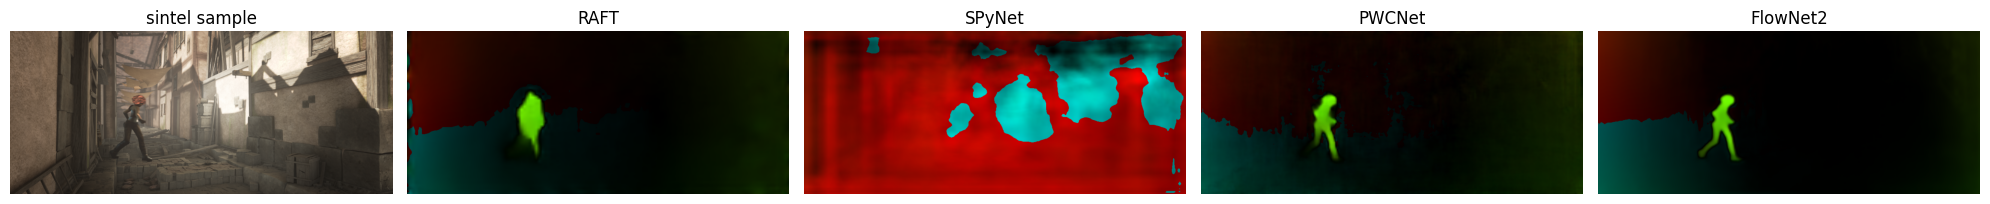

[get_model] RAFT weights: /content/RAFT/models/raft-small.pth  | small=True


2025-11-12 15:11:41.363 | INFO     | ptlflow:restore_model:283 - Restored model state from checkpoint: things
2025-11-12 15:11:45.002 | INFO     | ptlflow:restore_model:283 - Restored model state from checkpoint: things


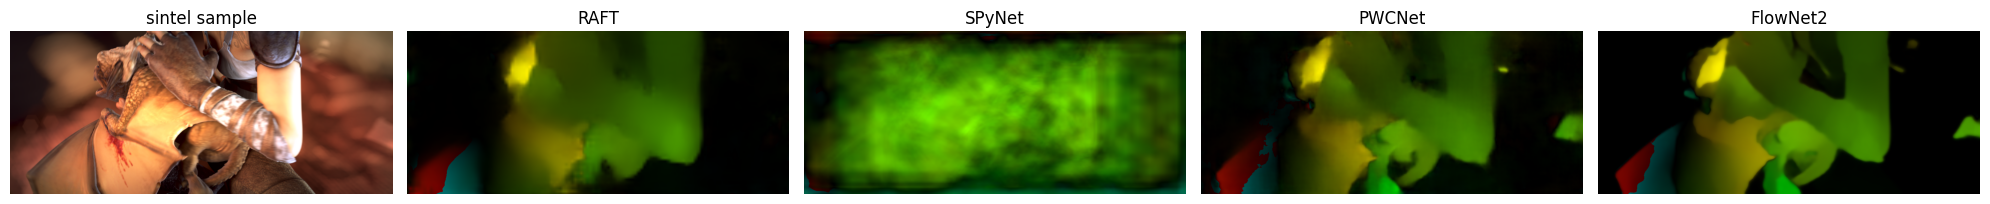

[get_model] RAFT weights: /content/RAFT/models/raft-small.pth  | small=True


2025-11-12 15:11:46.370 | INFO     | ptlflow:restore_model:283 - Restored model state from checkpoint: things
2025-11-12 15:11:50.820 | INFO     | ptlflow:restore_model:283 - Restored model state from checkpoint: things


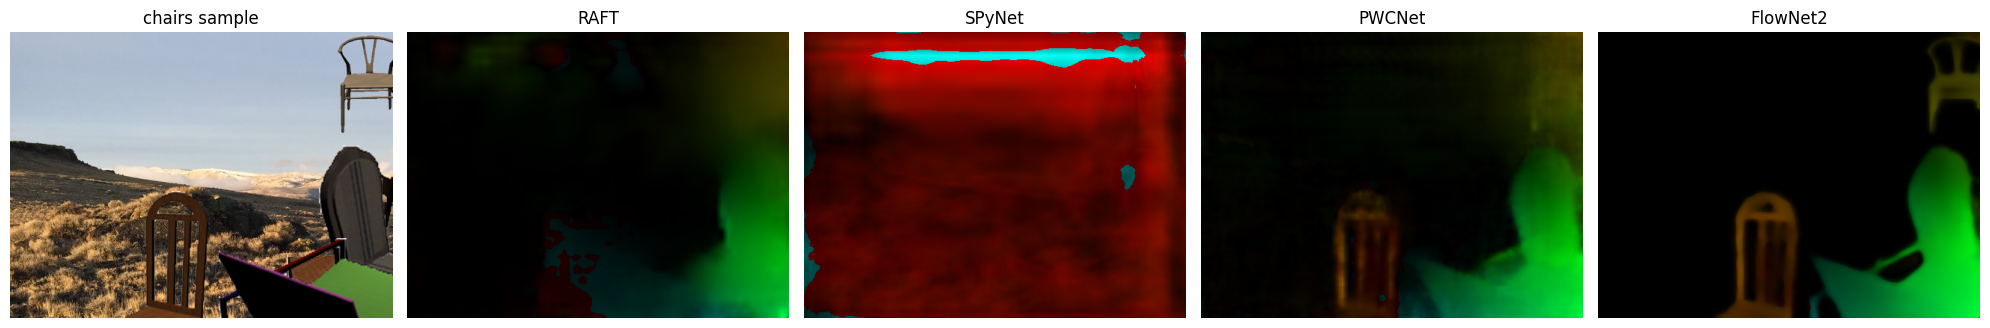

[get_model] RAFT weights: /content/RAFT/models/raft-small.pth  | small=True


2025-11-12 15:11:52.321 | INFO     | ptlflow:restore_model:283 - Restored model state from checkpoint: things
2025-11-12 15:11:56.150 | INFO     | ptlflow:restore_model:283 - Restored model state from checkpoint: things


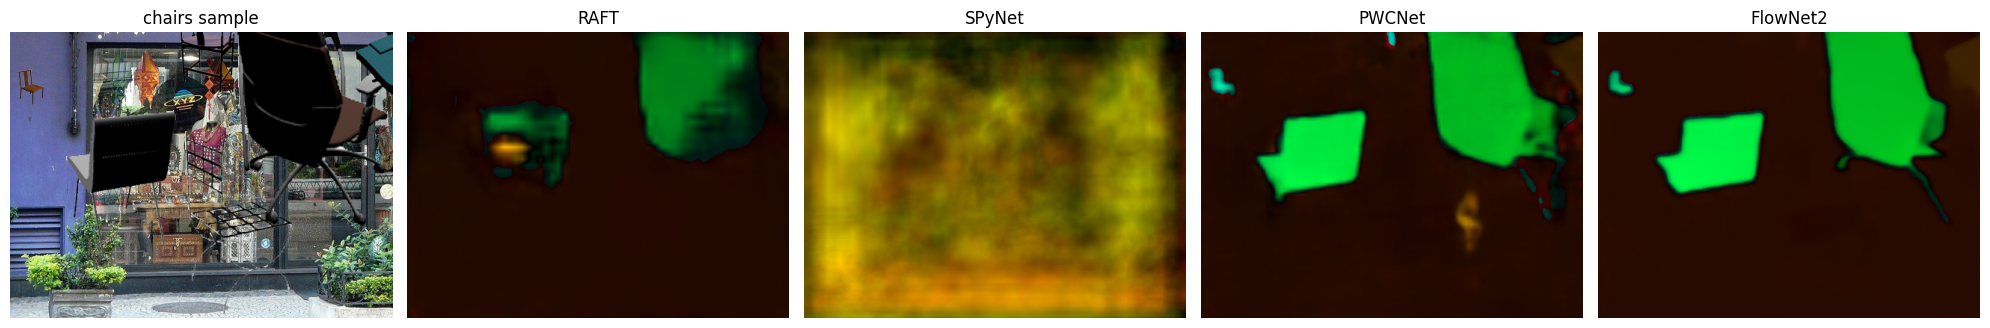

In [58]:
import random, cv2, numpy as np, matplotlib.pyplot as plt
from oflow2d.common.viz import flow_to_color

def show_examples(ds_name, root, model_names, k=2, **dkw):
    ds = get_dataset(ds_name, root, None, **dkw)
    idxs = random.sample(range(len(ds)), min(k, len(ds)))
    for i in idxs:
        img1,img2,flow_gt,valid,meta = ds[i]
        fig, axs = plt.subplots(1, 1+len(model_names), figsize=(4*(1+len(model_names)),4))
        axs[0].imshow(img1); axs[0].set_title(f"{ds_name} sample"); axs[0].axis("off")
        for j,mn in enumerate(model_names, start=1):
            m = get_model(mn)
            pred = _to_numpy_flow(m.infer(img1,img2)); pred = _match_size(pred, *flow_gt.shape[:2])
            axs[j].imshow(flow_to_color(pred)); axs[j].set_title(mn); axs[j].axis("off")
        plt.tight_layout(); plt.show()

# Esempi (Sintel + Chairs subset)
show_examples("sintel", SINTEL_ROOT, ["RAFT","SPyNet","PWCNet","FlowNet2"], k=2, pass_name="final")
show_examples("chairs", "/content/_chairs_subset", ["RAFT","SPyNet","PWCNet","FlowNet2"], k=2)


ROOT: cartella base dei dataset sul Drive (/content/drive/MyDrive/datasets).

SINTEL_ROOT: punta alla radice di MPI-Sintel-complete (dove ci sono training/final, training/clean, training/flow).

KITTI15_ROOT: radice di KITTI 2015 (optical flow); dentro dovresti avere training/image_2 e training/flow_occ (o flow_noc).

CHAIRS_ROOT: radice di FlyingChairs. C’è un autodetect: se trova la sottocartella FlyingChairs_release, usa quella (è la struttura giusta per i loader).

VKITTI_RGB / VKITTI_FLOW: radici di Virtual KITTI 2 per le immagini RGB e i flussi forwardFlow.

In [59]:
import os

# Path di base dal tuo Drive
ROOT = "/content/drive/MyDrive/datasets"

SINTEL_ROOT  = f"{ROOT}/MPI-Sintel-complete"       # (il loader userà .../training/...)
KITTI15_ROOT = f"{ROOT}/data_stereo_flow"
CHAIRS_ROOT  = f"{ROOT}/FlyingChairs"
VKITTI_RGB   = f"{ROOT}/vkitti_2.0.3_rgb"
VKITTI_FLOW  = f"{ROOT}/vkitti_2.0.3_forwardFlow"

# Autodetect per FlyingChairs: usa la sottocartella 'FlyingChairs_release' se presente
_fc_release = f"{CHAIRS_ROOT}/FlyingChairs_release"
if os.path.isdir(_fc_release):
    CHAIRS_ROOT = _fc_release

print("SINTEL_ROOT :", SINTEL_ROOT)
print("KITTI15_ROOT:", KITTI15_ROOT)
print("CHAIRS_ROOT :", CHAIRS_ROOT)
print("VKITTI_RGB  :", VKITTI_RGB)
print("VKITTI_FLOW :", VKITTI_FLOW)


SINTEL_ROOT : /content/drive/MyDrive/datasets/MPI-Sintel-complete
KITTI15_ROOT: /content/drive/MyDrive/datasets/data_stereo_flow
CHAIRS_ROOT : /content/drive/MyDrive/datasets/FlyingChairs/FlyingChairs_release
VKITTI_RGB  : /content/drive/MyDrive/datasets/vkitti_2.0.3_rgb
VKITTI_FLOW : /content/drive/MyDrive/datasets/vkitti_2.0.3_forwardFlow


In [60]:
import os, glob

def _ok(p): return "OK" if os.path.isdir(p) else "MANCANTE"
def _cnt(pat): return len(glob.glob(pat))

print("\n[SINTEL]")
print(" ", SINTEL_ROOT)
print(" ", "training/final   :", _ok(f"{SINTEL_ROOT}/training/final"))
print(" ", "training/clean   :", _ok(f"{SINTEL_ROOT}/training/clean"))
print(" ", "training/flow    :", _ok(f"{SINTEL_ROOT}/training/flow"))
print("   esempi final:", _cnt(f"{SINTEL_ROOT}/training/final/*/frame_0001.png"),
      "| flow:", _cnt(f"{SINTEL_ROOT}/training/flow/*/frame_0001.flo"))

print("\n[KITTI15]")
print(" ", KITTI15_ROOT)
print(" ", "training/image_2 :", _ok(f"{KITTI15_ROOT}/training/image_2"))
print(" ", "training/flow_occ:", _ok(f"{KITTI15_ROOT}/training/flow_occ"))
print(" ", "training/flow_noc:", _ok(f"{KITTI15_ROOT}/training/flow_noc"))
print("   _10.png in image_2:", _cnt(f"{KITTI15_ROOT}/training/image_2/*_10.png"))
print("   _10.png in flow_occ:", _cnt(f"{KITTI15_ROOT}/training/flow_occ/*_10.png"))

print("\n[FLYING CHAIRS]")
print(" ", CHAIRS_ROOT)
print(" ", "data/           :", _ok(f"{CHAIRS_ROOT}/data"))
print("   *_img1.ppm:", _cnt(f"{CHAIRS_ROOT}/data/*_img1.ppm"),
      "| *_flow.flo:", _cnt(f"{CHAIRS_ROOT}/data/*_flow.flo"))

print("\n[VIRTUAL KITTI 2]")
print(" ", "RGB root  :", VKITTI_RGB,  "-> esistono png?:", _cnt(f"{VKITTI_RGB}/**/*.png"))
print(" ", "FLOW root :", VKITTI_FLOW, "-> esistono flow?:", _cnt(f"{VKITTI_FLOW}/**/*.png"))


[SINTEL]
  /content/drive/MyDrive/datasets/MPI-Sintel-complete
  training/final   : OK
  training/clean   : OK
  training/flow    : OK
   esempi final: 23 | flow: 23

[KITTI15]
  /content/drive/MyDrive/datasets/data_stereo_flow
  training/image_2 : MANCANTE
  training/flow_occ: OK
  training/flow_noc: OK
   _10.png in image_2: 0
   _10.png in flow_occ: 194

[FLYING CHAIRS]
  /content/drive/MyDrive/datasets/FlyingChairs/FlyingChairs_release
  data/           : OK
   *_img1.ppm: 22872 | *_flow.flo: 22872

[VIRTUAL KITTI 2]
  RGB root  : /content/drive/MyDrive/datasets/vkitti_2.0.3_rgb -> esistono png?: 0
  FLOW root : /content/drive/MyDrive/datasets/vkitti_2.0.3_forwardFlow -> esistono flow?: 0


In [61]:
# FIX-K1: auto-discovery KITTI15/image_2 e set del root corretto
import os, glob

BASE = "/content/drive/MyDrive/datasets"

def find_kitti15_training(base=BASE):
    # 1) caso standard: data_stereo_flow/training/...
    cand = f"{base}/data_stereo_flow/training"
    if os.path.isdir(f"{cand}/image_2") and os.path.isdir(f"{cand}/flow_occ"):
        return cand

    # 2) cerca una cartella 'image_2' ovunque sotto BASE
    imgs = glob.glob(f"{base}/**/image_2/*_10.png", recursive=True)
    if imgs:
        # prendi la dir 'training' che contiene image_2
        image_2_dir = os.path.dirname(imgs[0])
        training_dir = os.path.dirname(image_2_dir)
        if os.path.isdir(f"{training_dir}/flow_occ") or os.path.isdir(f"{training_dir}/flow_noc"):
            return training_dir
        return training_dir  # almeno troviamo image_2: segnaleremo i flow

    return None

kitti_training = find_kitti15_training()
if kitti_training:
    print("✓ KITTI15 training:", kitti_training)
    print("  image_2 :", os.path.isdir(f"{kitti_training}/image_2"))
    print("  flow_occ:", os.path.isdir(f"{kitti_training}/flow_occ"))
    print("  flow_noc:", os.path.isdir(f"{kitti_training}/flow_noc"))
    # aggiorna la tua variabile globale se vuoi:
    KITTI15_ROOT = os.path.dirname(kitti_training) if os.path.basename(kitti_training)!="training" else os.path.dirname(kitti_training)
else:
    print("⚠️ Non trovo 'training/image_2' in KITTI15. Devi aggiungere il pacchetto RGB di KITTI 2015")
    print("   (mettilo in: /content/drive/MyDrive/datasets/data_stereo_flow/training/image_2/)")


✓ KITTI15 training: /content/drive/MyDrive/datasets/data_scene_flow/testing
  image_2 : True
  flow_occ: False
  flow_noc: False


In [62]:
# FIX-V1: discovery di vkitti_2.0.3_rgb e vkitti_2.0.3_forwardFlow con path “veri”
import os, glob

BASE = "/content/drive/MyDrive/datasets"

def find_many_png_dir(root, must_contain=None):
    # restituisce una dir che contiene tanti .png, eventualmente con 'rgb'/'forwardFlow' nel path
    cands = []
    for d in glob.glob(f"{root}/**/", recursive=True):
        if must_contain and must_contain not in d:
            continue
        n = len(glob.glob(f"{d}/*.png"))
        if n >= 50:  # soglia minima per evitare false hit
            cands.append((n, d))
    cands.sort(reverse=True)
    return cands[0][1] if cands else None

vk_rgb_guess  = find_many_png_dir(f"{BASE}/vkitti_2.0.3_rgb", must_contain=None)
vk_flow_guess = find_many_png_dir(f"{BASE}/vkitti_2.0.3_forwardFlow", must_contain=None)

print("VKITTI2 rgb  guess:", vk_rgb_guess or "NESSUN PNG TROVATO")
print("VKITTI2 flow guess:", vk_flow_guess or "NESSUN PNG TROVATO")

# Se trovati, aggiorna le variabili usate nel loader
if vk_rgb_guess and vk_flow_guess:
    VKITTI_RGB  = vk_rgb_guess
    VKITTI_FLOW = vk_flow_guess
    print("✓ Impostati VKITTI_RGB / VKITTI_FLOW a:", VKITTI_RGB, "|", VKITTI_FLOW)
else:
    print("ℹ️ Se rimane NESSUN PNG TROVATO:")
    print("   - i dataset possono essere ancora in .zip/.tar.gz → estraili (vedi FIX-UNPACK)")
    print("   - oppure i root puntano alla cartella sbagliata; apri la struttura e prendi la sottocartella con i .png")


VKITTI2 rgb  guess: NESSUN PNG TROVATO
VKITTI2 flow guess: /content/drive/MyDrive/datasets/vkitti_2.0.3_forwardFlow/Scene20/overcast/frames/forwardFlow/Camera_0/
ℹ️ Se rimane NESSUN PNG TROVATO:
   - i dataset possono essere ancora in .zip/.tar.gz → estraili (vedi FIX-UNPACK)
   - oppure i root puntano alla cartella sbagliata; apri la struttura e prendi la sottocartella con i .png


ora nella eval sopra va anche kitti15

In [63]:
# FIX-UNPACK: cerca archivi dentro le cartelle dataset e li estrae accanto
import os, glob, shutil

def unpack_archives(root):
    archives = glob.glob(f"{root}/**/*.zip", recursive=True) + \
               glob.glob(f"{root}/**/*.tar.gz", recursive=True) + \
               glob.glob(f"{root}/**/*.tgz", recursive=True) + \
               glob.glob(f"{root}/**/*.tar", recursive=True)
    if not archives:
        print(f"(nessun archivio in {root})")
        return
    for a in archives:
        out_dir = os.path.splitext(a)[0].replace(".tar", "")
        try:
            print("↗︎ estraggo:", a, "→", out_dir)
            os.makedirs(out_dir, exist_ok=True)
            shutil.unpack_archive(a, out_dir)
        except Exception as e:
            print("   ⚠️ errore:", type(e).__name__, e)

# Esempi (lanciali solo se i contatori PNG sono 0)
unpack_archives("/content/drive/MyDrive/datasets/vkitti_2.0.3_rgb")
unpack_archives("/content/drive/MyDrive/datasets/vkitti_2.0.3_forwardFlow")
unpack_archives("/content/drive/MyDrive/datasets/data_stereo_flow")


(nessun archivio in /content/drive/MyDrive/datasets/vkitti_2.0.3_rgb)
(nessun archivio in /content/drive/MyDrive/datasets/vkitti_2.0.3_forwardFlow)
(nessun archivio in /content/drive/MyDrive/datasets/data_stereo_flow)


In [64]:
# FIX-SKIP: helper per saltare dataset non completi (KITTI senza image_2, VKITTI2 senza png)
import os, glob

def has_sintel(root):  return os.path.isdir(f"{root}/training/final") and os.path.isdir(f"{root}/training/flow")
def has_chairs(root):  return os.path.isdir(f"{root}/data") and glob.glob(f"{root}/data/*_img1.ppm")
def has_kitti(root):   return os.path.isdir(f"{root}/training/image_2") and os.path.isdir(f"{root}/training/flow_occ")
def has_vkitti(rgb,flow): return glob.glob(f"{rgb}/**/*.png", recursive=True) and glob.glob(f"{flow}/**/*.png", recursive=True)

# Esempio di uso prima della EVAL-ALL FAST:
print("Sintel  OK?" , bool(has_sintel(SINTEL_ROOT)))
print("Chairs  OK?" , bool(has_chairs(CHAIRS_ROOT)))
print("KITTI15 OK?" , bool(has_kitti(KITTI15_ROOT)))
print("VKITTI2 OK?", bool(has_vkitti(VKITTI_RGB, VKITTI_FLOW)))


Sintel  OK? True
Chairs  OK? True
KITTI15 OK? True
VKITTI2 OK? False


In [65]:
# VK-FIX-1: reader del forwardFlow invariato (PNG16 stile KITTI o float)
import numpy as np, cv2

def read_vkitti2_flow(path: str):
    im = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    if im is None:
        raise FileNotFoundError(path)
    if im.ndim == 3 and im.shape[2] == 3 and im.dtype == np.uint16:
        B = im[...,0].astype(np.float32); G = im[...,1].astype(np.float32); R = im[...,2].astype(np.float32)
        valid = B > 0
        u = (R - 2**15) / 64.0
        v = (G - 2**15) / 64.0
        return np.dstack([u, v]).astype(np.float32), valid
    if im.dtype in (np.float32, np.float64) and im.ndim == 3 and im.shape[2] >= 2:
        flow = im[..., :2].astype(np.float32)
        valid = np.ones(flow.shape[:2], bool)
        return flow, valid
    if im.ndim == 3 and im.shape[2] == 2 and im.dtype == np.uint16:
        u = (im[...,0].astype(np.float32) - 2**15) / 64.0
        v = (im[...,1].astype(np.float32) - 2**15) / 64.0
        return np.dstack([u, v]).astype(np.float32), np.ones(im.shape[:2], bool)
    raise ValueError(f"Formato VKITTI2 non riconosciuto: {im.shape}, {im.dtype}")


In [66]:
# VK-FIX-2: dataset VKITTI2 che supporta RGB .jpg/.jpeg/.png
import os, glob, cv2

class VirtualKitti2:
    """
    root_rgb  := .../vkitti_2.0.3_rgb
    root_flow := .../vkitti_2.0.3_forwardFlow
    Abbina (img_t, img_{t+1}, forwardFlow_t).
    """
    def __init__(self, root_rgb: str, root_flow: str, subset_list: str = None):
        self.root_rgb  = root_rgb
        self.root_flow = root_flow

        # prendi qualunque jpg/png come RGB
        exts = ("*.jpg","*.jpeg","*.png")
        rgb_files = []
        for ext in exts:
            rgb_files += glob.glob(os.path.join(root_rgb, "**", ext), recursive=True)

        # raggruppa per sequenza (cartella)
        seq_map = {}
        for p in rgb_files:
            seq_map.setdefault(os.path.dirname(p), []).append(p)

        self.samples = []
        for seq, frames in seq_map.items():
            frames = sorted(frames)
            for i in range(len(frames)-1):
                img1, img2 = frames[i], frames[i+1]
                # mappa RGB -> forwardFlow mantenendo il relativo
                rel = os.path.relpath(img1, root_rgb)
                flow = os.path.join(root_flow, rel)
                flow = flow.replace("/frames/rgb/", "/frames/forwardFlow/")
                flow = os.path.splitext(flow)[0] + ".png"  # forwardFlow è .png
                if os.path.exists(flow):
                    self.samples.append((img1, img2, flow))

    def __len__(self): return len(self.samples)

    def __getitem__(self, idx: int):
        i1, i2, ff = self.samples[idx]
        img1 = cv2.cvtColor(cv2.imread(i1), cv2.COLOR_BGR2RGB)
        img2 = cv2.cvtColor(cv2.imread(i2), cv2.COLOR_BGR2RGB)
        flow, valid = read_vkitti2_flow(ff)
        return img1, img2, flow, valid, {"img1": i1, "img2": i2, "flow": ff}


In [67]:
# VK-FIX-4: trova un path valido che contenga molti jpg/png in vkitti_2.0.3_rgb
import glob, os

BASE = "/content/drive/MyDrive/datasets"

def find_rgb_dir(base):
    cands = glob.glob(f"{base}/vkitti_2.0.3_rgb/**/", recursive=True)
    best = None; best_n = -1
    for d in cands:
        n = len(glob.glob(f"{d}/*.jpg")) + len(glob.glob(f"{d}/*.png")) + len(glob.glob(f"{d}/*.jpeg"))
        if n > best_n:
            best, best_n = d, n
    return best, best_n

VKITTI_RGB, n_rgb = find_rgb_dir(BASE)
print("VKITTI_RGB:", VKITTI_RGB, "| immagini:", n_rgb)

# forwardFlow già te lo trovava; se vuoi correggerlo comunque:
def find_flow_dir(base):
    cands = glob.glob(f"{base}/vkitti_2.0.3_forwardFlow/**/", recursive=True)
    best = None; best_n = -1
    for d in cands:
        n = len(glob.glob(f"{d}/*.png"))
        if n > best_n:
            best, best_n = d, n
    return best, best_n

VKITTI_FLOW, n_flow = find_flow_dir(BASE)
print("VKITTI_FLOW:", VKITTI_FLOW, "| flow png:", n_flow)


VKITTI_RGB: /content/drive/MyDrive/datasets/vkitti_2.0.3_rgb/Scene20/15-deg-left/frames/rgb/Camera_0/ | immagini: 837
VKITTI_FLOW: /content/drive/MyDrive/datasets/vkitti_2.0.3_forwardFlow/Scene20/overcast/frames/forwardFlow/Camera_0/ | flow png: 837


In [73]:
import os, glob

def _cnt_rgb(root):
    return (
        len(glob.glob(f"{root}/**/*.jpg",  recursive=True)) +
        len(glob.glob(f"{root}/**/*.jpeg", recursive=True)) +
        len(glob.glob(f"{root}/**/*.png",  recursive=True))
    )

def _cnt_flow(root):
    return len(glob.glob(f"{root}/**/*.png", recursive=True))

has_vk2 = (
    bool(VKITTI_RGB) and bool(VKITTI_FLOW) and
    (_cnt_rgb(VKITTI_RGB)  > 0) and
    (_cnt_flow(VKITTI_FLOW) > 0)
)

if has_vk2:
    print("✓ Virtual KITTI 2 trovato: run FAST (max 400)")
    for m in ["RAFT","SPyNet","PWCNet","FlowNet2"]:
        res = run_batch_eval(
            model_name=m, dataset_name="vkitti2", root=".",
            rgb_root=VKITTI_RGB, flow_root=VKITTI_FLOW,
            max_items=400, shuffle=True
        )
        pretty_print_results(f"{m} @ VKITTI2 (400)", res)
else:
    print("ℹ️ VKITTI2 non completo (RGB/flow non trovati): salto.")


✓ Virtual KITTI 2 trovato: run FAST (max 400)
[VKITTI2] RGB  files: 837 in /content/drive/MyDrive/datasets/vkitti_2.0.3_rgb/Scene20/overcast/frames/rgb/Camera_0
  es: ['rgb_00000.jpg', 'rgb_00001.jpg', 'rgb_00002.jpg']
[VKITTI2] FLOW files: 837 in /content/drive/MyDrive/datasets/vkitti_2.0.3_forwardFlow/Scene20/overcast/frames/forwardFlow/Camera_0
  es: ['flow_00000.png', 'flow_00001.png', 'flow_00002.png']
[VKITTI2] coppie pronte: 836  (flow mancanti su 0 transizioni)
  es. coppie: [('rgb_00000.jpg', 'rgb_00001.jpg', 'flow_00000.png'), ('rgb_00001.jpg', 'rgb_00002.jpg', 'flow_00001.png'), ('rgb_00002.jpg', 'rgb_00003.jpg', 'flow_00002.png')]
[get_model] RAFT weights: /content/RAFT/models/raft-small.pth  | small=True


=== RAFT @ VKITTI2 (400) ===
             EPE: 15.28706426113844
        Fl-all_%: 74.19439731939845
AngularError_deg: 34.26217579841614
      FPS_median: 14.518161097030166
               N: 400
[VKITTI2] RGB  files: 837 in /content/drive/MyDrive/datasets/vkitti_2.0.3_rgb/Scene20/overcast/frames/rgb/Camera_0
  es: ['rgb_00000.jpg', 'rgb_00001.jpg', 'rgb_00002.jpg']
[VKITTI2] FLOW files: 837 in /content/drive/MyDrive/datasets/vkitti_2.0.3_forwardFlow/Scene20/overcast/frames/forwardFlow/Camera_0
  es: ['flow_00000.png', 'flow_00001.png', 'flow_00002.png']
[VKITTI2] coppie pronte: 836  (flow mancanti su 0 transizioni)
  es. coppie: [('rgb_00000.jpg', 'rgb_00001.jpg', 'flow_00000.png'), ('rgb_00001.jpg', 'rgb_00002.jpg', 'flow_00001.png'), ('rgb_00002.jpg', 'rgb_00003.jpg', 'flow_00002.png')]


=== SPyNet @ VKITTI2 (400) ===
             EPE: 16.41228642486036
        Fl-all_%: 72.68947146815286
AngularError_deg: 83.66592811107635
      FPS_median: 13.312675565000873
               N: 400
[VKITTI2] RGB  files: 837 in /content/drive/MyDrive/datasets/vkitti_2.0.3_rgb/Scene20/overcast/frames/rgb/Camera_0
  es: ['rgb_00000.jpg', 'rgb_00001.jpg', 'rgb_00002.jpg']
[VKITTI2] FLOW files: 837 in /content/drive/MyDrive/datasets/vkitti_2.0.3_forwardFlow/Scene20/overcast/frames/forwardFlow/Camera_0
  es: ['flow_00000.png', 'flow_00001.png', 'flow_00002.png']
[VKITTI2] coppie pronte: 836  (flow mancanti su 0 transizioni)
  es. coppie: [('rgb_00000.jpg', 'rgb_00001.jpg', 'flow_00000.png'), ('rgb_00001.jpg', 'rgb_00002.jpg', 'flow_00001.png'), ('rgb_00002.jpg', 'rgb_00003.jpg', 'flow_00002.png')]


2025-11-12 15:36:46.495 | INFO     | ptlflow:restore_model:283 - Restored model state from checkpoint: things


=== PWCNet @ VKITTI2 (400) ===
             EPE: 15.196721744537353
        Fl-all_%: 74.07896139164227
AngularError_deg: 27.44800454854965
      FPS_median: 10.621072485247264
               N: 400
[VKITTI2] RGB  files: 837 in /content/drive/MyDrive/datasets/vkitti_2.0.3_rgb/Scene20/overcast/frames/rgb/Camera_0
  es: ['rgb_00000.jpg', 'rgb_00001.jpg', 'rgb_00002.jpg']
[VKITTI2] FLOW files: 837 in /content/drive/MyDrive/datasets/vkitti_2.0.3_forwardFlow/Scene20/overcast/frames/forwardFlow/Camera_0
  es: ['flow_00000.png', 'flow_00001.png', 'flow_00002.png']
[VKITTI2] coppie pronte: 836  (flow mancanti su 0 transizioni)
  es. coppie: [('rgb_00000.jpg', 'rgb_00001.jpg', 'flow_00000.png'), ('rgb_00001.jpg', 'rgb_00002.jpg', 'flow_00001.png'), ('rgb_00002.jpg', 'rgb_00003.jpg', 'flow_00002.png')]


2025-11-12 15:39:36.326 | INFO     | ptlflow:restore_model:283 - Restored model state from checkpoint: things
                                                                   

=== FlowNet2 @ VKITTI2 (400) ===
             EPE: 15.209330763909966
        Fl-all_%: 74.36531257962639
AngularError_deg: 26.474411491155625
      FPS_median: 4.522363122344414
               N: 400


In [69]:
# === VKITTI2: reader + dataset + get_dataset (drop-in) ===
import os, glob, cv2, numpy as np

def read_vkitti2_flow(path: str):
    im = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    if im is None:
        raise FileNotFoundError(path)
    # PNG 16-bit 3 canali stile KITTI (B=valid, R->u, G->v)
    if im.ndim == 3 and im.shape[2] == 3 and im.dtype == np.uint16:
        B = im[...,0].astype(np.float32)
        G = im[...,1].astype(np.float32)
        R = im[...,2].astype(np.float32)
        valid = B > 0
        u = (R - 2**15) / 64.0
        v = (G - 2**15) / 64.0
        return np.dstack([u, v]).astype(np.float32), valid
    # EXR/PNG float con almeno 2 canali
    if im.dtype in (np.float32, np.float64) and im.ndim == 3 and im.shape[2] >= 2:
        flow = im[..., :2].astype(np.float32)
        valid = np.ones(flow.shape[:2], bool)
        return flow, valid
    # PNG 16-bit 2 canali (raro)
    if im.ndim == 3 and im.shape[2] == 2 and im.dtype == np.uint16:
        u = (im[...,0].astype(np.float32) - 2**15) / 64.0
        v = (im[...,1].astype(np.float32) - 2**15) / 64.0
        return np.dstack([u, v]).astype(np.float32), np.ones(im.shape[:2], bool)
    raise ValueError(f"Formato VKITTI2 non riconosciuto: {im.shape}, {im.dtype}")

class VirtualKitti2:
    """
    root_rgb  := .../vkitti_2.0.3_rgb
    root_flow := .../vkitti_2.0.3_forwardFlow
    Abbina (img_t, img_{t+1}, forwardFlow_t).
    Supporta RGB .jpg/.jpeg/.png; il flow è .png (forwardFlow).
    """
    def __init__(self, root_rgb: str, root_flow: str, subset_list: str = None):
        assert root_rgb and root_flow, "Serve rgb_root e flow_root per vkitti2"
        self.root_rgb, self.root_flow = root_rgb, root_flow

        exts = ("*.jpg","*.jpeg","*.png")
        rgb_files = []
        for ext in exts:
            rgb_files += glob.glob(os.path.join(root_rgb, "**", ext), recursive=True)

        seq_map = {}
        for p in rgb_files:
            seq_map.setdefault(os.path.dirname(p), []).append(p)

        self.samples = []
        for seq, frames in seq_map.items():
            frames = sorted(frames)
            for i in range(len(frames)-1):
                img1, img2 = frames[i], frames[i+1]
                # mappa percorso RGB -> forwardFlow corrispondente
                rel = os.path.relpath(img1, root_rgb)
                flow = os.path.join(root_flow, rel)
                flow = flow.replace("/frames/rgb/", "/frames/forwardFlow/")
                flow = os.path.splitext(flow)[0] + ".png"
                if os.path.exists(flow):
                    self.samples.append((img1, img2, flow))

    def __len__(self): return len(self.samples)

    def __getitem__(self, idx: int):
        i1, i2, ff = self.samples[idx]
        img1 = cv2.cvtColor(cv2.imread(i1), cv2.COLOR_BGR2RGB)
        img2 = cv2.cvtColor(cv2.imread(i2), cv2.COLOR_BGR2RGB)
        flow, valid = read_vkitti2_flow(ff)
        return img1, img2, flow, valid, {"img1": i1, "img2": i2, "flow": ff}

# --- RIDEFINIZIONE get_dataset: aggiunge 'vkitti2' ---
def get_dataset(name: str, root: str, subset: str = None, **dkw):
    n = (name or "").strip().lower()
    if n == "sintel":
        # richiede che MPISintel sia già definito
        return MPISintel(root, pass_name=dkw.get("pass_name", "final"), subset_list=subset)
    if n in ("chairs","flyingchairs"):
        return FlyingChairs(root, subset_list=subset)
    if n in ("kitti","kitti15"):
        return KITTI15(root, flow_subdir=dkw.get("flow_subdir", "flow_occ"), subset_list=subset)
    if n in ("vkitti2","virtualkitti2","vkitti"):
        rgb_root  = dkw.get("rgb_root")
        flow_root = dkw.get("flow_root")
        return VirtualKitti2(rgb_root, flow_root, subset_list=subset)
    raise ValueError(f"Dataset non supportato: {name}")

print("✅ VKITTI2 patch attivata (reader + dataset + get_dataset).")


✅ VKITTI2 patch attivata (reader + dataset + get_dataset).


In [70]:
# === VKITTI2: FIX scanner immagini (supporta root=.../Camera_0 o root=.../vkitti_2.0.3_rgb) ===
import os, glob, cv2, numpy as np

def _list_media(root: str, exts=("jpg","jpeg","png")):
    files = []
    # livello corrente
    for e in exts:
        files += glob.glob(os.path.join(root, f"*.{e}"))
    # ricorsivo
    for e in exts:
        files += glob.glob(os.path.join(root, f"**/*.{e}"), recursive=True)
    # de-dup + sort
    files = sorted(set(files))
    return files

def read_vkitti2_flow(path: str):
    im = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    if im is None:
        raise FileNotFoundError(path)
    if im.ndim == 3 and im.shape[2] == 3 and im.dtype == np.uint16:  # stile KITTI 16-bit PNG
        B = im[...,0].astype(np.float32); G = im[...,1].astype(np.float32); R = im[...,2].astype(np.float32)
        valid = B > 0
        u = (R - 2**15) / 64.0
        v = (G - 2**15) / 64.0
        return np.dstack([u, v]).astype(np.float32), valid
    if im.dtype in (np.float32, np.float64) and im.ndim == 3 and im.shape[2] >= 2:  # EXR/float
        flow = im[..., :2].astype(np.float32)
        return flow, np.ones(flow.shape[:2], bool)
    if im.ndim == 3 and im.shape[2] == 2 and im.dtype == np.uint16:
        u = (im[...,0].astype(np.float32) - 2**15) / 64.0
        v = (im[...,1].astype(np.float32) - 2**15) / 64.0
        return np.dstack([u, v]).astype(np.float32), np.ones(im.shape[:2], bool)
    raise ValueError(f"Formato VKITTI2 non riconosciuto: {im.shape}, {im.dtype}")

class VirtualKitti2:
    """
    root_rgb  := cartella con i frame RGB (può essere anche .../Camera_0)
    root_flow := cartella con i forwardFlow corrispondenti (può essere .../Camera_0)
    """
    def __init__(self, root_rgb: str, root_flow: str, subset_list: str = None):
        assert root_rgb and root_flow, "Serve rgb_root e flow_root per vkitti2"
        self.root_rgb, self.root_flow = root_rgb, root_flow

        rgb_files = _list_media(root_rgb, exts=("jpg","jpeg","png"))
        # DEBUG: mostra qualche match per capire il path
        print(f"[VKITTI2] trovate {len(rgb_files)} immagini in {root_rgb}")
        for p in rgb_files[:3]:
            print("   img:", os.path.relpath(p, root_rgb))

        # raggruppa per cartella (sequenza)
        seq_map = {}
        for p in rgb_files:
            seq_map.setdefault(os.path.dirname(p), []).append(p)

        self.samples = []
        miss = 0
        for seq, frames in seq_map.items():
            frames = sorted(frames)
            for i in range(len(frames)-1):
                img1, img2 = frames[i], frames[i+1]
                # mappa RGB -> forwardFlow con stessa basename .png
                rel1  = os.path.relpath(img1, root_rgb)         # es. "00001.jpg" oppure "frames/rgb/Camera_0/00001.jpg"
                base  = os.path.splitext(rel1)[0] + ".png"      # 00001.png
                flow1 = os.path.join(root_flow, base)           # se root_flow = .../Camera_0 -> .../Camera_0/00001.png
                # se stai passando root_rgb/flow in cartelle "frames/rgb"/"frames/forwardFlow", prova anche il replace:
                if not os.path.exists(flow1):
                    alt = os.path.join(root_flow, rel1).replace("/frames/rgb/", "/frames/forwardFlow/")
                    flow1 = os.path.splitext(alt)[0] + ".png"
                if os.path.exists(flow1):
                    self.samples.append((img1, img2, flow1))
                else:
                    miss += 1

        print(f"[VKITTI2] coppie pronte: {len(self.samples)} (flow mancanti su {miss} transizioni)")

    def __len__(self): return len(self.samples)

    def __getitem__(self, idx: int):
        i1, i2, ff = self.samples[idx]
        img1 = cv2.cvtColor(cv2.imread(i1), cv2.COLOR_BGR2RGB)
        img2 = cv2.cvtColor(cv2.imread(i2), cv2.COLOR_BGR2RGB)
        flow, valid = read_vkitti2_flow(ff)
        return img1, img2, flow, valid, {"img1": i1, "img2": i2, "flow": ff}

# rebind get_dataset se serve (aggiunge il ramo vkitti2 mantenendo gli altri invariati)
def get_dataset(name: str, root: str, subset: str = None, **dkw):
    n = (name or "").strip().lower()
    if n == "sintel":
        return MPISintel(root, pass_name=dkw.get("pass_name","final"), subset_list=subset)
    if n in ("chairs","flyingchairs"):
        return FlyingChairs(root, subset_list=subset)
    if n in ("kitti","kitti15"):
        return KITTI15(root, flow_subdir=dkw.get("flow_subdir","flow_occ"), subset_list=subset)
    if n in ("vkitti2","virtualkitti2","vkitti"):
        return VirtualKitti2(dkw["rgb_root"], dkw["flow_root"], subset_list=subset)
    raise ValueError(f"Dataset non supportato: {name}")


In [71]:
# === VKITTI2 robust loader: match per suffisso numerico + fallback ±1 ===
import os, re, glob, cv2, numpy as np

def _list_media(root: str, exts=("jpg","jpeg","png")):
    files = []
    for e in exts:
        files += glob.glob(os.path.join(root, f"*.{e}"))
    for e in exts:
        files += glob.glob(os.path.join(root, f"**/*.{e}"), recursive=True)
    return sorted(set(files))

def read_vkitti2_flow(path: str):
    im = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    if im is None:
        raise FileNotFoundError(path)
    if im.ndim == 3 and im.shape[2] == 3 and im.dtype == np.uint16:
        B = im[...,0].astype(np.float32); G = im[...,1].astype(np.float32); R = im[...,2].astype(np.float32)
        valid = B > 0
        u = (R - 2**15) / 64.0; v = (G - 2**15) / 64.0
        return np.dstack([u, v]).astype(np.float32), valid
    if im.dtype in (np.float32, np.float64) and im.ndim == 3 and im.shape[2] >= 2:
        flow = im[...,:2].astype(np.float32)
        return flow, np.ones(flow.shape[:2], bool)
    if im.ndim == 3 and im.shape[2] == 2 and im.dtype == np.uint16:
        u = (im[...,0].astype(np.float32) - 2**15)/64.0
        v = (im[...,1].astype(np.float32) - 2**15)/64.0
        return np.dstack([u, v]).astype(np.float32), np.ones(im.shape[:2], bool)
    raise ValueError(f"Formato VKITTI2 non riconosciuto: {im.shape}, {im.dtype}")

def _bn(p):  # basename senza estensione
    return os.path.splitext(os.path.basename(p))[0]

def _num_suffix(bn):  # 'rgb_00088' -> '00088' (o None se non c'è numero finale)
    m = re.search(r'(\d+)$', bn)
    return m.group(1) if m else None

class VirtualKitti2:
    """
    root_rgb  := cartella con i frame RGB (anche .../Camera_0)
    root_flow := cartella con i forwardFlow (anche .../Camera_0)
    Matching per suffisso numerico: 'rgb_00000' -> 'flow_00000' (+ fallback ±1).
    """
    def __init__(self, root_rgb: str, root_flow: str, subset_list: str = None):
        assert root_rgb and root_flow, "Serve rgb_root e flow_root per vkitti2"
        self.root_rgb, self.root_flow = root_rgb, root_flow

        rgb_files  = _list_media(root_rgb,  exts=("jpg","jpeg","png"))
        flow_files = _list_media(root_flow, exts=("png",))

        print(f"[VKITTI2] RGB  files: {len(rgb_files)} in {root_rgb}")
        print("  es:", [os.path.relpath(p, root_rgb) for p in rgb_files[:3]])
        print(f"[VKITTI2] FLOW files: {len(flow_files)} in {root_flow}")
        print("  es:", [os.path.relpath(p, root_flow) for p in flow_files[:3]])

        # indicizza flow per: basename esatto, e per suffisso numerico
        flow_by_bn   = { _bn(p): p for p in flow_files }
        flow_by_suf  = {}
        for p in flow_files:
            s = _num_suffix(_bn(p))
            if s is not None:
                flow_by_suf[s] = p

        self.samples = []
        miss = 0

        for i in range(len(rgb_files)-1):
            img1, img2 = rgb_files[i], rgb_files[i+1]
            bn = _bn(img1)
            suf = _num_suffix(bn)
            ff = None

            # 1) stesso basename (rarissimo qui, ma tentiamo)
            ff = flow_by_bn.get(bn)

            # 2) stesso suffisso numerico: 'rgb_00088' -> 'flow_00088'
            if ff is None and suf is not None:
                ff = flow_by_suf.get(suf)

            # 3) fallback ±1 se numerico (per possibili off-by-one)
            if ff is None and suf is not None:
                try:
                    n = int(suf)
                    for d in (0, -1, +1):
                        k = f"{n+d:0{len(suf)}d}"
                        if k in flow_by_suf:
                            ff = flow_by_suf[k]; break
                except ValueError:
                    pass

            if ff is not None:
                self.samples.append((img1, img2, ff))
            else:
                miss += 1

        print(f"[VKITTI2] coppie pronte: {len(self.samples)}  (flow mancanti su {miss} transizioni)")
        if self.samples[:3]:
            print("  es. coppie:", [(
                os.path.basename(a), os.path.basename(b), os.path.basename(f)
            ) for (a,b,f) in self.samples[:3]])

    def __len__(self): return len(self.samples)
    def __getitem__(self, idx: int):
        i1, i2, ff = self.samples[idx]
        img1 = cv2.cvtColor(cv2.imread(i1), cv2.COLOR_BGR2RGB)
        img2 = cv2.cvtColor(cv2.imread(i2), cv2.COLOR_BGR2RGB)
        flow, valid = read_vkitti2_flow(ff)
        return img1, img2, flow, valid, {"img1": i1, "img2": i2, "flow": ff}

# Re-bind di get_dataset con il ramo vkitti2 (gli altri rimangono identici)
def get_dataset(name: str, root: str, subset: str = None, **dkw):
    n = (name or "").strip().lower()
    if n == "sintel":
        return MPISintel(root, pass_name=dkw.get("pass_name","final"), subset_list=subset)
    if n in ("chairs","flyingchairs"):
        return FlyingChairs(root, subset_list=subset)
    if n in ("kitti","kitti15"):
        return KITTI15(root, flow_subdir=dkw.get("flow_subdir","flow_occ"), subset_list=subset)
    if n in ("vkitti2","virtualkitti2","vkitti"):
        return VirtualKitti2(dkw["rgb_root"], dkw["flow_root"], subset_list=subset)
    raise ValueError(f"Dataset non supportato: {name}")


In [72]:
VKITTI_RGB  = "/content/drive/MyDrive/datasets/vkitti_2.0.3_rgb/Scene20/overcast/frames/rgb/Camera_0"
VKITTI_FLOW = "/content/drive/MyDrive/datasets/vkitti_2.0.3_forwardFlow/Scene20/overcast/frames/forwardFlow/Camera_0"

vk = get_dataset("vkitti2", root=".", rgb_root=VKITTI_RGB, flow_root=VKITTI_FLOW)
print("VKITTI2 samples:", len(vk))
img1,img2,flow,valid,meta = vk[0]
print(img1.shape, img2.shape, flow.shape, valid.shape, "OK")


[VKITTI2] RGB  files: 837 in /content/drive/MyDrive/datasets/vkitti_2.0.3_rgb/Scene20/overcast/frames/rgb/Camera_0
  es: ['rgb_00000.jpg', 'rgb_00001.jpg', 'rgb_00002.jpg']
[VKITTI2] FLOW files: 837 in /content/drive/MyDrive/datasets/vkitti_2.0.3_forwardFlow/Scene20/overcast/frames/forwardFlow/Camera_0
  es: ['flow_00000.png', 'flow_00001.png', 'flow_00002.png']
[VKITTI2] coppie pronte: 836  (flow mancanti su 0 transizioni)
  es. coppie: [('rgb_00000.jpg', 'rgb_00001.jpg', 'flow_00000.png'), ('rgb_00001.jpg', 'rgb_00002.jpg', 'flow_00001.png'), ('rgb_00002.jpg', 'rgb_00003.jpg', 'flow_00002.png')]
VKITTI2 samples: 836
(375, 1242, 3) (375, 1242, 3) (375, 1242, 2) (375, 1242) OK


dopo tutte queste vkitti funziona

kitti15 già funziona questo solo in caso non andasse


kitti15


In [ ]:
# FIX-KITTI15 — auto-discovery + merge root (image_2 + flow_occ/noc)
import os, glob, shutil
from pathlib import Path

# 🔧 adatta SOLO questo se il tuo Drive è altrove:
BASES = [
    "/content/drive/MyDrive/datasets",
]

def _count(patt): return len(glob.glob(patt))

def _find_training_image2(base):
    # prova percorso classico
    p = Path(base) / "data_scene_flow" / "training" / "image_2"
    if p.is_dir() and _count(str(p / "*_10.png")) > 0:
        return p
    # scan generico
    for cand in Path(base).rglob("image_2"):
        if _count(str(cand / "*_10.png")) > 0 and cand.parent.name == "training":
            return cand
    return None

def _find_training_flow(base, sub="flow_occ"):
    # prova percorso classico
    p = Path(base) / "data_stereo_flow" / "training" / sub
    if p.is_dir() and _count(str(p / "*.png")) > 0:
        return p
    # scan generico
    for cand in Path(base).rglob(sub):
        if _count(str(cand / "*.png")) > 0 and cand.parent.name == "training":
            return cand
    return None

def _link_or_copy(src: Path, dst: Path):
    dst.parent.mkdir(parents=True, exist_ok=True)
    if dst.exists():
        return
    try:
        os.symlink(src, dst)
    except Exception:
        # fallback: copia (solo la prima volta; può richiedere un po')
        if src.is_dir():
            shutil.copytree(src, dst)
        else:
            shutil.copy2(src, dst)

def prepare_kitti15_root(merge_root="/content/_kitti15_merged"):
    img2 = occ = noc = None
    for b in BASES:
        if img2 is None: img2 = _find_training_image2(b)
        if occ  is None: occ  = _find_training_flow(b, "flow_occ")
        if noc  is None: noc  = _find_training_flow(b, "flow_noc")

    print("[DISCOVERY]")
    print(" image_2 :", img2)
    print(" flow_occ:", occ)
    print(" flow_noc:", noc)

    if img2 is None:
        raise RuntimeError("Non trovo 'training/image_2' in nessuna BASE. Installa il pacchetto RGB di KITTI 2015.")

    # crea root unificata: /content/_kitti15_merged/training/{image_2,flow_occ,flow_noc}
    MR = Path(merge_root) / "training"
    _link_or_copy(img2, MR / "image_2")
    if occ is not None: _link_or_copy(occ, MR / "flow_occ")
    if noc is not None: _link_or_copy(noc, MR / "flow_noc")

    print("\n[MERGE]")
    for sub in ("image_2", "flow_occ", "flow_noc"):
        p = MR / sub
        print(f" {sub:8s} ->", p, ("(OK)" if p.exists() else "(manca)"))

    return str(Path(merge_root))

KITTI15_ROOT = prepare_kitti15_root()
print("\n✅ KITTI15_ROOT =", KITTI15_ROOT)


In [ ]:
# Probe: verifica che il loader KITTI15 funzioni con la root appena preparata
def probe_kitti15(root, flow_subdir="flow_occ", max_show=1):
    try:
        ds = get_dataset("kitti15", root, flow_subdir=flow_subdir)
        n  = len(ds)
        print(f"[KITTI15] root={root} | subdir={flow_subdir} | len={n}")
        if n == 0: return
        for i in range(min(max_show, n)):
            img1,img2,flow,valid,meta = ds[i]
            print(" img1:", img1.shape, img1.dtype, "| img2:", img2.shape, img2.dtype)
            print(" flow:", flow.shape, flow.dtype, " | valid true:", int(valid.sum()))
            print(" files:", meta)
    except Exception as e:
        print("ERROR:", type(e).__name__, e)

probe_kitti15(KITTI15_ROOT, flow_subdir="flow_occ")
# Se vuoi controllare anche 'noc':
probe_kitti15(KITTI15_ROOT, flow_subdir="flow_noc")


In [ ]:
# Valutazione rapida su KITTI15 (puoi cambiare subdir in "flow_noc")
res_kitti_raft = run_batch_eval(
    model_name="RAFT",
    dataset_name="kitti15",
    root=KITTI15_ROOT,
    flow_subdir="flow_occ",
    max_items=300,        # limita per velocità
    every_k=10,           # stride sui campioni
    shuffle=True
)
pretty_print_results("RAFT @ KITTI15 (fast, occ)", res_kitti_raft)

# E se vuoi confrontare altri modelli:
for m in ["SPyNet", "PWCNet", "FlowNet2"]:
    r = run_batch_eval(m, "kitti15", root=KITTI15_ROOT, flow_subdir="flow_occ",
                       max_items=300, every_k=10, shuffle=True)
    pretty_print_results(f"{m} @ KITTI15 (fast, occ)", r)


quello serio


In [ ]:
# ============ KITTI15 (flow_occ) FULL — tutti i modelli disponibili ============
import os, traceback

assert 'KITTI15_ROOT' in globals() and os.path.isdir(KITTI15_ROOT), \
    "Imposta KITTI15_ROOT prima di eseguire."

FLOW_SUBDIR   = "flow_occ"   # cambia in "flow_noc" se vuoi la versione noc
EVAL_DATASET  = "kitti15"
NO_LIMIT      = dict(max_items=None, every_k=1, shuffle=False)

# Elenco candidati: verranno eseguiti solo quelli supportati dal tuo notebook
MODEL_LIST = [
    "RAFT",
    "SPyNet",
    "PWCNet",       # se nel tuo adapter si chiama "PNCNet", verrà gestito dallo skip
    "FlowNet2",
    "LiteFlowNet",
]

results_kitti15_occ = {}
errors = {}

for model_name in MODEL_LIST:
    try:
        print(f"\n=== [{model_name}] @ KITTI15 ({FLOW_SUBDIR}) — full dataset ===")
        res = run_batch_eval(
            model_name, EVAL_DATASET,
            root=KITTI15_ROOT,
            flow_subdir=FLOW_SUBDIR,
            **NO_LIMIT
        )
        pretty_print_results(f"{model_name} @ KITTI15 ({FLOW_SUBDIR})", res)
        results_kitti15_occ[model_name] = res
    except Exception as e:
        print(f"[SKIP] {model_name}: {e.__class__.__name__}: {e}")
        errors[model_name] = traceback.format_exc()

# Riepilogo rapido (tabella ordinata per EPE)
try:
    import pandas as pd
    if results_kitti15_occ:
        rows = []
        for m, r in results_kitti15_occ.items():
            rows.append({
                "model": m,
                "EPE": r.get("EPE"),
                "Fl-all_%": r.get("Fl-all_%"),
                "AngularError_deg": r.get("AngularError_deg"),
                "FPS_median": r.get("FPS_median"),
                "N": r.get("N"),
                "video_side": r.get("video_side"),
                "csv_detail": r.get("csv_detail"),
            })
        df = pd.DataFrame(rows).sort_values(["EPE","Fl-all_%"], ascending=[True, True])
        print("\n--- Riepilogo KITTI15 (flow_occ) ---")
        display(df.reset_index(drop=True))
except Exception:
    pass

if errors:
    print("\n⚠️ Modelli saltati (stacktrace disponibile in 'errors'):", list(errors.keys()))
# =======================================================================


FINALE

In [76]:
# === MASTER EVAL: autodiscovery dataset + run + export (CSV/LaTeX) ==========================
import os, glob, shutil, datetime as dt
from pathlib import Path
import numpy as np, pandas as pd

# ---------- CONFIG (puoi cambiare) ----------
MODELS = ["RAFT", "SPyNet", "PWCNet", "FlowNet2"]   # rimuovi/aggiungi a piacere
# Mettere true se si vuole il test veloce
FAST   = True                                    # True = run veloci; False = full
OUTDIR = Path("/content/outputs"); OUTDIR.mkdir(parents=True, exist_ok=True)

# limiter per dataset quando FAST=True
LIMITS_FAST = {
    "sintel-final": dict(max_items=400, every_k=5,  shuffle=True),
    "sintel-clean": dict(max_items=400, every_k=5,  shuffle=True),
    "chairs":       dict(max_items=None, every_k=1, shuffle=True),   # già subset locale
    "kitti15-occ":  dict(max_items=300, every_k=10, shuffle=True),
    "kitti15-noc":  dict(max_items=300, every_k=10, shuffle=True),
    "vkitti2":      dict(max_items=400, every_k=1,  shuffle=True),
}
LIMITS_FULL = {k: dict(max_items=None, every_k=1, shuffle=False) for k in LIMITS_FAST}
LIMITS = LIMITS_FAST if FAST else LIMITS_FULL

# ---------- DISCOVERY: Sintel / Chairs / KITTI15 / VKITTI2 ----------
def _has_files(p, patt): return bool(glob.glob(str(Path(p)/patt)))

def discover_sintel():
    # prova vari percorsi noti + env
    cands = []
    if 'SINTEL_ROOT' in globals(): cands.append(globals()['SINTEL_ROOT'])
    cands += [
        "/content/drive/MyDrive/datasets/MPI-Sintel-complete",
        "/content/datasets/MPI-Sintel-complete",
    ]
    for root in cands:
        if os.path.isdir(os.path.join(root, "training/final")) and _has_files(os.path.join(root, "training/final"), "*/*_0001.png"):
            return root
    return None

def discover_chairs_subset():
    cands = ["/content/_chairs_subset", "/content/chairs_subset"]
    for root in cands:
        if os.path.isdir(os.path.join(root, "data")) and _has_files(os.path.join(root, "data"), "*_img1.ppm"):
            return root
    return None

def _count(patt): return len(glob.glob(patt))

def prepare_kitti15_root(bases=None, merge_root="/content/_kitti15_merged"):
    """Trova training/image_2 e flow_occ/flow_noc (anche in radici diverse) e crea una root unificata."""
    if bases is None:
        bases = [
            "/content/drive/MyDrive/datasets",
            "/content/drive/MyDrive",
            "/content/datasets",
        ]

    def _find_training_image2(base):
        p = Path(base) / "data_scene_flow" / "training" / "image_2"
        if p.is_dir() and _count(str(p/"*_10.png"))>0: return p
        for cand in Path(base).rglob("image_2"):
            if cand.parent.name=="training" and _count(str(cand/"*_10.png"))>0:
                return cand
        return None

    def _find_training_flow(base, sub="flow_occ"):
        p = Path(base) / "data_stereo_flow" / "training" / sub
        if p.is_dir() and _count(str(p/"*.png"))>0: return p
        for cand in Path(base).rglob(sub):
            if cand.parent.name=="training" and _count(str(cand/"*.png"))>0:
                return cand
        return None

    img2 = occ = noc = None
    for b in bases:
        if img2 is None: img2 = _find_training_image2(b)
        if occ  is None: occ  = _find_training_flow(b, "flow_occ")
        if noc  is None: noc  = _find_training_flow(b, "flow_noc")

    if img2 is None:
        return None  # non c'è il pacchetto RGB di KITTI15

    MR = Path(merge_root) / "training"
    MR.mkdir(parents=True, exist_ok=True)

    def link_or_copy(src: Path, dst: Path):
        if dst.exists(): return
        dst.parent.mkdir(parents=True, exist_ok=True)
        try:
            os.symlink(src, dst)
        except Exception:
            if src.is_dir(): shutil.copytree(src, dst)
            else: shutil.copy2(src, dst)

    link_or_copy(img2, MR/"image_2")
    if occ is not None: link_or_copy(occ, MR/"flow_occ")
    if noc is not None: link_or_copy(noc, MR/"flow_noc")

    return str(Path(merge_root))

def discover_vkitti2():
    rgb = None; flow = None
    # se l'utente le ha già definite, usale
    if 'VKITTI_RGB' in globals() and os.path.isdir(globals()['VKITTI_RGB']): rgb = globals()['VKITTI_RGB']
    if 'VKITTI_FLOW' in globals() and os.path.isdir(globals()['VKITTI_FLOW']): flow = globals()['VKITTI_FLOW']
    # altrimenti prova i path più comuni
    if rgb is None:
        for p in ["/content/drive/MyDrive/datasets/vkitti_2.0.3_rgb"]:
            if os.path.isdir(p) and _has_files(p, "**/*.png"): rgb = p; break
    if flow is None:
        for p in ["/content/drive/MyDrive/datasets/vkitti_2.0.3_forwardFlow"]:
            if os.path.isdir(p) and _has_files(p, "**/*.png"): flow = p; break
    return (rgb, flow) if (rgb and flow) else (None, None)

SINTEL_ROOT = discover_sintel()
CHAIRS_ROOT = discover_chairs_subset()
KITTI15_ROOT = prepare_kitti15_root()
VK_RGB, VK_FLOW = discover_vkitti2()

print("[DISCOVERY]")
print("  Sintel :", SINTEL_ROOT or "—")
print("  Chairs :", CHAIRS_ROOT or "—")
print("  KITTI15:", KITTI15_ROOT or "—")
print("  VKITTI2:", (VK_RGB and VK_FLOW) and f"{VK_RGB} | {VK_FLOW}" or "—")

# ---------- COSTRUZIONE TASK LIST ----------
tasks = []  # ciascun item: (tag, dataset_name, model_kwargs_dict)

if SINTEL_ROOT:
    tasks.append(("sintel-final", ("sintel", dict(root=SINTEL_ROOT, pass_name="final"))))
    # se vuoi anche clean e c'è la cartella:
    if os.path.isdir(os.path.join(SINTEL_ROOT, "training/clean")):
        tasks.append(("sintel-clean", ("sintel", dict(root=SINTEL_ROOT, pass_name="clean"))))

if CHAIRS_ROOT:
    tasks.append(("chairs", ("chairs", dict(root=CHAIRS_ROOT))))

if KITTI15_ROOT:
    # scegli subdir qui ("flow_occ" / "flow_noc"); puoi metterle entrambe:
    if os.path.isdir(os.path.join(KITTI15_ROOT, "training/flow_occ")):
        tasks.append(("kitti15-occ", ("kitti15", dict(root=KITTI15_ROOT, flow_subdir="flow_occ"))))
    if os.path.isdir(os.path.join(KITTI15_ROOT, "training/flow_noc")):
        tasks.append(("kitti15-noc", ("kitti15", dict(root=KITTI15_ROOT, flow_subdir="flow_noc"))))

if VK_RGB and VK_FLOW:
    tasks.append(("vkitti2", ("vkitti2", dict(root=".", rgb_root=VK_RGB, flow_root=VK_FLOW))))

if not tasks:
    raise SystemExit("Nessun dataset trovato. Verifica i path nel blocco DISCOVERY.")

# ---------- RUN ----------
rows = []
for tag, (ds_name, ds_kwargs) in tasks:
    print(f"\n=== DATASET: {tag}  -> {ds_name} ===")
    limit = LIMITS.get(tag, LIMITS_FULL.get(tag, dict(max_items=None, every_k=1, shuffle=False)))
    for m in MODELS:
        try:
            res = run_batch_eval(m, ds_name, **ds_kwargs, **limit)
            pretty_print_results(f"{m} @ {tag}", res)
            rows.append({
                "timestamp": dt.datetime.now().isoformat(timespec="seconds"),
                "dataset": tag,
                "model": m,
                **res
            })
        except Exception as e:
            print(f"⚠️ SKIP {m} @ {tag} -> {type(e).__name__}: {e}")

# ---------- EXPORT ----------
if rows:
    df = pd.DataFrame(rows).sort_values(["dataset","model","timestamp"])
    stamp = dt.datetime.now().strftime("%Y%m%d_%H%M%S")
    csv_path = OUTDIR / f"benchmark_all_{stamp}.csv"
    df.to_csv(csv_path, index=False)
    print("\nCSV:", csv_path)

    # tabella LaTeX aggregata (media per dataset/modello)
    df_ltx = df.pivot_table(index="dataset", columns="model",
                            values=["EPE","Fl-all_%","AngularError_deg","FPS_median"],
                            aggfunc=np.mean)
    latex = df_ltx.to_latex(float_format=lambda x: f"{x:.3f}", na_rep="--", multirow=True)
    tex_path = OUTDIR / f"benchmark_all_{stamp}.tex"
    tex_path.write_text(latex)
    print("LaTeX:", tex_path)
    # anteprima
    print("\n", latex[:600], "...\n")
else:
    print("\nNessun risultato prodotto.")
# ============================================================================================


/content/RAFT/core/raft.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=self.args.mixed_precision):
/content/RAFT/core/raft.py:110: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=self.args.mixed_precision):
/content/RAFT/core/raft.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=self.args.mixed_precision):


[DISCOVERY]
  Sintel : /content/drive/MyDrive/datasets/MPI-Sintel-complete
  Chairs : /content/_chairs_subset
  KITTI15: /content/_kitti15_merged
  VKITTI2: /content/drive/MyDrive/datasets/vkitti_2.0.3_rgb | /content/drive/MyDrive/datasets/vkitti_2.0.3_forwardFlow

=== DATASET: sintel-final  -> sintel ===
[get_model] RAFT weights: /content/RAFT/models/raft-small.pth  | small=True


=== RAFT @ sintel-final ===
             EPE: 5.174269205331802
        Fl-all_%: 23.201153956370053
AngularError_deg: 13.632397079467774
      FPS_median: 15.778321991370328
               N: 5


=== SPyNet @ sintel-final ===
             EPE: 12.120897960662841
        Fl-all_%: 50.16301426307571
AngularError_deg: 76.75100860595703
      FPS_median: 19.13285284189399
               N: 5


2025-11-12 16:47:23.786 | INFO     | ptlflow:restore_model:283 - Restored model state from checkpoint: things


=== PWCNet @ sintel-final ===
             EPE: 2.3778215020895006
        Fl-all_%: 15.066657110057994
AngularError_deg: 8.512643241882325
      FPS_median: 10.584566932313143
               N: 5


2025-11-12 16:47:28.916 | INFO     | ptlflow:restore_model:283 - Restored model state from checkpoint: things


=== FlowNet2 @ sintel-final ===
             EPE: 2.0390308082103727
        Fl-all_%: 12.51975523219673
AngularError_deg: 7.983620738983154
      FPS_median: 5.0262004965919225
               N: 5

=== DATASET: sintel-clean  -> sintel ===
[get_model] RAFT weights: /content/RAFT/models/raft-small.pth  | small=True


=== RAFT @ sintel-clean ===
             EPE: 3.7871167421340943
        Fl-all_%: 16.812508959251335
AngularError_deg: 11.06243314743042
      FPS_median: 14.843678445667368
               N: 5


=== SPyNet @ sintel-clean ===
             EPE: 12.277075099945069
        Fl-all_%: 57.0622939362254
AngularError_deg: 82.07225341796875
      FPS_median: 14.745674880380252
               N: 5


2025-11-12 16:47:44.880 | INFO     | ptlflow:restore_model:283 - Restored model state from checkpoint: things


=== PWCNet @ sintel-clean ===
             EPE: 1.3415783226490021
        Fl-all_%: 8.763394137021656
AngularError_deg: 7.2443421363830565
      FPS_median: 13.430626268836416
               N: 5


2025-11-12 16:47:49.708 | INFO     | ptlflow:restore_model:283 - Restored model state from checkpoint: things


=== FlowNet2 @ sintel-clean ===
             EPE: 1.1992488563060761
        Fl-all_%: 7.69150480216167
AngularError_deg: 6.527532291412354
      FPS_median: 4.863829599719834
               N: 5

=== DATASET: chairs  -> chairs ===
[get_model] RAFT weights: /content/RAFT/models/raft-small.pth  | small=True


=== RAFT @ chairs ===
             EPE: 4.533869195530812
        Fl-all_%: 19.362721760969222
AngularError_deg: 16.597146829565364
      FPS_median: 29.29371983030317
               N: 300


=== SPyNet @ chairs ===
             EPE: 11.602178652087847
        Fl-all_%: 62.3206024166752
AngularError_deg: 73.16011228561402
      FPS_median: 26.538753651189047
               N: 300


2025-11-12 16:48:25.257 | INFO     | ptlflow:restore_model:283 - Restored model state from checkpoint: things


=== PWCNet @ chairs ===
             EPE: 2.247520084877809
        Fl-all_%: 11.566019693951588
AngularError_deg: 11.645559522509576
      FPS_median: 21.34435762424215
               N: 300


2025-11-12 16:48:49.829 | INFO     | ptlflow:restore_model:283 - Restored model state from checkpoint: things


=== FlowNet2 @ chairs ===
             EPE: 1.9462090542415778
        Fl-all_%: 9.933071560279338
AngularError_deg: 9.737848168313503
      FPS_median: 10.449304988539126
               N: 300

=== DATASET: kitti15-occ  -> kitti15 ===
[get_model] RAFT weights: /content/RAFT/models/raft-small.pth  | small=True


=== RAFT @ kitti15-occ ===
             EPE: 29.730375957489013
        Fl-all_%: 95.28507574599291
AngularError_deg: 55.6858011007309
      FPS_median: 14.558677389760174
               N: 20


=== SPyNet @ kitti15-occ ===
             EPE: 33.673360323905946
        Fl-all_%: 92.57998183304792
AngularError_deg: 86.15186614990235
      FPS_median: 19.34970379169677
               N: 20


2025-11-12 16:49:56.004 | INFO     | ptlflow:restore_model:283 - Restored model state from checkpoint: things


=== PWCNet @ kitti15-occ ===
             EPE: 29.56921763420105
        Fl-all_%: 94.70923189018242
AngularError_deg: 52.227494871616365
      FPS_median: 11.107581237476566
               N: 20


2025-11-12 16:50:03.843 | INFO     | ptlflow:restore_model:283 - Restored model state from checkpoint: things


=== FlowNet2 @ kitti15-occ ===
             EPE: 29.981395053863526
        Fl-all_%: 94.68831174280639
AngularError_deg: 51.962209260463716
      FPS_median: 4.740837590260738
               N: 20

=== DATASET: kitti15-noc  -> kitti15 ===
[get_model] RAFT weights: /content/RAFT/models/raft-small.pth  | small=True


=== RAFT @ kitti15-noc ===
             EPE: 25.04144458770752
        Fl-all_%: 94.57305930254134
AngularError_deg: 56.98566126823425
      FPS_median: 14.483937663416645
               N: 20


=== SPyNet @ kitti15-noc ===
             EPE: 27.4494344830513
        Fl-all_%: 93.14165221888456
AngularError_deg: 77.07422332763672
      FPS_median: 19.287349454503307
               N: 20


2025-11-12 16:50:44.414 | INFO     | ptlflow:restore_model:283 - Restored model state from checkpoint: things


=== PWCNet @ kitti15-noc ===
             EPE: 26.470009660720827
        Fl-all_%: 94.05402337578847
AngularError_deg: 54.53908498287201
      FPS_median: 11.766419177482536
               N: 20


2025-11-12 16:50:52.099 | INFO     | ptlflow:restore_model:283 - Restored model state from checkpoint: things


=== FlowNet2 @ kitti15-noc ===
             EPE: 26.684790802001952
        Fl-all_%: 93.82062993241078
AngularError_deg: 54.33825643062592
      FPS_median: 4.760705038474823
               N: 20

=== DATASET: vkitti2  -> vkitti2 ===
[VKITTI2] RGB  files: 42522 in /content/drive/MyDrive/datasets/vkitti_2.0.3_rgb
  es: ['Scene01/15-deg-left/frames/rgb/Camera_0/rgb_00000.jpg', 'Scene01/15-deg-left/frames/rgb/Camera_0/rgb_00001.jpg', 'Scene01/15-deg-left/frames/rgb/Camera_0/rgb_00002.jpg']
[VKITTI2] FLOW files: 42430 in /content/drive/MyDrive/datasets/vkitti_2.0.3_forwardFlow
  es: ['Scene01/15-deg-left/frames/forwardFlow/Camera_0/flow_00000.png', 'Scene01/15-deg-left/frames/forwardFlow/Camera_0/flow_00001.png', 'Scene01/15-deg-left/frames/forwardFlow/Camera_0/flow_00002.png']
[VKITTI2] coppie pronte: 42519  (flow mancanti su 2 transizioni)
  es. coppie: [('rgb_00000.jpg', 'rgb_00001.jpg', 'flow_00000.png'), ('rgb_00001.jpg', 'rgb_00002.jpg', 'flow_00001.png'), ('rgb_00002.jpg', 'rgb_000

=== RAFT @ vkitti2 ===
             EPE: 19.03694203015417
        Fl-all_%: 81.9672827547423
AngularError_deg: 48.503588757514954
      FPS_median: 14.655713531966638
               N: 400
[VKITTI2] RGB  files: 42522 in /content/drive/MyDrive/datasets/vkitti_2.0.3_rgb
  es: ['Scene01/15-deg-left/frames/rgb/Camera_0/rgb_00000.jpg', 'Scene01/15-deg-left/frames/rgb/Camera_0/rgb_00001.jpg', 'Scene01/15-deg-left/frames/rgb/Camera_0/rgb_00002.jpg']
[VKITTI2] FLOW files: 42430 in /content/drive/MyDrive/datasets/vkitti_2.0.3_forwardFlow
  es: ['Scene01/15-deg-left/frames/forwardFlow/Camera_0/flow_00000.png', 'Scene01/15-deg-left/frames/forwardFlow/Camera_0/flow_00001.png', 'Scene01/15-deg-left/frames/forwardFlow/Camera_0/flow_00002.png']
[VKITTI2] coppie pronte: 42519  (flow mancanti su 2 transizioni)
  es. coppie: [('rgb_00000.jpg', 'rgb_00001.jpg', 'flow_00000.png'), ('rgb_00001.jpg', 'rgb_00002.jpg', 'flow_00001.png'), ('rgb_00002.jpg', 'rgb_00003.jpg', 'flow_00002.png')]


=== SPyNet @ vkitti2 ===
             EPE: 12.447928387634455
        Fl-all_%: 70.5959367132135
AngularError_deg: 73.62927109479904
      FPS_median: 12.742060334624622
               N: 400
[VKITTI2] RGB  files: 42522 in /content/drive/MyDrive/datasets/vkitti_2.0.3_rgb
  es: ['Scene01/15-deg-left/frames/rgb/Camera_0/rgb_00000.jpg', 'Scene01/15-deg-left/frames/rgb/Camera_0/rgb_00001.jpg', 'Scene01/15-deg-left/frames/rgb/Camera_0/rgb_00002.jpg']
[VKITTI2] FLOW files: 42430 in /content/drive/MyDrive/datasets/vkitti_2.0.3_forwardFlow
  es: ['Scene01/15-deg-left/frames/forwardFlow/Camera_0/flow_00000.png', 'Scene01/15-deg-left/frames/forwardFlow/Camera_0/flow_00001.png', 'Scene01/15-deg-left/frames/forwardFlow/Camera_0/flow_00002.png']
[VKITTI2] coppie pronte: 42519  (flow mancanti su 2 transizioni)
  es. coppie: [('rgb_00000.jpg', 'rgb_00001.jpg', 'flow_00000.png'), ('rgb_00001.jpg', 'rgb_00002.jpg', 'flow_00001.png'), ('rgb_00002.jpg', 'rgb_00003.jpg', 'flow_00002.png')]


2025-11-12 17:19:27.758 | INFO     | ptlflow:restore_model:283 - Restored model state from checkpoint: things


=== PWCNet @ vkitti2 ===
             EPE: 18.68423470571637
        Fl-all_%: 79.16905343491138
AngularError_deg: 43.80470678806305
      FPS_median: 9.268309745681673
               N: 400
[VKITTI2] RGB  files: 42522 in /content/drive/MyDrive/datasets/vkitti_2.0.3_rgb
  es: ['Scene01/15-deg-left/frames/rgb/Camera_0/rgb_00000.jpg', 'Scene01/15-deg-left/frames/rgb/Camera_0/rgb_00001.jpg', 'Scene01/15-deg-left/frames/rgb/Camera_0/rgb_00002.jpg']
[VKITTI2] FLOW files: 42430 in /content/drive/MyDrive/datasets/vkitti_2.0.3_forwardFlow
  es: ['Scene01/15-deg-left/frames/forwardFlow/Camera_0/flow_00000.png', 'Scene01/15-deg-left/frames/forwardFlow/Camera_0/flow_00001.png', 'Scene01/15-deg-left/frames/forwardFlow/Camera_0/flow_00002.png']
[VKITTI2] coppie pronte: 42519  (flow mancanti su 2 transizioni)
  es. coppie: [('rgb_00000.jpg', 'rgb_00001.jpg', 'flow_00000.png'), ('rgb_00001.jpg', 'rgb_00002.jpg', 'flow_00001.png'), ('rgb_00002.jpg', 'rgb_00003.jpg', 'flow_00002.png')]


2025-11-12 17:33:01.358 | INFO     | ptlflow:restore_model:283 - Restored model state from checkpoint: things
                                                                   

=== FlowNet2 @ vkitti2 ===
             EPE: 19.011823995765297
        Fl-all_%: 80.77534781391752
AngularError_deg: 43.649600310325624
      FPS_median: 3.781648770282182
               N: 400

CSV: /content/outputs/benchmark_all_20251112_174658.csv
LaTeX: /content/outputs/benchmark_all_20251112_174658.tex

 \begin{tabular}{lrrrrrrrrrrrrrrrr}
\toprule
 & \multicolumn{4}{r}{AngularError_deg} & \multicolumn{4}{r}{EPE} & \multicolumn{4}{r}{FPS_median} & \multicolumn{4}{r}{Fl-all_%} \\
model & FlowNet2 & PWCNet & RAFT & SPyNet & FlowNet2 & PWCNet & RAFT & SPyNet & FlowNet2 & PWCNet & RAFT & SPyNet & FlowNet2 & PWCNet & RAFT & SPyNet \\
dataset &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  \\
\midrule
chairs & 9.738 & 11.646 & 16.597 & 73.160 & 1.946 & 2.248 & 4.534 & 11.602 & 10.449 & 21.344 & 29.294 & 26.539 & 9.933 & 11.566 & 19.363 & 62.321 \\
kitti15-noc & 54.338 & 54.539 & 56.986 & 77.074 & 26. ...



/tmp/ipython-input-2347007902.py:178: FutureWarning: The provided callable <function mean at 0x7ee25fb70220> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df_ltx = df.pivot_table(index="dataset", columns="model",


con video


In [77]:
from pathlib import Path
import os

EXPORT_DIR = "/content/oflow_exports"   # <-- conferma che è questa la cartella giusta
paths = sorted(list(Path(EXPORT_DIR).glob("*.mp4")))
print(f"Trovati {len(paths)} mp4 in {EXPORT_DIR}:")
for p in paths[:20]:
    print(" -", p.name, "|", os.path.getsize(p), "bytes")
if not paths:
    print("⚠️ Nessun .mp4 trovato: controlla EXPORT_DIR o l'estensione (es. .mov)")


Trovati 4 mp4 in /content/oflow_exports:
 - Flownet.mp4 | 4648656 bytes
 - Pwc.mp4 | 22398206 bytes
 - Raft.mp4 | 21875179 bytes
 - Spy.mp4 | 15752102 bytes


In [78]:
# === CONFIG DATASET & DISCOVERY ===
import os

# Adatta se i tuoi path sono diversi
SINTEL_ROOT   = "/content/drive/MyDrive/datasets/MPI-Sintel-complete"
CHAIRS_ROOT   = "/content/_chairs_subset"                          # o il tuo root completo FlyingChairs_release
KITTI15_ROOT  = "/content/_kitti15_merged"                         # contiene training/image_2 e flow_occ|flow_noc
VKITTI_RGB    = "/content/drive/MyDrive/datasets/vkitti_2.0.3_rgb"
VKITTI_FLOW   = "/content/drive/MyDrive/datasets/vkitti_2.0.3_forwardFlow"

print("[DISCOVERY]")
print("  Sintel :", SINTEL_ROOT,   os.path.isdir(f"{SINTEL_ROOT}/training"))
print("  Chairs :", CHAIRS_ROOT,   os.path.isdir(f"{CHAIRS_ROOT}/data"))
print("  KITTI15:", KITTI15_ROOT,  os.path.isdir(f"{KITTI15_ROOT}/training"))
print("  VKITTI2:", VKITTI_RGB, "|", VKITTI_FLOW,
      os.path.isdir(VKITTI_RGB), os.path.isdir(VKITTI_FLOW))


[DISCOVERY]
  Sintel : /content/drive/MyDrive/datasets/MPI-Sintel-complete True
  Chairs : /content/_chairs_subset True
  KITTI15: /content/_kitti15_merged True
  VKITTI2: /content/drive/MyDrive/datasets/vkitti_2.0.3_rgb | /content/drive/MyDrive/datasets/vkitti_2.0.3_forwardFlow True True


In [79]:
# === COLLEGAMENTO VIDEO↔DATASET & VALUTAZIONE ===
import os, json, cv2, numpy as np, pandas as pd
from pathlib import Path

def eval_from_meta(meta_path: str):
    """Valuta un video esportato dai dataset leggendo i flow salvati nel meta.json."""
    with open(meta_path, "r") as f:
        meta = json.load(f)

    epe_list, fl_list, ang_list, rows = [], [], [], []
    for k, fr in enumerate(meta["frames"]):
        pred = np.load(fr["flow_pred"])

        ds = meta["dataset_name"].lower()
        if ds in ("sintel", "chairs", "flyingchairs"):
            gt = read_flo(fr["flow_gt"]); valid = np.ones(gt.shape[:2], bool)
        elif ds in ("kitti", "kitti15"):
            gt, valid = read_kitti_png(fr["flow_gt"])
        else:
            raise ValueError(f"Dataset non supportato nel meta: {ds}")

        # match dimensioni
        if pred.shape[:2] != gt.shape[:2]:
            pr = cv2.resize(pred, (gt.shape[1], gt.shape[0]), interpolation=cv2.INTER_LINEAR)
            sx = gt.shape[1] / max(pred.shape[1], 1)
            sy = gt.shape[0] / max(pred.shape[0], 1)
            pr[..., 0] *= sx; pr[..., 1] *= sy
            pred = pr

        E = epe(pred, gt, valid); F = fl_all(pred, gt, valid); A = angular_error(pred, gt, valid)
        epe_list.append(E); fl_list.append(F); ang_list.append(A)
        rows.append({"idx": k, "EPE": E, "Fl-all_%": F, "AngularError_deg": A})

    res = {
        "EPE": float(np.mean(epe_list)) if epe_list else None,
        "Fl-all_%": float(np.mean(fl_list)) if fl_list else None,
        "AngularError_deg": float(np.mean(ang_list)) if ang_list else None,
        "N": len(rows)
    }
    out_csv = str(Path(meta_path).with_name("metrics_from_meta.csv"))
    pd.DataFrame(rows).to_csv(out_csv, index=False)
    print("=== RISULTATI (da meta.json) ===")
    print(res)
    print("CSV per-frame:", out_csv)
    return res

def write_binding(video_path: str, **binding):
    """
    Salva accanto al video un 'binding.json' con:
      model_name, dataset_name, ds_root, pass_name (Sintel), flow_subdir (KITTI15),
      max_items, every_k
    """
    vp = Path(video_path)
    bpath = vp.with_name("binding.json")
    with open(bpath, "w") as f:
        json.dump(binding, f, indent=2)
    print("✓ binding salvato:", str(bpath))
    return str(bpath)

def evaluate_uploaded_video(video_path: str, binding: dict | None = None):
    """
    1) Se c'è meta.json accanto al video -> usa eval_from_meta (flow già salvati).
    2) Altrimenti, se esiste binding.json o passi 'binding' -> rifà l'inferenza sul dataset con GT
       usando evaluate_and_export (video + CSV + metriche).
    """
    vp = Path(video_path)
    meta = vp.with_name("meta.json")
    if meta.exists():
        return eval_from_meta(str(meta))

    # Se non c'è meta, usa binding (parametro o file)
    if binding is None:
        bfile = vp.with_name("binding.json")
        if bfile.exists():
            with open(bfile, "r") as f:
                binding = json.load(f)

    if not binding:
        raise RuntimeError(
            "Nessun meta.json trovato accanto al video e nessun binding. "
            "Chiama evaluate_uploaded_video(video_path, binding={...}) "
            "oppure crea binding.json con write_binding(video_path, ...)."
        )

    # Normalizza nomi e completa kwargs per dataset
    dataset_name = str(binding["dataset_name"]).lower()
    model_name   = str(binding["model_name"])

    dkw = {}
    if dataset_name == "sintel":
        dkw["pass_name"] = binding.get("pass_name", "final")
    if dataset_name in ("kitti", "kitti15"):
        dkw["flow_subdir"] = binding.get("flow_subdir", "flow_occ")

    ds_root   = binding["ds_root"]
    max_items = binding.get("max_items", None)
    every_k   = binding.get("every_k", 1)

    print(f"⚙️  Ricalcolo su dataset con GT: {dataset_name} (root={ds_root}) | model={model_name}")
    return evaluate_and_export(model_name, dataset_name, ds_root,
                               out_dir=str(vp.parent),
                               pass_name=dkw.get("pass_name"),
                               flow_subdir=dkw.get("flow_subdir", "flow_occ"),
                               max_items=max_items, every_k=every_k)


In [80]:
# --- Drop-in: evaluate_and_export (robusta per hconcat/size/dtype) ---
import os, time, cv2, numpy as np
from pathlib import Path

def _to_numpy_flow(x):
    try:
        import torch
    except Exception:
        torch = None
    if isinstance(x, (list, tuple)) and len(x)>0: x = x[-1]
    if isinstance(x, dict):
        x = x.get("flows", x.get("flow", x))
        if isinstance(x, (list, tuple)) and len(x)>0: x = x[-1]
    if torch is not None and hasattr(torch, "Tensor") and isinstance(x, torch.Tensor):
        if x.dim()==5: x = x[:,0]                 # (B,1,2,H,W)
        if x.dim()==4: x = x[0].permute(1,2,0)    # (B,2,H,W)->(H,W,2)
        elif x.dim()==3 and x.size(0)==2: x = x.permute(1,2,0)
        x = x.detach().cpu().float().numpy()
    x = np.asarray(x)
    if x.ndim==3 and x.shape[0]==2 and x.shape[2]!=2:
        x = np.transpose(x,(1,2,0))
    return x.astype(np.float32, copy=False)

def _bgr_u8(img, target_hw):
    im = np.asarray(img)
    if im.ndim == 2:
        im = cv2.cvtColor(im, cv2.COLOR_GRAY2BGR)
    elif im.ndim == 3 and im.shape[2] == 3:
        pass
    else:
        im = cv2.cvtColor(im, cv2.COLOR_RGB2BGR) if im.ndim==3 else np.dstack([im,im,im])
    if im.dtype != np.uint8:
        im = np.clip(im, 0, 255).astype(np.uint8)
    H, W = target_hw
    if im.shape[:2] != (H, W):
        im = cv2.resize(im, (W, H), interpolation=cv2.INTER_LINEAR)
    return im

def evaluate_and_export(model_name: str,
                        dataset_name: str,
                        root: str,
                        out_dir: str,
                        *,
                        pass_name: str | None = None,
                        flow_subdir: str = "flow_occ",
                        max_items: int | None = None,
                        every_k: int = 1) -> dict:
    os.makedirs(out_dir, exist_ok=True)

    # kwargs dataset
    dkw = {}
    if dataset_name.lower()=="sintel":
        dkw["pass_name"] = pass_name or "final"
    if dataset_name.lower() in ("kitti","kitti15"):
        dkw["flow_subdir"] = flow_subdir

    ds = get_dataset(dataset_name, root, None, **dkw)
    model = get_model(model_name)

    # writer fissato sulla size del PRIMO sample
    H0, W0 = ds[0][0].shape[:2]
    vw_path = str(Path(out_dir, f"{dataset_name}_{model_name}_side.mp4"))
    fourcc  = cv2.VideoWriter_fourcc(*"mp4v")
    vw      = cv2.VideoWriter(vw_path, fourcc, 30.0, (W0*3, H0))

    # loop (sottocampionamento/limite)
    idxs = list(range(len(ds)))[::every_k]
    if max_items: idxs = idxs[:max_items]

    fps_hist, rows = [], []

    for i in idxs:
        img1,img2,flow_gt,valid,_ = ds[i]

        t0 = time.time()
        raw = model.infer(img1, img2)
        dt  = time.time() - t0
        fps_hist.append(1.0 / max(dt, 1e-9))

        # flow pred
        pred = _to_numpy_flow(raw)
        if pred.shape[:2] != flow_gt.shape[:2]:
            pr = cv2.resize(pred, (flow_gt.shape[1], flow_gt.shape[0]), interpolation=cv2.INTER_LINEAR)
            sx = flow_gt.shape[1] / max(pred.shape[1], 1)
            sy = flow_gt.shape[0] / max(pred.shape[0], 1)
            pr[...,0] *= sx; pr[...,1] *= sy
            pred = pr

        # metriche
        E = epe(pred, flow_gt, valid); F = fl_all(pred, flow_gt, valid); A = angular_error(pred, flow_gt, valid)
        rows.append({"idx": i, "EPE": E, "Fl-all_%": F, "AngularError_deg": A, "FPS": fps_hist[-1]})

        # visual
        cur_bgr = cv2.cvtColor(img2, cv2.COLOR_RGB2BGR)

        try:
            from oflow2d.common.viz import flow_to_color
            rgb = flow_to_color(pred)
            if rgb.dtype != np.uint8: rgb = (rgb*255).astype(np.uint8)
            flow_bgr = cv2.cvtColor(rgb, cv2.COLOR_RGB2BGR)
        except Exception:
            mag = np.linalg.norm(pred, axis=-1)
            mag = (255 * (mag / (mag.max() + 1e-6))).astype(np.uint8)
            flow_bgr = cv2.applyColorMap(mag, cv2.COLORMAP_TURBO)

        diff_bgr = np.zeros_like(cur_bgr)

        cur_bgr  = _bgr_u8(cur_bgr,  (img2.shape[0], img2.shape[1]))
        flow_bgr = _bgr_u8(flow_bgr, (img2.shape[0], img2.shape[1]))
        diff_bgr = _bgr_u8(diff_bgr, (img2.shape[0], img2.shape[1]))

        side = cv2.hconcat([cur_bgr, flow_bgr, diff_bgr])
        if side.shape[:2] != (H0, W0*3):
            side = cv2.resize(side, (W0*3, H0), interpolation=cv2.INTER_LINEAR)
        vw.write(side)

    vw.release()

    # riepilogo
    import pandas as pd, datetime as dt
    stamp = dt.datetime.now().strftime("%Y%m%d_%H%M%S")
    csv_detail = str(Path(out_dir, f"{dataset_name}_{model_name}_perframe_{stamp}.csv"))
    pd.DataFrame(rows).to_csv(csv_detail, index=False)

    res = {
        "EPE": float(np.mean([r["EPE"] for r in rows])) if rows else None,
        "Fl-all_%": float(np.mean([r["Fl-all_%"] for r in rows])) if rows else None,
        "AngularError_deg": float(np.mean([r["AngularError_deg"] for r in rows])) if rows else None,
        "FPS_median": float(np.median(fps_hist)) if fps_hist else None,
        "N": len(rows),
        "video_side": vw_path,
        "csv_detail": csv_detail
    }

    print(f"\n=== {model_name} @ {dataset_name} ===")
    for k in ["EPE","Fl-all_%","AngularError_deg","FPS_median","N"]:
        print(f"{k:>16}: {res[k]}")
    print("Video:", res["video_side"])
    print("CSV  :", res["csv_detail"])
    return res


In [81]:
  # === USO ===

  # 0) imposta il percorso del VIDEO che hai caricato (in oflow_exports o dove preferisci)
  VIDEO_PATH = "/content/videotesi.mp4"  # <-- cambia questo

  # --- Modalità A: se il video è stato esportato dai dataset e ha meta.json accanto ---
  # evaluate_uploaded_video(VIDEO_PATH)

  # --- Modalità B: collega il video a un dataset e ricalcola con GT ---
  # Esempio Sintel (final)
  binding_sintel = {
      "model_name":   "RAFT",                   # RAFT | SPyNet | PWCNet | FlowNet2
      "dataset_name": "sintel",
      "ds_root":      SINTEL_ROOT,
      "pass_name":    "final",
      "max_items":    100,                      # limiter opzionale
      "every_k":      2                         # sottocampionamento
  }
  # write_binding(VIDEO_PATH, **binding_sintel)
  # evaluate_uploaded_video(VIDEO_PATH, binding=binding_sintel)

  # Esempio KITTI15 (flow_occ)
  binding_kitti = {
      "model_name":   "FlowNet2",
      "dataset_name": "kitti15",
      "ds_root":      KITTI15_ROOT,
      "flow_subdir":  "flow_occ",
      "max_items":    200,
      "every_k":      1
  }
  # write_binding(VIDEO_PATH, **binding_kitti)
  # evaluate_uploaded_video(VIDEO_PATH, binding=binding_kitti)

  # Esempio Chairs (subset)
  binding_chairs = {
      "model_name":   "PWCNet",
      "dataset_name": "chairs",
      "ds_root":      CHAIRS_ROOT,
      "max_items":    400,
      "every_k":      1
  }
  # write_binding(VIDEO_PATH, **binding_chairs)
  # evaluate_uploaded_video(VIDEO_PATH, binding=binding_chairs)


In [82]:
# (già creato) binding_sintel = {...}
# opzionale: write_binding(VIDEO_PATH, **binding_sintel)
evaluate_uploaded_video(VIDEO_PATH, binding=binding_sintel)


⚙️  Ricalcolo su dataset con GT: sintel (root=/content/drive/MyDrive/datasets/MPI-Sintel-complete) | model=RAFT
[get_model] RAFT weights: /content/RAFT/models/raft-small.pth  | small=True


/content/RAFT/core/raft.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=self.args.mixed_precision):
/content/RAFT/core/raft.py:110: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=self.args.mixed_precision):
/content/RAFT/core/raft.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=self.args.mixed_precision):



=== RAFT @ sintel ===
             EPE: 4.610024941464265
        Fl-all_%: 25.31758812948267
AngularError_deg: 17.865915020306904
      FPS_median: 18.962755637923557
               N: 12
Video: /content/sintel_RAFT_side.mp4
CSV  : /content/sintel_RAFT_perframe_20251112_174701.csv


{'EPE': 4.610024941464265,
 'Fl-all_%': 25.31758812948267,
 'AngularError_deg': 17.865915020306904,
 'FPS_median': 18.962755637923557,
 'N': 12,
 'video_side': '/content/sintel_RAFT_side.mp4',
 'csv_detail': '/content/sintel_RAFT_perframe_20251112_174701.csv'}

In [83]:
# --- evaluate_and_export con supporto VKITTI2 e kwargs extra ---
import os, time, cv2, numpy as np, pandas as pd
from pathlib import Path

def _to_numpy_flow(x):
    try:
        import torch
    except Exception:
        torch = None
    if isinstance(x, (list, tuple)) and len(x)>0: x = x[-1]
    if isinstance(x, dict):
        x = x.get("flows", x.get("flow", x))
        if isinstance(x, (list, tuple)) and len(x)>0: x = x[-1]
    if torch is not None and hasattr(torch, "Tensor") and isinstance(x, torch.Tensor):
        if x.dim()==5: x = x[:,0]
        if x.dim()==4: x = x[0].permute(1,2,0)
        elif x.dim()==3 and x.size(0)==2: x = x.permute(1,2,0)
        x = x.detach().cpu().float().numpy()
    x = np.asarray(x)
    if x.ndim==3 and x.shape[0]==2 and x.shape[2]!=2:
        x = np.transpose(x,(1,2,0))
    return x.astype(np.float32, copy=False)

def _bgr_u8(img, target_hw):
    im = np.asarray(img)
    if im.ndim == 2:
        im = cv2.cvtColor(im, cv2.COLOR_GRAY2BGR)
    elif im.ndim == 3 and im.shape[2] == 3:
        pass
    else:
        im = cv2.cvtColor(im, cv2.COLOR_RGB2BGR) if im.ndim==3 else np.dstack([im,im,im])
    if im.dtype != np.uint8:
        im = np.clip(im, 0, 255).astype(np.uint8)
    H, W = target_hw
    if im.shape[:2] != (H, W):
        im = cv2.resize(im, (W, H), interpolation=cv2.INTER_LINEAR)
    return im

def evaluate_and_export(model_name: str,
                        dataset_name: str,
                        root: str,
                        out_dir: str,
                        *,
                        pass_name: str | None = None,
                        flow_subdir: str = "flow_occ",
                        max_items: int | None = None,
                        every_k: int = 1,
                        **extra_dkw) -> dict:
    """Valuta un dataset con GT e produce side.mp4 + CSV per-frame + metriche aggregate."""
    os.makedirs(out_dir, exist_ok=True)

    # Kwargs per get_dataset
    dkw = {}
    ds_lower = dataset_name.lower()
    if ds_lower == "sintel":
        dkw["pass_name"] = pass_name or extra_dkw.get("pass_name", "final")
    if ds_lower in ("kitti","kitti15"):
        dkw["flow_subdir"] = flow_subdir
    if ds_lower in ("vkitti2","virtualkitti2","vkitti"):
        dkw["rgb_root"]  = extra_dkw.get("rgb_root")
        dkw["flow_root"] = extra_dkw.get("flow_root")

    ds = get_dataset(dataset_name, root, None, **dkw)
    model = get_model(model_name)

    # writer fissato sulla size del primo sample
    H0, W0 = ds[0][0].shape[:2]
    vw_path = str(Path(out_dir, f"{dataset_name}_{model_name}_side.mp4"))
    fourcc  = cv2.VideoWriter_fourcc(*"mp4v")
    vw      = cv2.VideoWriter(vw_path, fourcc, 30.0, (W0*3, H0))

    idxs = list(range(len(ds)))[::every_k]
    if max_items: idxs = idxs[:max_items]

    fps_hist, rows = [], []
    for i in idxs:
        img1,img2,flow_gt,valid,_ = ds[i]

        t0 = time.time()
        raw = model.infer(img1, img2)
        dt  = time.time() - t0
        fps_hist.append(1.0 / max(dt, 1e-9))

        pred = _to_numpy_flow(raw)
        if pred.shape[:2] != flow_gt.shape[:2]:
            pr = cv2.resize(pred, (flow_gt.shape[1], flow_gt.shape[0]), interpolation=cv2.INTER_LINEAR)
            sx = flow_gt.shape[1] / max(pred.shape[1], 1)
            sy = flow_gt.shape[0] / max(pred.shape[0], 1)
            pr[...,0] *= sx; pr[...,1] *= sy
            pred = pr

        # metriche
        E = epe(pred, flow_gt, valid); F = fl_all(pred, flow_gt, valid); A = angular_error(pred, flow_gt, valid)
        rows.append({"idx": i, "EPE": E, "Fl-all_%": F, "AngularError_deg": A, "FPS": fps_hist[-1]})

        # flow viz
        try:
            from oflow2d.common.viz import flow_to_color
            rgb = flow_to_color(pred)
            flow_bgr = cv2.cvtColor((rgb*255).astype(np.uint8), cv2.COLOR_RGB2BGR) if rgb.dtype!=np.uint8 else cv2.cvtColor(rgb, cv2.COLOR_RGB2BGR)
        except Exception:
            mag = np.linalg.norm(pred, axis=-1)
            mag = (255 * (mag / (mag.max() + 1e-6))).astype(np.uint8)
            flow_bgr = cv2.applyColorMap(mag, cv2.COLORMAP_TURBO)

        cur_bgr = cv2.cvtColor(img2, cv2.COLOR_RGB2BGR)
        diff_bgr = np.zeros_like(cur_bgr)  # placeholder

        cur_bgr  = _bgr_u8(cur_bgr,  (img2.shape[0], img2.shape[1]))
        flow_bgr = _bgr_u8(flow_bgr, (img2.shape[0], img2.shape[1]))
        diff_bgr = _bgr_u8(diff_bgr, (img2.shape[0], img2.shape[1]))

        side = cv2.hconcat([cur_bgr, flow_bgr, diff_bgr])
        if side.shape[:2] != (H0, W0*3):
            side = cv2.resize(side, (W0*3, H0), interpolation=cv2.INTER_LINEAR)
        vw.write(side)

    vw.release()

    stamp = pd.Timestamp.now().strftime("%Y%m%d_%H%M%S")
    csv_detail = str(Path(out_dir, f"{dataset_name}_{model_name}_perframe_{stamp}.csv"))
    pd.DataFrame(rows).to_csv(csv_detail, index=False)

    res = {
        "EPE": float(np.mean([r["EPE"] for r in rows])) if rows else None,
        "Fl-all_%": float(np.mean([r["Fl-all_%"] for r in rows])) if rows else None,
        "AngularError_deg": float(np.mean([r["AngularError_deg"] for r in rows])) if rows else None,
        "FPS_median": float(np.median(fps_hist)) if fps_hist else None,
        "N": len(rows),
        "video_side": vw_path,
        "csv_detail": csv_detail
    }

    print(f"\n=== {model_name} @ {dataset_name} ===")
    for k in ["EPE","Fl-all_%","AngularError_deg","FPS_median","N"]:
        print(f"{k:>16}: {res[k]}")
    print("Video:", res["video_side"])
    print("CSV  :", res["csv_detail"])
    return res


forse da togliere

valutazione raft u video con GT

In [84]:
# === RAFT-only loader (auto-pick weights) =========================
import os, importlib, time, numpy as np, cv2

# Usa la tua factory oflow2d.adapters → RAFTAdapter (no PTLFlow)
from oflow2d.adapters import make_model

def _pick_raft_weights():
    """
    Cerca i pesi in /content/RAFT/models/ con una priorità sensata.
    Restituisce (path_pesi, is_small).
    """
    cands = [
        ("/content/RAFT/models/raft-small.pth", True),
        ("/content/RAFT/models/raft-sintel.pth", False),
        ("/content/RAFT/models/raft-things.pth", False),
        ("/content/RAFT/models/raft-kitti.pth",  False),
        ("/content/RAFT/models/raft-chairs.pth", False),
    ]
    for p, is_small in cands:
        if os.path.exists(p):
            return p, is_small
    raise FileNotFoundError("Pesi RAFT non trovati in /content/RAFT/models/*.pth")

def get_raft(device=None, weights=None, small=None, **extra):
    """
    Istanzia RAFT con pesi scelti automaticamente se non specificati.
    Ritorna un oggetto callable: (flow, vis, dt) = raft(img0, img1, return_rgb=True)
    """
    w, is_small = _pick_raft_weights() if not weights else (weights, bool(small))
    if small is None:
        small = is_small
    print(f"[RAFT] using weights: {w} | small={small}")

    # La tua factory già conosce RAFTAdapter
    raft = make_model("raft", device=device, weights=w, small=small, **extra)
    return raft


In [85]:
# === Helpers: warping, viz, stacking =========================================
import numpy as np, cv2

def warp_with_flow(img_bgr, flow_hw2):
    h, w = img_bgr.shape[:2]
    gx, gy = np.meshgrid(np.arange(w), np.arange(h))
    map_x = (gx + flow_hw2[...,0]).astype(np.float32)
    map_y = (gy + flow_hw2[...,1]).astype(np.float32)
    return cv2.remap(img_bgr, map_x, map_y, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REPLICATE)

def magnitude_heatmap(flow):
    mag = np.linalg.norm(flow, axis=-1)
    if mag.max() > 0: mag = mag / mag.max()
    mag8 = (mag * 255).astype(np.uint8)
    return cv2.applyColorMap(mag8, cv2.COLORMAP_TURBO)

def stack_horiz(*imgs):
    hs = [im.shape[0] for im in imgs if im is not None]
    if not hs: return None
    H = min(hs)
    rs = [cv2.resize(im, (int(im.shape[1]*H/im.shape[0]), H)) for im in imgs]
    return cv2.hconcat(rs)

def _to_numpy_flow(x):
    """Normalizza l'output del modello in HxWx2 float32 (gestisce tensor/list/dict)."""
    import numpy as _np
    try:
        import torch
        if isinstance(x, torch.Tensor):
            if x.dim()==5: x = x[:,0]  # (B,1,2,H,W)
            if x.dim()==4: x = x[0].permute(1,2,0).detach().cpu().float().numpy()
            elif x.dim()==3:
                if x.size(0)==2: x = x.permute(1,2,0)
                x = x.detach().cpu().float().numpy()
    except Exception:
        pass
    if isinstance(x, (list, tuple)) and len(x)>0:
        x = x[-1]
        return _to_numpy_flow(x)
    if isinstance(x, dict):
        y = x.get('flows', x.get('flow', None))
        if y is None: raise ValueError("Output modello non ha 'flow'/'flows'")
        return _to_numpy_flow(y)
    x = _np.asarray(x)
    if x.ndim==3 and x.shape[0]==2 and x.shape[2]!=2:
        x = _np.transpose(x,(1,2,0))
    if x.ndim!=3 or x.shape[2]!=2:
        raise ValueError(f"Flow non è HxWx2: shape={x.shape}")
    return x.astype(np.float32, copy=False)

def _match_size(flow_pred, ref_h, ref_w):
    h,w = flow_pred.shape[:2]
    if (h,w)==(ref_h,ref_w): return flow_pred
    sx = ref_w/max(w,1); sy = ref_h/max(h,1)
    fr = cv2.resize(flow_pred, (ref_w, ref_h), interpolation=cv2.INTER_LINEAR)
    fr[...,0]*=sx; fr[...,1]*=sy
    return fr


In [86]:
# === RAFT evaluator (dataset→video+CSV+metriche) =============================
import os, time, numpy as np, cv2, pandas as pd
from pathlib import Path

def evaluate_and_export_raft(dataset_name: str,
                             root: str,
                             out_dir: str,
                             *,
                             pass_name: str | None = None,
                             flow_subdir: str = "flow_occ",
                             max_items: int | None = None,
                             every_k: int = 1,
                             device: str | None = None) -> dict:
    """
    - Scorre il dataset con GT (Sintel/Chairs/KITTI/VKITTI2 se l'hai agganciato)
    - Esegue RAFT
    - Salva side-by-side (orig | flow | diff) e CSV per-frame
    - Restituisce metriche aggregate (EPE, Fl-all, AE, FPS mediano, N)
    """
    # 1) dataset
    dkw = {}
    if dataset_name.lower()=="sintel" and pass_name: dkw["pass_name"] = pass_name
    if dataset_name.lower() in ("kitti","kitti15"): dkw["flow_subdir"] = flow_subdir
    ds = get_dataset(dataset_name, root, None, **dkw)

    # 2) modello RAFT
    raft = get_raft(device=device)  # auto-weights
    os.makedirs(out_dir, exist_ok=True)

    # 3) writer video (sulla size del primo sample)
    img1,img2,flow_gt,valid,_ = ds[0]
    H, W = img1.shape[0], img1.shape[1]
    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    side_path = str(Path(out_dir) / f"{dataset_name}_RAFT_side.mp4")
    vw = cv2.VideoWriter(side_path, fourcc, 30.0, (W*3, H))

    # CSV per-frame
    stamp = time.strftime("%Y%m%d_%H%M%S")
    csv_path = str(Path(out_dir) / f"{dataset_name}_RAFT_perframe_{stamp}.csv")
    per_rows = []

    # 4) loop con limiter
    idxs = list(range(len(ds)))
    if every_k>1: idxs = idxs[::every_k]
    if max_items is not None: idxs = idxs[:max_items]

    timings=[]; epe_list=[]; fl_list=[]; ang_list=[]
    prev_rgb = None
    for i in idxs:
        img1,img2,flow_gt,valid,_ = ds[i]
        bgr1 = cv2.cvtColor(img1, cv2.COLOR_RGB2BGR)
        bgr2 = cv2.cvtColor(img2, cv2.COLOR_RGB2BGR)

        t0 = time.time()
        out = raft(img1, img2, return_rgb=True)  # la tua adapter RAFT gestisce RGB uint8
        dt = time.time()-t0
        timings.append(1.0/max(dt,1e-6))

        if isinstance(out, tuple):
            flow_pred, flow_vis, _ = out if len(out)==3 else (out[0], out[1], dt)
        else:
            flow_pred, flow_vis = out, None
        flow_pred = _to_numpy_flow(flow_pred)
        flow_pred = _match_size(flow_pred, *flow_gt.shape[:2])

        if flow_vis is None:
            flow_vis = magnitude_heatmap(flow_pred)

        # diff: warpa img1 → img2
        prev_warp = warp_with_flow(bgr1, flow_pred)
        diff_bgr  = cv2.absdiff(bgr2, prev_warp)

        # side-by-side
        side = stack_horiz(bgr2, flow_vis, diff_bgr)
        if side is not None and side.shape[0]!=H:
            side = cv2.resize(side, (W*3, H))
        if side is not None:
            vw.write(side)

        # metriche
        E = epe(flow_pred, flow_gt, valid)
        F = fl_all(flow_pred, flow_gt, valid)
        A = angular_error(flow_pred, flow_gt, valid)
        epe_list.append(E); fl_list.append(F); ang_list.append(A)
        per_rows.append({"idx": i, "EPE": E, "Fl-all_%": F, "AngularError_deg": A})

    vw.release()
    pd.DataFrame(per_rows).to_csv(csv_path, index=False)

    res = {
        "EPE": float(np.mean(epe_list)) if epe_list else None,
        "Fl-all_%": float(np.mean(fl_list)) if fl_list else None,
        "AngularError_deg": float(np.mean(ang_list)) if ang_list else None,
        "FPS_median": float(np.median(timings)) if timings else None,
        "N": len(epe_list),
        "video_side": side_path,
        "csv_detail": csv_path
    }

    print("\n=== RAFT @", dataset_name, "===")
    for k in ["EPE","Fl-all_%","AngularError_deg","FPS_median","N"]:
        print(f"{k:>16}: {res[k]}")
    print("Video:", side_path)
    print("CSV  :", csv_path)
    return res


In [87]:
# === RAFT evaluator (robusto a call senza return_rgb) ========================
import os, time, numpy as np, cv2, pandas as pd
from pathlib import Path

def evaluate_and_export_raft(dataset_name: str,
                             root: str,
                             out_dir: str,
                             *,
                             pass_name: str | None = None,
                             flow_subdir: str = "flow_occ",
                             max_items: int | None = None,
                             every_k: int = 1,
                             device: str | None = None,
                             **extra_dkw) -> dict:
    """
    Scorre il dataset con GT, esegue RAFT, salva side video (orig|flow|diff) + CSV per-frame
    e ritorna metriche aggregate. Compatibile con RAFT senza 'return_rgb'.
    """
    # 1) dataset kwargs
    dkw = {}
    if dataset_name.lower()=="sintel" and pass_name: dkw["pass_name"] = pass_name
    if dataset_name.lower() in ("kitti","kitti15"): dkw["flow_subdir"] = flow_subdir
    # extra per VKITTI2 (rgb_root/flow_root) o altro
    dkw.update(extra_dkw)

    ds = get_dataset(dataset_name, root, None, **dkw)

    # 2) modello RAFT (auto-weights)
    raft = get_raft(device=device)
    os.makedirs(out_dir, exist_ok=True)

    # 3) writer video fissato alla size del primo sample
    img1,img2,flow_gt,valid,_ = ds[0]
    H, W = img1.shape[0], img1.shape[1]
    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    side_path = str(Path(out_dir) / f"{dataset_name}_RAFT_side.mp4")
    vw = cv2.VideoWriter(side_path, fourcc, 30.0, (W*3, H))

    stamp = time.strftime("%Y%m%d_%H%M%S")
    csv_path = str(Path(out_dir) / f"{dataset_name}_RAFT_perframe_{stamp}.csv")
    per_rows = []

    idxs = list(range(len(ds)))
    if every_k>1: idxs = idxs[::every_k]
    if max_items is not None: idxs = idxs[:max_items]

    timings=[]; epe_list=[]; fl_list=[]; ang_list=[]
    for i in idxs:
        img1,img2,flow_gt,valid,_ = ds[i]
        bgr1 = cv2.cvtColor(img1, cv2.COLOR_RGB2BGR)
        bgr2 = cv2.cvtColor(img2, cv2.COLOR_RGB2BGR)

        t0 = time.time()
        # --- RAFT: prova con return_rgb, altrimenti senza
        try:
            out = raft(img1, img2, return_rgb=True)
        except TypeError:
            out = raft(img1, img2)
        dt = time.time()-t0
        timings.append(1.0/max(dt,1e-6))

        # unpack robusto
        flow_pred, flow_vis = None, None
        if isinstance(out, tuple):
            # (flow,) | (flow, vis) | (flow, vis, dt) | (flow, dt)
            flow_pred = out[0]
            if len(out) >= 2 and isinstance(out[1], (np.ndarray, list, tuple)):
                flow_vis = out[1]
        else:
            flow_pred = out

        flow_pred = _to_numpy_flow(flow_pred)
        flow_pred = _match_size(flow_pred, *flow_gt.shape[:2])
        if flow_vis is None:
            flow_vis = magnitude_heatmap(flow_pred)

        # diff: warp img1 -> img2
        prev_warp = warp_with_flow(bgr1, flow_pred)
        diff_bgr  = cv2.absdiff(bgr2, prev_warp)

        side = stack_horiz(bgr2, flow_vis, diff_bgr)
        if side is not None and side.shape[0]!=H:
            side = cv2.resize(side, (W*3, H))
        if side is not None:
            vw.write(side)

        # metriche
        E = epe(flow_pred, flow_gt, valid)
        F = fl_all(flow_pred, flow_gt, valid)
        A = angular_error(flow_pred, flow_gt, valid)
        epe_list.append(E); fl_list.append(F); ang_list.append(A)
        per_rows.append({"idx": i, "EPE": E, "Fl-all_%": F, "AngularError_deg": A})

    vw.release()
    pd.DataFrame(per_rows).to_csv(csv_path, index=False)

    res = {
        "EPE": float(np.mean(epe_list)) if epe_list else None,
        "Fl-all_%": float(np.mean(fl_list)) if fl_list else None,
        "AngularError_deg": float(np.mean(ang_list)) if ang_list else None,
        "FPS_median": float(np.median(timings)) if timings else None,
        "N": len(epe_list),
        "video_side": side_path,
        "csv_detail": csv_path
    }

    print(f"\n=== RAFT @ {dataset_name} ===")
    for k in ["EPE","Fl-all_%","AngularError_deg","FPS_median","N"]:
        print(f"{k:>16}: {res[k]}")
    print("Video:", side_path)
    print("CSV  :", csv_path)
    return res


In [88]:
# === RAFT evaluator (KITTI-robusto: allinea per frame alla size della GT corrente) ===
import os, time, numpy as np, cv2, pandas as pd
from pathlib import Path

def evaluate_and_export_raft(dataset_name: str,
                             root: str,
                             out_dir: str,
                             *,
                             pass_name: str | None = None,
                             flow_subdir: str = "flow_occ",
                             max_items: int | None = None,
                             every_k: int = 1,
                             device: str | None = None,
                             **extra_dkw) -> dict:
    # 1) dataset kwargs
    dkw = {}
    if dataset_name.lower()=="sintel" and pass_name: dkw["pass_name"] = pass_name
    if dataset_name.lower() in ("kitti","kitti15"): dkw["flow_subdir"] = flow_subdir
    dkw.update(extra_dkw)  # es. rgb_root/flow_root per VKITTI2

    ds = get_dataset(dataset_name, root, None, **dkw)

    # 2) modello RAFT (auto-weights)
    raft = get_raft(device=device)
    os.makedirs(out_dir, exist_ok=True)

    # 3) inizializza writer sulla size della GT del primo sample
    img1_0, img2_0, flow_gt_0, valid_0, _ = ds[0]
    Hw, Ww = flow_gt_0.shape[:2]         # writer height/width (dalla prima GT)
    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    side_path = str(Path(out_dir) / f"{dataset_name}_RAFT_side.mp4")
    vw = cv2.VideoWriter(side_path, fourcc, 30.0, (Ww*3, Hw))

    stamp = time.strftime("%Y%m%d_%H%M%S")
    csv_path = str(Path(out_dir) / f"{dataset_name}_RAFT_perframe_{stamp}.csv")
    per_rows = []

    idxs = list(range(len(ds)))
    if every_k>1: idxs = idxs[::every_k]
    if max_items is not None: idxs = idxs[:max_items]

    timings=[]; epe_list=[]; fl_list=[]; ang_list=[]
    for i in idxs:
        img1,img2,flow_gt,valid,_ = ds[i]
        # --- size canonica *corrente* = size della GT di questo sample
        hc, wc = flow_gt.shape[:2]

        bgr1 = cv2.cvtColor(img1, cv2.COLOR_RGB2BGR)
        bgr2 = cv2.cvtColor(img2, cv2.COLOR_RGB2BGR)

        # inferenza RAFT (compat con/ senza return_rgb)
        t0 = time.time()
        try:
            out = raft(img1, img2, return_rgb=True)
        except TypeError:
            out = raft(img1, img2)
        dt = time.time()-t0
        timings.append(1.0/max(dt,1e-6))

        # unpack robusto
        if isinstance(out, tuple):
            flow_pred = out[0]
            flow_vis  = out[1] if len(out)>=2 and isinstance(out[1], (np.ndarray, list, tuple)) else None
        else:
            flow_pred, flow_vis = out, None

        flow_pred = _to_numpy_flow(flow_pred)
        # allinea flow_pred alla GT corrente
        flow_pred = _match_size(flow_pred, hc, wc)

        # allinea immagini e viz alla GT corrente
        if bgr1.shape[:2] != (hc, wc):
            bgr1 = cv2.resize(bgr1, (wc, hc), interpolation=cv2.INTER_LINEAR)
        if bgr2.shape[:2] != (hc, wc):
            bgr2 = cv2.resize(bgr2, (wc, hc), interpolation=cv2.INTER_LINEAR)

        if flow_vis is None:
            flow_vis = magnitude_heatmap(flow_pred)
        elif flow_vis.shape[:2] != (hc, wc):
            flow_vis = cv2.resize(flow_vis, (wc, hc), interpolation=cv2.INTER_LINEAR)

        # warp + diff alla size corrente (hc,wc)
        prev_warp = warp_with_flow(bgr1, flow_pred)
        diff_bgr  = cv2.absdiff(bgr2, prev_warp)

        # side corrente
        side_cur = cv2.hconcat([bgr2, flow_vis, diff_bgr])
        # Adatta al writer se la size corrente differisce da quella iniziale
        if side_cur.shape[0] != Hw or side_cur.shape[1] != Ww*3:
            side_write = cv2.resize(side_cur, (Ww*3, Hw), interpolation=cv2.INTER_LINEAR)
        else:
            side_write = side_cur
        vw.write(side_write)

        # metriche sulla GT corrente
        E = epe(flow_pred, flow_gt, valid)
        F = fl_all(flow_pred, flow_gt, valid)
        A = angular_error(flow_pred, flow_gt, valid)
        epe_list.append(E); fl_list.append(F); ang_list.append(A)
        per_rows.append({"idx": i, "EPE": E, "Fl-all_%": F, "AngularError_deg": A})

    vw.release()
    pd.DataFrame(per_rows).to_csv(csv_path, index=False)

    res = {
        "EPE": float(np.mean(epe_list)) if epe_list else None,
        "Fl-all_%": float(np.mean(fl_list)) if fl_list else None,
        "AngularError_deg": float(np.mean(ang_list)) if ang_list else None,
        "FPS_median": float(np.median(timings)) if timings else None,
        "N": len(epe_list),
        "video_side": side_path,
        "csv_detail": csv_path
    }
    print(f"\n=== RAFT @ {dataset_name} ===")
    for k in ["EPE","Fl-all_%","AngularError_deg","FPS_median","N"]:
        print(f"{k:>16}: {res[k]}")
    print("Video:", side_path)
    print("CSV  :", csv_path)
    return res


In [89]:
results_raft = {}

# 1) Sintel (final)
if os.path.isdir(f"{SINTEL_ROOT}/training"):
    results_raft["sintel-final"] = evaluate_and_export_raft(
        "sintel", SINTEL_ROOT, out_dir="/content/run_sintel", pass_name="final"
    )

# 2) Chairs subset
if os.path.isdir(f"{CHAIRS_ROOT}/data"):
    results_raft["chairs"] = evaluate_and_export_raft(
        "chairs", CHAIRS_ROOT, out_dir="/content/run_chairs"
    )


# 4) Virtual KITTI 2 (serve passare rgb_root/flow_root)
if os.path.isdir(VKITTI_RGB) and os.path.isdir(VKITTI_FLOW):
    results_raft["vkitti2"] = evaluate_and_export_raft(
        "vkitti2", ".", out_dir="/content/run_vkitti2",
        rgb_root=VKITTI_RGB, flow_root=VKITTI_FLOW, max_items=400
    )

print("\n✅ RAFT terminato su dataset disponibili.")
results_raft


[RAFT] using weights: /content/RAFT/models/raft-small.pth | small=True

=== RAFT @ sintel ===
             EPE: 4.1054800476716915
        Fl-all_%: 22.513300648757912
AngularError_deg: 15.980948116468346
      FPS_median: 16.677948848454
               N: 23
Video: /content/run_sintel/sintel_RAFT_side.mp4
CSV  : /content/run_sintel/sintel_RAFT_perframe_20251112_174701.csv
[RAFT] using weights: /content/RAFT/models/raft-small.pth | small=True

=== RAFT @ chairs ===
             EPE: 4.533869195530812
        Fl-all_%: 19.362721760969222
AngularError_deg: 16.597146829565364
      FPS_median: 28.926638099196268
               N: 300
Video: /content/run_chairs/chairs_RAFT_side.mp4
CSV  : /content/run_chairs/chairs_RAFT_perframe_20251112_174705.csv
[VKITTI2] RGB  files: 42522 in /content/drive/MyDrive/datasets/vkitti_2.0.3_rgb
  es: ['Scene01/15-deg-left/frames/rgb/Camera_0/rgb_00000.jpg', 'Scene01/15-deg-left/frames/rgb/Camera_0/rgb_00001.jpg', 'Scene01/15-deg-left/frames/rgb/Camera_0/rgb

{'sintel-final': {'EPE': 4.1054800476716915,
  'Fl-all_%': 22.513300648757912,
  'AngularError_deg': 15.980948116468346,
  'FPS_median': 16.677948848454,
  'N': 23,
  'video_side': '/content/run_sintel/sintel_RAFT_side.mp4',
  'csv_detail': '/content/run_sintel/sintel_RAFT_perframe_20251112_174701.csv'},
 'chairs': {'EPE': 4.533869195530812,
  'Fl-all_%': 19.362721760969222,
  'AngularError_deg': 16.597146829565364,
  'FPS_median': 28.926638099196268,
  'N': 300,
  'video_side': '/content/run_chairs/chairs_RAFT_side.mp4',
  'csv_detail': '/content/run_chairs/chairs_RAFT_perframe_20251112_174705.csv'},
 'vkitti2': {'EPE': 22.357652827501298,
  'Fl-all_%': 90.60145855054932,
  'AngularError_deg': 44.75235846042633,
  'FPS_median': 15.085145504130239,
  'N': 400,
  'video_side': '/content/run_vkitti2/vkitti2_RAFT_side.mp4',
  'csv_detail': '/content/run_vkitti2/vkitti2_RAFT_perframe_20251112_174734.csv'}}

In [90]:
# --- DIAGNOSTICA KITTI15: quali img10 NON hanno GT (occ né noc)?
import os, glob

root = KITTI15_ROOT  # es. "/content/_kitti15_merged"
imgs10 = sorted(glob.glob(f"{root}/training/image_2/*_10.png"))
missing_both = []
missing_occ  = []
missing_noc  = []

for p in imgs10:
    occ = p.replace("image_2","flow_occ")
    noc = p.replace("image_2","flow_noc")
    has_occ = os.path.exists(occ)
    has_noc = os.path.exists(noc)
    if not has_occ and not has_noc:
        missing_both.append(os.path.basename(p))
    elif not has_occ:
        missing_occ.append(os.path.basename(p))
    elif not has_noc:
        missing_noc.append(os.path.basename(p))

print(f"Totale image_2 *_10.png: {len(imgs10)}")
print(f"  Senza flow (né occ né noc): {len(missing_both)}  (es.: {missing_both[:5]})")
print(f"  Manca solo occ (c'è noc):   {len(missing_occ)}   (es.: {missing_occ[:5]})")
print(f"  Manca solo noc (c'è occ):   {len(missing_noc)}   (es.: {missing_noc[:5]})")


Totale image_2 *_10.png: 200
  Senza flow (né occ né noc): 6  (es.: ['000194_10.png', '000195_10.png', '000196_10.png', '000197_10.png', '000198_10.png'])
  Manca solo occ (c'è noc):   0   (es.: [])
  Manca solo noc (c'è occ):   0   (es.: [])


In [91]:
# --- PATCH: KITTI15 loader robusto (skip missing + fallback occ<->noc) ---
import os, glob, cv2, numpy as np

class KITTI15:
    def __init__(self, root: str, flow_subdir: str = "flow_occ", subset_list: str = None):
        self.root = root
        self.pairs = []

        if subset_list and os.path.isfile(subset_list):
            with open(subset_list,'r') as f:
                bases=[os.path.join(root, l.strip()) for l in f if l.strip() and not l.startswith('#')]
            cand = [(b+".png",(b+".png").replace("_10.png","_11.png"),
                     (b+".png").replace("image_2", flow_subdir)) for b in bases]
        else:
            imgs10 = sorted(glob.glob(os.path.join(root,"training/image_2/*_10.png")))
            cand = [(p, p.replace("_10.png","_11.png"),
                     p.replace("image_2", flow_subdir)) for p in imgs10]

        kept = 0; fallback = 0; skipped = 0
        for i1, i2, fl in cand:
            if not os.path.exists(i1) or not os.path.exists(i2):
                skipped += 1; continue
            if not os.path.exists(fl):
                # fallback: usa l’altro subdir se disponibile
                alt = "flow_noc" if flow_subdir == "flow_occ" else "flow_occ"
                fl_alt = i1.replace("image_2", alt)
                if os.path.exists(fl_alt):
                    fl = fl_alt
                    fallback += 1
                else:
                    skipped += 1
                    continue
            self.pairs.append((i1, i2, fl))
            kept += 1

        print(f"[KITTI15] root={root} | flow_subdir={flow_subdir}  -> kept={kept}, fallback={fallback}, skipped={skipped}")

    def __len__(self): return len(self.pairs)

    def __getitem__(self, idx):
        i1,i2,fl = self.pairs[idx]
        img1 = cv2.cvtColor(cv2.imread(i1), cv2.COLOR_BGR2RGB)
        img2 = cv2.cvtColor(cv2.imread(i2), cv2.COLOR_BGR2RGB)
        flow, valid = read_kitti_png(fl)  # la tua funzione resta la stessa
        return img1, img2, flow, valid, {"img1": i1, "img2": i2, "flow": fl}


In [92]:
# 3) KITTI 2015 (occ) – rilancio
results_raft = {}

if os.path.isdir(f"{KITTI15_ROOT}/training"):
    results_raft["kitti15-occ"] = evaluate_and_export_raft(
        "kitti15", KITTI15_ROOT, out_dir="/content/run_kitti15_occ",
        flow_subdir="flow_occ", max_items=200
    )

results_raft


[KITTI15] root=/content/_kitti15_merged | flow_subdir=flow_occ  -> kept=194, fallback=0, skipped=6
[RAFT] using weights: /content/RAFT/models/raft-small.pth | small=True

=== RAFT @ kitti15 ===
             EPE: 28.46972467727268
        Fl-all_%: 92.40441978854408
AngularError_deg: 45.329116695934964
      FPS_median: 14.88170368023713
               N: 194
Video: /content/run_kitti15_occ/kitti15_RAFT_side.mp4
CSV  : /content/run_kitti15_occ/kitti15_RAFT_perframe_20251112_174909.csv


{'kitti15-occ': {'EPE': 28.46972467727268,
  'Fl-all_%': 92.40441978854408,
  'AngularError_deg': 45.329116695934964,
  'FPS_median': 14.88170368023713,
  'N': 194,
  'video_side': '/content/run_kitti15_occ/kitti15_RAFT_side.mp4',
  'csv_detail': '/content/run_kitti15_occ/kitti15_RAFT_perframe_20251112_174909.csv'}}

ora Spy


In [93]:
# === SPyNet-only loader (factory oflow2d già presente) =================
import os
from oflow2d.adapters import make_model

def get_spynet(device=None, **extra):
    """
    Istanzia SPyNet tramite la tua factory.
    Ritorna un callable: flow = spynet(img0_rgb, img1_rgb)
    """
    spynet = make_model("spynet", device=device, **extra)
    print("[SPyNet] ready on", device)
    return spynet


In [94]:
# === SPyNet evaluator (KITTI-robusto: allinea per frame alla size della GT) ===
import os, time, numpy as np, cv2, pandas as pd
from pathlib import Path

# tenta a usare la tua viz; fallback HSV se non disponibile
try:
    from oflow2d.common.utils import flow_to_color
except Exception:
    def flow_to_color(flow_hw2: np.ndarray) -> np.ndarray:
        fx, fy = flow_hw2[...,0], flow_hw2[...,1]
        ang = (np.arctan2(fy, fx) + np.pi) / (2*np.pi)  # [0,1]
        mag = np.sqrt(fx*fx + fy*fy)
        mag = mag / (np.percentile(mag, 99.0) + 1e-6)
        hsv = np.zeros((*flow_hw2.shape[:2], 3), dtype=np.float32)
        hsv[...,0] = ang; hsv[...,1] = 1.0; hsv[...,2] = np.clip(mag, 0, 1)
        hsv = (hsv * 255).astype(np.uint8)
        bgr = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
        return cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)

def evaluate_and_export_spynet(dataset_name: str,
                               root: str,
                               out_dir: str,
                               *,
                               pass_name: str | None = None,
                               flow_subdir: str = "flow_occ",
                               max_items: int | None = None,
                               every_k: int = 1,
                               device: str | None = None,
                               **extra_dkw) -> dict:
    """
    Scorre il dataset con GT, esegue SPyNet, salva side video (orig|flow|diff) + CSV per-frame.
    Robusto a size mismatch: ogni sample viene allineato alla size della GT corrente.
    """
    # 1) dataset kwargs
    dkw = {}
    if dataset_name.lower()=="sintel" and pass_name: dkw["pass_name"] = pass_name
    if dataset_name.lower() in ("kitti","kitti15"): dkw["flow_subdir"] = flow_subdir
    dkw.update(extra_dkw)  # es. rgb_root/flow_root per VKITTI2
    ds = get_dataset(dataset_name, root, None, **dkw)

    # 2) modello SPyNet
    spynet = get_spynet(device=device)
    os.makedirs(out_dir, exist_ok=True)

    # 3) inizializza writer sulla size della GT del primo sample
    img1_0, img2_0, flow_gt_0, valid_0, _ = ds[0]
    Hw, Ww = flow_gt_0.shape[:2]
    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    side_path = str(Path(out_dir) / f"{dataset_name}_SPyNet_side.mp4")
    vw = cv2.VideoWriter(side_path, fourcc, 30.0, (Ww*3, Hw))

    stamp = time.strftime("%Y%m%d_%H%M%S")
    csv_path = str(Path(out_dir) / f"{dataset_name}_SPyNet_perframe_{stamp}.csv")
    per_rows = []

    idxs = list(range(len(ds)))
    if every_k>1: idxs = idxs[::every_k]
    if max_items is not None: idxs = idxs[:max_items]

    timings=[]; epe_list=[]; fl_list=[]; ang_list=[]
    for i in idxs:
        img1, img2, flow_gt, valid, meta = ds[i]
        hc, wc = flow_gt.shape[:2]

        # RGB->BGR per side video
        bgr1 = cv2.cvtColor(img1, cv2.COLOR_RGB2BGR)
        bgr2 = cv2.cvtColor(img2, cv2.COLOR_RGB2BGR)

        # inferenza SPyNet (sempre senza return_rgb)
        t0 = time.time()
        out = spynet(img1, img2)
        dt = time.time()-t0
        timings.append(1.0/max(dt,1e-6))

        # normalizza output a numpy HxWx2 e allinea alla GT corrente
        flow_pred = _to_numpy_flow(out)
        flow_pred = _match_size(flow_pred, hc, wc)

        # allinea immagini alla GT corrente (per side-by-side coerente)
        if bgr1.shape[:2] != (hc, wc):
            bgr1 = cv2.resize(bgr1, (wc, hc), interpolation=cv2.INTER_LINEAR)
        if bgr2.shape[:2] != (hc, wc):
            bgr2 = cv2.resize(bgr2, (wc, hc), interpolation=cv2.INTER_LINEAR)

        # viz + diff
        flow_vis = cv2.cvtColor(flow_to_color(flow_pred), cv2.COLOR_RGB2BGR)
        prev_warp = warp_with_flow(bgr1, flow_pred)
        diff_bgr  = cv2.absdiff(bgr2, prev_warp)

        # side corrente
        side_cur = cv2.hconcat([bgr2, flow_vis, diff_bgr])
        # adatta al writer se size != writer-size (prima GT)
        if side_cur.shape[0] != Hw or side_cur.shape[1] != Ww*3:
            side_write = cv2.resize(side_cur, (Ww*3, Hw), interpolation=cv2.INTER_LINEAR)
        else:
            side_write = side_cur
        vw.write(side_write)

        # metriche sulla GT corrente
        E = epe(flow_pred, flow_gt, valid)
        F = fl_all(flow_pred, flow_gt, valid)
        A = angular_error(flow_pred, flow_gt, valid)
        epe_list.append(E); fl_list.append(F); ang_list.append(A)

        per_rows.append({
            "idx": i,
            "img1": meta.get("img1"), "img2": meta.get("img2"), "flow_gt": meta.get("flow"),
            "H": hc, "W": wc,
            "EPE": E, "Fl-all_%": F, "AngularError_deg": A, "FPS": timings[-1]
        })

    vw.release()
    # salva CSV dettaglio
    pd.DataFrame(per_rows).to_csv(csv_path, index=False)

    res = {
        "EPE": float(np.mean(epe_list)) if epe_list else None,
        "Fl-all_%": float(np.mean(fl_list)) if fl_list else None,
        "AngularError_deg": float(np.mean(ang_list)) if ang_list else None,
        "FPS_median": float(np.median(timings)) if timings else None,
        "N": len(epe_list),
        "video_side": side_path,
        "csv_detail": csv_path
    }
    print(f"\n=== SPyNet @ {dataset_name} ===")
    for k in ["EPE","Fl-all_%","AngularError_deg","FPS_median","N"]:
        print(f"{k:>16}: {res[k]}")
    print("Video:", side_path)
    print("CSV  :", csv_path)
    return res


In [95]:
# === Dataset roots per SPyNet/RAFT: definisci/riusa variabili ===
import os

def _bind_if(src, dst):
    g = globals()
    if dst not in g and src in g:
        g[dst] = g[src]

# 0) Prova a riusare eventuali variabili usate per RAFT nel notebook
_bind_if('RAFT_SINTEL_ROOT',  'SINTEL_ROOT')
_bind_if('RAFT_CHAIRS_ROOT',  'CHAIRS_ROOT')
_bind_if('RAFT_KITTI15_ROOT', 'KITTI15_ROOT')
_bind_if('RAFT_VKITTI_RGB',   'VKITTI_RGB')
_bind_if('RAFT_VKITTI_FLOW',  'VKITTI_FLOW')
_bind_if('DATA_SINTEL_ROOT',  'SINTEL_ROOT')
_bind_if('DATA_CHAIRS_ROOT',  'CHAIRS_ROOT')
_bind_if('DATA_KITTI15_ROOT', 'KITTI15_ROOT')

# 1) Fallback da env vars se non già definite
SINTEL_ROOT  = globals().get('SINTEL_ROOT',  os.getenv('SINTEL_ROOT',  ''))
CHAIRS_ROOT  = globals().get('CHAIRS_ROOT',  os.getenv('CHAIRS_ROOT',  ''))
KITTI15_ROOT = globals().get('KITTI15_ROOT', os.getenv('KITTI15_ROOT', ''))
VKITTI_RGB   = globals().get('VKITTI_RGB',   os.getenv('VKITTI_RGB',   ''))
VKITTI_FLOW  = globals().get('VKITTI_FLOW',  os.getenv('VKITTI_FLOW',  ''))

# 2) (Opzionale) piccoli autoguess su posizioni tipiche in Colab/Drive
def _guess_dir(candidates, must_contain=()):
    for p in candidates:
        if p and os.path.isdir(p) and all(os.path.exists(os.path.join(p, mc)) for mc in must_contain):
            return p
    return ""

if not SINTEL_ROOT:
    SINTEL_ROOT = _guess_dir(
        ["/content/MPI-Sintel", "/content/datasets/MPI-Sintel", "/content/drive/MyDrive/datasets/MPI-Sintel"],
        must_contain=("training",)
    )
if not CHAIRS_ROOT:
    CHAIRS_ROOT = _guess_dir(
        ["/content/FlyingChairs_release", "/content/datasets/FlyingChairs_release",
         "/content/drive/MyDrive/datasets/FlyingChairs_release"],
        must_contain=("data",)
    )
if not KITTI15_ROOT:
    KITTI15_ROOT = _guess_dir(
        ["/content/KITTI15", "/content/datasets/KITTI_flow_2015", "/content/drive/MyDrive/datasets/KITTI15"],
        must_contain=("training",)
    )
# VKITTI2 richiede due root (RGB e FLOW): lasciale vuote se non le hai

print("PATHS dataset:")
print("  SINTEL_ROOT  :", SINTEL_ROOT or "(non impostato)")
print("  CHAIRS_ROOT  :", CHAIRS_ROOT or "(non impostato)")
print("  KITTI15_ROOT :", KITTI15_ROOT or "(non impostato)")
print("  VKITTI_RGB   :", VKITTI_RGB or "(non impostato)")
print("  VKITTI_FLOW  :", VKITTI_FLOW or "(non impostato)")


PATHS dataset:
  SINTEL_ROOT  : /content/drive/MyDrive/datasets/MPI-Sintel-complete
  CHAIRS_ROOT  : /content/_chairs_subset
  KITTI15_ROOT : /content/_kitti15_merged
  VKITTI_RGB   : /content/drive/MyDrive/datasets/vkitti_2.0.3_rgb
  VKITTI_FLOW  : /content/drive/MyDrive/datasets/vkitti_2.0.3_forwardFlow


questa cella non serve, c'è serviva prima che non trovava il path ma ora ce la fa

In [96]:
# === RUN SPyNet sui dataset disponibili (specchio del blocco RAFT) ===
results_spy = {}

# 1) Sintel (final)
if os.path.isdir(f"{SINTEL_ROOT}/training"):
    results_spy["sintel-final"] = evaluate_and_export_spynet(
        "sintel", SINTEL_ROOT, out_dir="/content/run_sintel_spy", pass_name="final"
    )

# 2) Chairs (subset o root completo)
if os.path.isdir(f"{CHAIRS_ROOT}/data"):
    results_spy["chairs"] = evaluate_and_export_spynet(
        "chairs", CHAIRS_ROOT, out_dir="/content/run_chairs_spy"
    )

# 3) KITTI 2015 (occ)
if os.path.isdir(f"{KITTI15_ROOT}/training"):
    results_spy["kitti15-occ"] = evaluate_and_export_spynet(
        "kitti15", KITTI15_ROOT, out_dir="/content/run_kitti15_occ_spy",
        flow_subdir="flow_occ", max_items=200
    )

# 4) Virtual KITTI 2 (serve passare rgb_root/flow_root)
if os.path.isdir(VKITTI_RGB) and os.path.isdir(VKITTI_FLOW):
    results_spy["vkitti2"] = evaluate_and_export_spynet(
        "vkitti2", ".", out_dir="/content/run_vkitti2_spy",
        rgb_root=VKITTI_RGB, flow_root=VKITTI_FLOW, max_items=400
    )

print("\n✅ SPyNet terminato sui dataset disponibili.")
results_spy


[SPyNet] ready on None

=== SPyNet @ sintel ===
             EPE: 11.060371943142103
        Fl-all_%: 56.961201993664794
AngularError_deg: 76.27420408829398
      FPS_median: 13.007045747742383
               N: 23
Video: /content/run_sintel_spy/sintel_SPyNet_side.mp4
CSV  : /content/run_sintel_spy/sintel_SPyNet_perframe_20251112_175332.csv
[SPyNet] ready on None

=== SPyNet @ chairs ===
             EPE: 11.400762013196946
        Fl-all_%: 61.3917134599742
AngularError_deg: 65.02118148167928
      FPS_median: 28.566688319101118
               N: 300
Video: /content/run_chairs_spy/chairs_SPyNet_side.mp4
CSV  : /content/run_chairs_spy/chairs_SPyNet_perframe_20251112_175337.csv
[KITTI15] root=/content/_kitti15_merged | flow_subdir=flow_occ  -> kept=194, fallback=0, skipped=6
[SPyNet] ready on None

=== SPyNet @ kitti15 ===
             EPE: 33.73232016120989
        Fl-all_%: 94.06554319246436
AngularError_deg: 77.5008582478946
      FPS_median: 12.96302700542233
               N: 194


{'sintel-final': {'EPE': 11.060371943142103,
  'Fl-all_%': 56.961201993664794,
  'AngularError_deg': 76.27420408829398,
  'FPS_median': 13.007045747742383,
  'N': 23,
  'video_side': '/content/run_sintel_spy/sintel_SPyNet_side.mp4',
  'csv_detail': '/content/run_sintel_spy/sintel_SPyNet_perframe_20251112_175332.csv'},
 'chairs': {'EPE': 11.400762013196946,
  'Fl-all_%': 61.3917134599742,
  'AngularError_deg': 65.02118148167928,
  'FPS_median': 28.566688319101118,
  'N': 300,
  'video_side': '/content/run_chairs_spy/chairs_SPyNet_side.mp4',
  'csv_detail': '/content/run_chairs_spy/chairs_SPyNet_perframe_20251112_175337.csv'},
 'kitti15-occ': {'EPE': 33.73232016120989,
  'Fl-all_%': 94.06554319246436,
  'AngularError_deg': 77.5008582478946,
  'FPS_median': 12.96302700542233,
  'N': 194,
  'video_side': '/content/run_kitti15_occ_spy/kitti15_SPyNet_side.mp4',
  'csv_detail': '/content/run_kitti15_occ_spy/kitti15_SPyNet_perframe_20251112_175359.csv'},
 'vkitti2': {'EPE': 11.506274554133416,

ora facciamo Flow con GT

In [97]:
# ==== PATCH per FlowNet2 / ptlflow: estrai sempre HxWx2 float32 ====
import numpy as np
def _to_numpy_flow(x):
    try:
        import torch
    except Exception:
        torch = None

    def tens2np(t):
        if torch is not None and isinstance(t, torch.Tensor):
            t = t.detach().cpu().float()
            if t.ndim == 4 and t.shape[1] == 2:   # (B,2,H,W)
                t = t[0].permute(1,2,0)          # -> (H,W,2)
            elif t.ndim == 3 and t.shape[0] == 2: # (2,H,W)
                t = t.permute(1,2,0)             # -> (H,W,2)
            elif t.ndim == 4 and t.shape[-1] == 2: # (B,H,W,2)
                t = t[0]
            return t.numpy()
        return None

    # 1) tensor diretto
    arr = tens2np(x)
    if arr is not None:
        return arr.astype(np.float32)

    # 2) numpy diretto
    if isinstance(x, np.ndarray):
        a = x
        if a.ndim == 3 and a.shape[0] == 2:
            a = np.transpose(a, (1,2,0))
        if a.ndim == 4 and a.shape[1] == 2:
            a = np.transpose(a[0], (1,2,0))
        return a.astype(np.float32)

    # 3) dict stile ptlflow: scegli l'ultimo flow valido
    if isinstance(x, dict):
        # chiavi più comuni nei modelli ptlflow
        for k in ['flow', 'flows', 'pred', 'out', 'flow_pred', 'global_flow', 'flow_fw', 'flow_12', 'pyramid']:
            if k in x and x[k] is not None:
                v = x[k]
                if isinstance(v, (list, tuple)):
                    for z in reversed(v):
                        try: return _to_numpy_flow(z)
                        except Exception: pass
                    continue
                try: return _to_numpy_flow(v)
                except Exception: pass
        # fallback: prova tutti i valori
        for v in x.values():
            try: return _to_numpy_flow(v)
            except Exception: pass

    # 4) liste/tuple: prendi l'ultimo elemento “flow-like”
    if isinstance(x, (list, tuple)):
        for z in reversed(x):
            try: return _to_numpy_flow(z)
            except Exception: pass

    # 5) attributi comuni
    for attr in ['flow', 'flows', 'pred', 'out']:
        if hasattr(x, attr):
            try: return _to_numpy_flow(getattr(x, attr))
            except Exception: pass

    # 6) ultimo tentativo / errore esplicito
    arr = np.asarray(x)
    if arr.ndim == 0:
        raise ValueError(f"Flow non è HxWx2: type={type(x)}, shape=()")
    # se fosse (2,H,W) o (B,2,H,W) viene reindirizzato in alto
    return _to_numpy_flow(arr)
# =====================================================================


In [98]:
# Sanity check rapido su Sintel (pochi sample)
res_fn_sintel = run_batch_eval(
    "FlowNet2", "sintel", root=SINTEL_ROOT, pass_name="final",
    max_items=20, every_k=1, shuffle=False
)
pretty_print_results("FlowNet2 @ Sintel (20)", res_fn_sintel)


2025-11-12 17:56:18.754 | INFO     | ptlflow:restore_model:283 - Restored model state from checkpoint: things
                                                                

=== FlowNet2 @ Sintel (20) ===
             EPE: 2.995642637461424
        Fl-all_%: 13.791078339992044
AngularError_deg: 12.9067547082901
      FPS_median: 4.92420324832759
               N: 20


In [99]:
# ================= FlowNet2: KITTI15 + VKITTI2 + Chairs =================
import os, traceback, pandas as pd

# Toggle: subset veloce per i dataset molto grandi
FAST = True
VKITTI_MAX = 400 if FAST else None
CHAIRS_MAX = 2000 if FAST else None   # metti None per full

# Opzioni comuni (deterministiche)
COMMON = dict(max_items=None, every_k=1, shuffle=False)  # sovrascritte per VKITTI/Chairs

results_flownet2_extra = {}
errors_fnet_extra = {}

def _run(tag, **kwargs):
    try:
        print(f"\n=== [FlowNet2] @ {tag} ===")
        res = run_batch_eval("FlowNet2", **kwargs)
        pretty_print_results(f"FlowNet2 @ {tag}", res)
        results_flownet2_extra[tag] = res
    except Exception as e:
        print(f"[SKIP] {tag}: {e.__class__.__name__}: {e}")
        errors_fnet_extra[tag] = traceback.format_exc()

# --- KITTI 2015 (flow_occ) FULL ---
if 'KITTI15_ROOT' in globals() and os.path.isdir(f"{KITTI15_ROOT}/training"):
    _run("KITTI15 (flow_occ, full)",
         dataset_name="kitti15", root=KITTI15_ROOT, flow_subdir="flow_occ",
         max_items=None, every_k=1, shuffle=False)

# --- Virtual KITTI 2 ---
if all(k in globals() for k in ["VKITTI_RGB","VKITTI_FLOW"]) and \
   os.path.isdir(VKITTI_RGB) and os.path.isdir(VKITTI_FLOW):
    _run(f"VKITTI2 ({'fast '+str(VKITTI_MAX) if FAST else 'full'})",
         dataset_name="vkitti2", root=".",
         rgb_root=VKITTI_RGB, flow_root=VKITTI_FLOW,
         max_items=VKITTI_MAX, every_k=1, shuffle=False)

# --- FlyingChairs ---
if 'CHAIRS_ROOT' in globals() and os.path.isdir(f"{CHAIRS_ROOT}/data"):
    _run(f"FlyingChairs ({'fast '+str(CHAIRS_MAX) if FAST else 'full'})",
         dataset_name="chairs", root=CHAIRS_ROOT,
         max_items=CHAIRS_MAX, every_k=1, shuffle=False)

# --- Riepilogo tabellare ---
if results_flownet2_extra:
    rows = []
    for tag, r in results_flownet2_extra.items():
        rows.append({
            "dataset": tag,
            "EPE": r.get("EPE"),
            "Fl-all_%": r.get("Fl-all_%"),
            "AngularError_deg": r.get("AngularError_deg"),
            "FPS_median": r.get("FPS_median"),
            "N": r.get("N"),
            "video_side": r.get("video_side"),
            "csv_detail": r.get("csv_detail"),
        })
    df_fn2 = pd.DataFrame(rows).sort_values(["dataset"])
    print("\n--- FlowNet2 (extra) — riepilogo ---")
    display(df_fn2.reset_index(drop=True))

if errors_fnet_extra:
    print("\n⚠️ Dataset saltati per FlowNet2:", list(errors_fnet_extra.keys()))
# ======================================================================



=== [FlowNet2] @ KITTI15 (flow_occ, full) ===
[KITTI15] root=/content/_kitti15_merged | flow_subdir=flow_occ  -> kept=194, fallback=0, skipped=6


2025-11-12 17:56:28.200 | INFO     | ptlflow:restore_model:283 - Restored model state from checkpoint: things


=== FlowNet2 @ KITTI15 (flow_occ, full) ===
             EPE: 28.03704088741971
        Fl-all_%: 92.0225641669727
AngularError_deg: 42.04428417043587
      FPS_median: 4.674683870670064
               N: 194

=== [FlowNet2] @ VKITTI2 (fast 400) ===
[VKITTI2] RGB  files: 42522 in /content/drive/MyDrive/datasets/vkitti_2.0.3_rgb
  es: ['Scene01/15-deg-left/frames/rgb/Camera_0/rgb_00000.jpg', 'Scene01/15-deg-left/frames/rgb/Camera_0/rgb_00001.jpg', 'Scene01/15-deg-left/frames/rgb/Camera_0/rgb_00002.jpg']
[VKITTI2] FLOW files: 42430 in /content/drive/MyDrive/datasets/vkitti_2.0.3_forwardFlow
  es: ['Scene01/15-deg-left/frames/forwardFlow/Camera_0/flow_00000.png', 'Scene01/15-deg-left/frames/forwardFlow/Camera_0/flow_00001.png', 'Scene01/15-deg-left/frames/forwardFlow/Camera_0/flow_00002.png']
[VKITTI2] coppie pronte: 42519  (flow mancanti su 2 transizioni)
  es. coppie: [('rgb_00000.jpg', 'rgb_00001.jpg', 'flow_00000.png'), ('rgb_00001.jpg', 'rgb_00002.jpg', 'flow_00001.png'), ('rgb_00002

2025-11-12 17:57:28.875 | INFO     | ptlflow:restore_model:283 - Restored model state from checkpoint: things


=== FlowNet2 @ VKITTI2 (fast 400) ===
             EPE: 23.263096787929534
        Fl-all_%: 89.97595387582388
AngularError_deg: 40.72787787914276
      FPS_median: 4.615866561751112
               N: 400

=== [FlowNet2] @ FlyingChairs (fast 2000) ===


2025-11-12 17:59:20.067 | INFO     | ptlflow:restore_model:283 - Restored model state from checkpoint: things
                                                                  

=== FlowNet2 @ FlyingChairs (fast 2000) ===
             EPE: 1.9462090476850669
        Fl-all_%: 9.93306986485833
AngularError_deg: 9.737848123908043
      FPS_median: 10.26994992810381
               N: 300

--- FlowNet2 (extra) — riepilogo ---


,dataset,EPE,Fl-all_%,AngularError_deg,FPS_median,N,video_side,csv_detail
0,FlyingChairs (fast 2000),1.946209,9.933070,9.737848,10.269950,300,None,None
1,"KITTI15 (flow_occ, full)",28.037041,92.022564,42.044284,4.674684,194,None,None
2,VKITTI2 (fast 400),23.263097,89.975954,40.727878,4.615867,400,None,None


Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


ora pwc con gt


In [100]:
# ====================== PWC(-Net) — valutazione con GT ======================
import os, traceback, pandas as pd

# Alcune repo/adapters lo espongono con nomi diversi
_PWC_ALIASES = ["PWCNet", "PWC", "PWC-Net"]

# Toggle per dataset molto grandi
FAST = True
VKITTI_MAX = 400 if FAST else None
CHAIRS_MAX = 2000 if FAST else None  # mette None per full

results_pwc = {}
errors_pwc = {}

def _run_pwc_on(tag, dataset_name, **kwargs):
    """Prova a lanciare run_batch_eval con più alias PWC; salva risultati/errore."""
    last_err = None
    for model_name in _PWC_ALIASES:
        try:
            print(f"\n=== [{model_name}] @ {tag} ===")
            res = run_batch_eval(model_name, dataset_name, **kwargs)
            pretty_print_results(f"{model_name} @ {tag}", res)
            results_pwc[tag] = res
            return
        except Exception as e:
            last_err = e
            print(f"[Tentativo con '{model_name}' fallito] {e.__class__.__name__}: {e}")
    # se tutti falliscono, registra errore
    errors_pwc[tag] = traceback.format_exc()
    print(f"[SKIP] {tag}: nessun alias PWC valido. Controlla che l'adapter sia caricato nel notebook.")

# --- Sintel (final) ---
if 'SINTEL_ROOT' in globals() and os.path.isdir(f"{SINTEL_ROOT}/training"):
    _run_pwc_on(
        "Sintel (final)",
        "sintel",
        root=SINTEL_ROOT,
        pass_name="final",
        max_items=None,  # usa tutto
        every_k=1,
        shuffle=False
    )

# --- KITTI 2015 (flow_occ) FULL ---
if 'KITTI15_ROOT' in globals() and os.path.isdir(f"{KITTI15_ROOT}/training"):
    _run_pwc_on(
        "KITTI15 (flow_occ, full)",
        "kitti15",
        root=KITTI15_ROOT,
        flow_subdir="flow_occ",
        max_items=None,
        every_k=1,
        shuffle=False
    )

# --- Virtual KITTI 2 ---
if all(k in globals() for k in ["VKITTI_RGB","VKITTI_FLOW"]) and \
   os.path.isdir(VKITTI_RGB) and os.path.isdir(VKITTI_FLOW):
    _run_pwc_on(
        f"VKITTI2 ({'fast '+str(VKITTI_MAX) if FAST else 'full'})",
        "vkitti2",
        root=".",
        rgb_root=VKITTI_RGB,
        flow_root=VKITTI_FLOW,
        max_items=VKITTI_MAX,
        every_k=1,
        shuffle=False
    )

# --- FlyingChairs ---
if 'CHAIRS_ROOT' in globals() and os.path.isdir(f"{CHAIRS_ROOT}/data"):
    _run_pwc_on(
        f"FlyingChairs ({'fast '+str(CHAIRS_MAX) if FAST else 'full'})",
        "chairs",
        root=CHAIRS_ROOT,
        max_items=CHAIRS_MAX,
        every_k=1,
        shuffle=False
    )

# --- Riepilogo tabellare ---
if results_pwc:
    rows = []
    for tag, r in results_pwc.items():
        rows.append({
            "dataset": tag,
            "EPE": r.get("EPE"),
            "Fl-all_%": r.get("Fl-all_%"),
            "AngularError_deg": r.get("AngularError_deg"),
            "FPS_median": r.get("FPS_median"),
            "N": r.get("N"),
            "video_side": r.get("video_side"),
            "csv_detail": r.get("csv_detail"),
        })
    df_pwc = pd.DataFrame(rows).sort_values(["dataset"])
    print("\n--- PWC: riepilogo metriche ---")
    display(df_pwc.reset_index(drop=True))

if errors_pwc:
    print("\n⚠️ Dataset saltati per PWC:", list(errors_pwc.keys()))
# =====================================================================



=== [PWCNet] @ Sintel (final) ===


2025-11-12 17:59:56.963 | INFO     | ptlflow:restore_model:283 - Restored model state from checkpoint: things


=== PWCNet @ Sintel (final) ===
             EPE: 2.4987621961728386
        Fl-all_%: 13.938150911790682
AngularError_deg: 11.770483742589535
      FPS_median: 11.836646921537806
               N: 23

=== [PWCNet] @ KITTI15 (flow_occ, full) ===
[KITTI15] root=/content/_kitti15_merged | flow_subdir=flow_occ  -> kept=194, fallback=0, skipped=6


2025-11-12 18:00:00.581 | INFO     | ptlflow:restore_model:283 - Restored model state from checkpoint: things


=== PWCNet @ KITTI15 (flow_occ, full) ===
             EPE: 28.236136397135628
        Fl-all_%: 92.36873051919282
AngularError_deg: 42.35992553922319
      FPS_median: 10.918360002810694
               N: 194

=== [PWCNet] @ VKITTI2 (fast 400) ===
[VKITTI2] RGB  files: 42522 in /content/drive/MyDrive/datasets/vkitti_2.0.3_rgb
  es: ['Scene01/15-deg-left/frames/rgb/Camera_0/rgb_00000.jpg', 'Scene01/15-deg-left/frames/rgb/Camera_0/rgb_00001.jpg', 'Scene01/15-deg-left/frames/rgb/Camera_0/rgb_00002.jpg']
[VKITTI2] FLOW files: 42430 in /content/drive/MyDrive/datasets/vkitti_2.0.3_forwardFlow
  es: ['Scene01/15-deg-left/frames/forwardFlow/Camera_0/flow_00000.png', 'Scene01/15-deg-left/frames/forwardFlow/Camera_0/flow_00001.png', 'Scene01/15-deg-left/frames/forwardFlow/Camera_0/flow_00002.png']
[VKITTI2] coppie pronte: 42519  (flow mancanti su 2 transizioni)
  es. coppie: [('rgb_00000.jpg', 'rgb_00001.jpg', 'flow_00000.png'), ('rgb_00001.jpg', 'rgb_00002.jpg', 'flow_00001.png'), ('rgb_00002.

2025-11-12 18:00:37.464 | INFO     | ptlflow:restore_model:283 - Restored model state from checkpoint: things


=== PWCNet @ VKITTI2 (fast 400) ===
             EPE: 23.896202858686447
        Fl-all_%: 90.4333115240325
AngularError_deg: 41.23974370956421
      FPS_median: 10.561047111280448
               N: 400

=== [PWCNet] @ FlyingChairs (fast 2000) ===


2025-11-12 18:01:40.288 | INFO     | ptlflow:restore_model:283 - Restored model state from checkpoint: things
                                                                

=== PWCNet @ FlyingChairs (fast 2000) ===
             EPE: 2.2475200939178466
        Fl-all_%: 11.566023084793603
AngularError_deg: 11.645559285879136
      FPS_median: 20.792088359581378
               N: 300

--- PWC: riepilogo metriche ---


,dataset,EPE,Fl-all_%,AngularError_deg,FPS_median,N,video_side,csv_detail
0,FlyingChairs (fast 2000),2.247520,11.566023,11.645559,20.792088,300,None,None
1,"KITTI15 (flow_occ, full)",28.236136,92.368731,42.359926,10.918360,194,None,None
2,Sintel (final),2.498762,13.938151,11.770484,11.836647,23,None,None
3,VKITTI2 (fast 400),23.896203,90.433312,41.239744,10.561047,400,None,None


FINALE

In [101]:
# ====== Leaderboard: RAFT, SPyNet, FlowNet2, PWC su Sintel/KITTI/VKITTI2/Chairs ======
import os, pandas as pd, traceback

MODELS = ["RAFT", "SPyNet", "FlowNet2", "PWCNet"]  # PWC alias gestito da run_batch_eval nel tuo notebook
JOBS = []

# Sintel (final)
if 'SINTEL_ROOT' in globals() and os.path.isdir(f"{SINTEL_ROOT}/training"):
    JOBS += [dict(tag="Sintel (final)", dataset_name="sintel", root=SINTEL_ROOT, pass_name="final",
                  max_items=None, every_k=1, shuffle=False)]

# KITTI15 (occ) full
if 'KITTI15_ROOT' in globals() and os.path.isdir(f"{KITTI15_ROOT}/training"):
    JOBS += [dict(tag="KITTI15 (flow_occ, full)", dataset_name="kitti15", root=KITTI15_ROOT,
                  flow_subdir="flow_occ", max_items=None, every_k=1, shuffle=False)]

# VKITTI2 (fast deterministico per tesi—cambia a None per full)
FAST = True
VKITTI_MAX = 400 if FAST else None
if all(k in globals() for k in ["VKITTI_RGB","VKITTI_FLOW"]) and \
   os.path.isdir(VKITTI_RGB) and os.path.isdir(VKITTI_FLOW):
    JOBS += [dict(tag=f"VKITTI2 ({'fast '+str(VKITTI_MAX) if VKITTI_MAX else 'full'})",
                  dataset_name="vkitti2", root=".", rgb_root=VKITTI_RGB, flow_root=VKITTI_FLOW,
                  max_items=VKITTI_MAX, every_k=1, shuffle=False)]

# FlyingChairs (fast deterministico)
CHAIRS_MAX = 2000 if FAST else None
if 'CHAIRS_ROOT' in globals() and os.path.isdir(f"{CHAIRS_ROOT}/data"):
    JOBS += [dict(tag=f"FlyingChairs ({'fast '+str(CHAIRS_MAX) if CHAIRS_MAX else 'full'})",
                  dataset_name="chairs", root=CHAIRS_ROOT,
                  max_items=CHAIRS_MAX, every_k=1, shuffle=False)]

all_rows, errors = [], {}

for m in MODELS:
    for job in JOBS:
        try:
            print(f"\n=== [{m}] @ {job['tag']} ===")
            res = run_batch_eval(m, **{k:v for k,v in job.items() if k!='tag'})
            pretty_print_results(f"{m} @ {job['tag']}", res)
            all_rows.append({
                "model": m, "dataset": job["tag"],
                "EPE": res.get("EPE"), "Fl-all_%": res.get("Fl-all_%"),
                "AngularError_deg": res.get("AngularError_deg"),
                "FPS_median": res.get("FPS_median"),
                "N": res.get("N"),
                "video_side": res.get("video_side"),
                "csv_detail": res.get("csv_detail"),
            })
        except Exception as e:
            print(f"[SKIP] {m} @ {job['tag']}: {e.__class__.__name__}: {e}")
            errors[(m,job['tag'])] = traceback.format_exc()

df_leader = pd.DataFrame(all_rows)
if not df_leader.empty:
    df_leader = df_leader.sort_values(["dataset","EPE","Fl-all_%"], ascending=[True, True, True]).reset_index(drop=True)
    display(df_leader)

    os.makedirs("/content/outputs", exist_ok=True)
    summary_csv = "/content/outputs/leaderboard_2D.csv"
    df_leader.to_csv(summary_csv, index=False)
    print("📄 Salvato:", summary_csv)

if errors:
    print("\n⚠️ Job saltati:", list(errors.keys()))
# ======================================================================================


/content/RAFT/core/raft.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=self.args.mixed_precision):
/content/RAFT/core/raft.py:110: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=self.args.mixed_precision):
/content/RAFT/core/raft.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=self.args.mixed_precision):



=== [RAFT] @ Sintel (final) ===
[get_model] RAFT weights: /content/RAFT/models/raft-small.pth  | small=True


=== RAFT @ Sintel (final) ===
             EPE: 4.1054800476716915
        Fl-all_%: 22.513300648757912
AngularError_deg: 15.980948116468346
      FPS_median: 18.329505130491025
               N: 23

=== [RAFT] @ KITTI15 (flow_occ, full) ===
[KITTI15] root=/content/_kitti15_merged | flow_subdir=flow_occ  -> kept=194, fallback=0, skipped=6
[get_model] RAFT weights: /content/RAFT/models/raft-small.pth  | small=True


=== RAFT @ KITTI15 (flow_occ, full) ===
             EPE: 28.46972467727268
        Fl-all_%: 92.40441978854408
AngularError_deg: 45.329116695934964
      FPS_median: 16.2740863621914
               N: 194

=== [RAFT] @ VKITTI2 (fast 400) ===
[VKITTI2] RGB  files: 42522 in /content/drive/MyDrive/datasets/vkitti_2.0.3_rgb
  es: ['Scene01/15-deg-left/frames/rgb/Camera_0/rgb_00000.jpg', 'Scene01/15-deg-left/frames/rgb/Camera_0/rgb_00001.jpg', 'Scene01/15-deg-left/frames/rgb/Camera_0/rgb_00002.jpg']
[VKITTI2] FLOW files: 42430 in /content/drive/MyDrive/datasets/vkitti_2.0.3_forwardFlow
  es: ['Scene01/15-deg-left/frames/forwardFlow/Camera_0/flow_00000.png', 'Scene01/15-deg-left/frames/forwardFlow/Camera_0/flow_00001.png', 'Scene01/15-deg-left/frames/forwardFlow/Camera_0/flow_00002.png']
[VKITTI2] coppie pronte: 42519  (flow mancanti su 2 transizioni)
  es. coppie: [('rgb_00000.jpg', 'rgb_00001.jpg', 'flow_00000.png'), ('rgb_00001.jpg', 'rgb_00002.jpg', 'flow_00001.png'), ('rgb_00002.jpg', 

=== RAFT @ VKITTI2 (fast 400) ===
             EPE: 22.357652827501298
        Fl-all_%: 90.60145855054932
AngularError_deg: 44.75235846042633
      FPS_median: 16.102675903513084
               N: 400

=== [RAFT] @ FlyingChairs (fast 2000) ===
[get_model] RAFT weights: /content/RAFT/models/raft-small.pth  | small=True


=== RAFT @ FlyingChairs (fast 2000) ===
             EPE: 4.533869195530812
        Fl-all_%: 19.362721760969222
AngularError_deg: 16.597146829565364
      FPS_median: 27.545547330385467
               N: 300

=== [SPyNet] @ Sintel (final) ===


=== SPyNet @ Sintel (final) ===
             EPE: 10.761723243671915
        Fl-all_%: 52.90342314943774
AngularError_deg: 64.81302112081777
      FPS_median: 20.11405771942108
               N: 23

=== [SPyNet] @ KITTI15 (flow_occ, full) ===
[KITTI15] root=/content/_kitti15_merged | flow_subdir=flow_occ  -> kept=194, fallback=0, skipped=6


=== SPyNet @ KITTI15 (flow_occ, full) ===
             EPE: 34.168741202846014
        Fl-all_%: 94.76041600556394
AngularError_deg: 95.9619683137874
      FPS_median: 20.17365209085645
               N: 194

=== [SPyNet] @ VKITTI2 (fast 400) ===
[VKITTI2] RGB  files: 42522 in /content/drive/MyDrive/datasets/vkitti_2.0.3_rgb
  es: ['Scene01/15-deg-left/frames/rgb/Camera_0/rgb_00000.jpg', 'Scene01/15-deg-left/frames/rgb/Camera_0/rgb_00001.jpg', 'Scene01/15-deg-left/frames/rgb/Camera_0/rgb_00002.jpg']
[VKITTI2] FLOW files: 42430 in /content/drive/MyDrive/datasets/vkitti_2.0.3_forwardFlow
  es: ['Scene01/15-deg-left/frames/forwardFlow/Camera_0/flow_00000.png', 'Scene01/15-deg-left/frames/forwardFlow/Camera_0/flow_00001.png', 'Scene01/15-deg-left/frames/forwardFlow/Camera_0/flow_00002.png']
[VKITTI2] coppie pronte: 42519  (flow mancanti su 2 transizioni)
  es. coppie: [('rgb_00000.jpg', 'rgb_00001.jpg', 'flow_00000.png'), ('rgb_00001.jpg', 'rgb_00002.jpg', 'flow_00001.png'), ('rgb_00002.jp

=== SPyNet @ VKITTI2 (fast 400) ===
             EPE: 11.497458880543709
        Fl-all_%: 73.36700844445234
AngularError_deg: 72.45361578941345
      FPS_median: 22.58578805283564
               N: 400

=== [SPyNet] @ FlyingChairs (fast 2000) ===


=== SPyNet @ FlyingChairs (fast 2000) ===
             EPE: 11.532960211435954
        Fl-all_%: 61.80804104243736
AngularError_deg: 70.92183943430582
      FPS_median: 25.87670906740272
               N: 300

=== [FlowNet2] @ Sintel (final) ===


2025-11-12 18:05:14.491 | INFO     | ptlflow:restore_model:283 - Restored model state from checkpoint: things


=== FlowNet2 @ Sintel (final) ===
             EPE: 2.8001320083504138
        Fl-all_%: 12.875403947044356
AngularError_deg: 12.338006330573041
      FPS_median: 4.940700576844471
               N: 23

=== [FlowNet2] @ KITTI15 (flow_occ, full) ===
[KITTI15] root=/content/_kitti15_merged | flow_subdir=flow_occ  -> kept=194, fallback=0, skipped=6


2025-11-12 18:05:24.594 | INFO     | ptlflow:restore_model:283 - Restored model state from checkpoint: things


=== FlowNet2 @ KITTI15 (flow_occ, full) ===
             EPE: 28.03704122661315
        Fl-all_%: 92.02257155826538
AngularError_deg: 42.044284266294895
      FPS_median: 4.61708386067777
               N: 194

=== [FlowNet2] @ VKITTI2 (fast 400) ===
[VKITTI2] RGB  files: 42522 in /content/drive/MyDrive/datasets/vkitti_2.0.3_rgb
  es: ['Scene01/15-deg-left/frames/rgb/Camera_0/rgb_00000.jpg', 'Scene01/15-deg-left/frames/rgb/Camera_0/rgb_00001.jpg', 'Scene01/15-deg-left/frames/rgb/Camera_0/rgb_00002.jpg']
[VKITTI2] FLOW files: 42430 in /content/drive/MyDrive/datasets/vkitti_2.0.3_forwardFlow
  es: ['Scene01/15-deg-left/frames/forwardFlow/Camera_0/flow_00000.png', 'Scene01/15-deg-left/frames/forwardFlow/Camera_0/flow_00001.png', 'Scene01/15-deg-left/frames/forwardFlow/Camera_0/flow_00002.png']
[VKITTI2] coppie pronte: 42519  (flow mancanti su 2 transizioni)
  es. coppie: [('rgb_00000.jpg', 'rgb_00001.jpg', 'flow_00000.png'), ('rgb_00001.jpg', 'rgb_00002.jpg', 'flow_00001.png'), ('rgb_0000

2025-11-12 18:06:26.865 | INFO     | ptlflow:restore_model:283 - Restored model state from checkpoint: things


=== FlowNet2 @ VKITTI2 (fast 400) ===
             EPE: 23.263097013235093
        Fl-all_%: 89.97595795093989
AngularError_deg: 40.72787845134735
      FPS_median: 4.600102002067819
               N: 400

=== [FlowNet2] @ FlyingChairs (fast 2000) ===


2025-11-12 18:08:17.940 | INFO     | ptlflow:restore_model:283 - Restored model state from checkpoint: things


=== FlowNet2 @ FlyingChairs (fast 2000) ===
             EPE: 1.946209047238032
        Fl-all_%: 9.933066474016316
AngularError_deg: 9.737847749690214
      FPS_median: 10.223551464378058
               N: 300

=== [PWCNet] @ Sintel (final) ===


2025-11-12 18:08:54.482 | INFO     | ptlflow:restore_model:283 - Restored model state from checkpoint: things


=== PWCNet @ Sintel (final) ===
             EPE: 2.4987625324207805
        Fl-all_%: 13.938160650148278
AngularError_deg: 11.770483949910039
      FPS_median: 10.770366946562925
               N: 23

=== [PWCNet] @ KITTI15 (flow_occ, full) ===
[KITTI15] root=/content/_kitti15_merged | flow_subdir=flow_occ  -> kept=194, fallback=0, skipped=6


2025-11-12 18:08:58.610 | INFO     | ptlflow:restore_model:283 - Restored model state from checkpoint: things


=== PWCNet @ KITTI15 (flow_occ, full) ===
             EPE: 28.236135286154205
        Fl-all_%: 92.36874376195522
AngularError_deg: 42.35992420825762
      FPS_median: 11.124841265000402
               N: 194

=== [PWCNet] @ VKITTI2 (fast 400) ===
[VKITTI2] RGB  files: 42522 in /content/drive/MyDrive/datasets/vkitti_2.0.3_rgb
  es: ['Scene01/15-deg-left/frames/rgb/Camera_0/rgb_00000.jpg', 'Scene01/15-deg-left/frames/rgb/Camera_0/rgb_00001.jpg', 'Scene01/15-deg-left/frames/rgb/Camera_0/rgb_00002.jpg']
[VKITTI2] FLOW files: 42430 in /content/drive/MyDrive/datasets/vkitti_2.0.3_forwardFlow
  es: ['Scene01/15-deg-left/frames/forwardFlow/Camera_0/flow_00000.png', 'Scene01/15-deg-left/frames/forwardFlow/Camera_0/flow_00001.png', 'Scene01/15-deg-left/frames/forwardFlow/Camera_0/flow_00002.png']
[VKITTI2] coppie pronte: 42519  (flow mancanti su 2 transizioni)
  es. coppie: [('rgb_00000.jpg', 'rgb_00001.jpg', 'flow_00000.png'), ('rgb_00001.jpg', 'rgb_00002.jpg', 'flow_00001.png'), ('rgb_00002.

2025-11-12 18:09:33.053 | INFO     | ptlflow:restore_model:283 - Restored model state from checkpoint: things


=== PWCNet @ VKITTI2 (fast 400) ===
             EPE: 23.896203339099884
        Fl-all_%: 90.43330893846682
AngularError_deg: 41.23974509716034
      FPS_median: 10.724857861462649
               N: 400

=== [PWCNet] @ FlyingChairs (fast 2000) ===


2025-11-12 18:10:34.281 | INFO     | ptlflow:restore_model:283 - Restored model state from checkpoint: things
                                                                

=== PWCNet @ FlyingChairs (fast 2000) ===
             EPE: 2.2475200623273848
        Fl-all_%: 11.566017998530581
AngularError_deg: 11.64555921137333
      FPS_median: 21.30743292706169
               N: 300


,model,dataset,EPE,Fl-all_%,AngularError_deg,FPS_median,N,video_side,csv_detail
0,FlowNet2,FlyingChairs (fast 2000),1.946209,9.933066,9.737848,10.223551,300,None,None
1,PWCNet,FlyingChairs (fast 2000),2.247520,11.566018,11.645559,21.307433,300,None,None
2,RAFT,FlyingChairs (fast 2000),4.533869,19.362722,16.597147,27.545547,300,None,None
3,SPyNet,FlyingChairs (fast 2000),11.532960,61.808041,70.921839,25.876709,300,None,None
4,FlowNet2,"KITTI15 (flow_occ, full)",28.037041,92.022572,42.044284,4.617084,194,None,None
5,PWCNet,"KITTI15 (flow_occ, full)",28.236135,92.368744,42.359924,11.124841,194,None,None
6,RAFT,"KITTI15 (flow_occ, full)",28.469725,92.404420,45.329117,16.274086,194,None,None
7,SPyNet,"KITTI15 (flow_occ, full)",34.168741,94.760416,95.961968,20.173652,194,None,None
8,PWCNet,Sintel (final),2.498763,13.938161,11.770484,10.770367,23,None,None
9,FlowNet2,Sintel (final),2.800132,12.875404,12.338006,4.940701,23,None,None


📄 Salvato: /content/outputs/leaderboard_2D.csv


In [102]:
# A) LOAD
import os, pandas as pd

if 'df_leader' not in globals() or df_leader is None or df_leader.empty:
    CSV = "/content/outputs/leaderboard_2D.csv"  # cambia se diverso
    df_leader = pd.read_csv(CSV)

# Ordino per comodità
dfp = df_leader.copy()
dfp['dataset'] = dfp['dataset'].astype(str)
dfp['model']   = dfp['model'].astype(str)
dfp


,model,dataset,EPE,Fl-all_%,AngularError_deg,FPS_median,N,video_side,csv_detail
0,FlowNet2,FlyingChairs (fast 2000),1.946209,9.933066,9.737848,10.223551,300,None,None
1,PWCNet,FlyingChairs (fast 2000),2.247520,11.566018,11.645559,21.307433,300,None,None
2,RAFT,FlyingChairs (fast 2000),4.533869,19.362722,16.597147,27.545547,300,None,None
3,SPyNet,FlyingChairs (fast 2000),11.532960,61.808041,70.921839,25.876709,300,None,None
4,FlowNet2,"KITTI15 (flow_occ, full)",28.037041,92.022572,42.044284,4.617084,194,None,None
5,PWCNet,"KITTI15 (flow_occ, full)",28.236135,92.368744,42.359924,11.124841,194,None,None
6,RAFT,"KITTI15 (flow_occ, full)",28.469725,92.404420,45.329117,16.274086,194,None,None
7,SPyNet,"KITTI15 (flow_occ, full)",34.168741,94.760416,95.961968,20.173652,194,None,None
8,PWCNet,Sintel (final),2.498763,13.938161,11.770484,10.770367,23,None,None
9,FlowNet2,Sintel (final),2.800132,12.875404,12.338006,4.940701,23,None,None


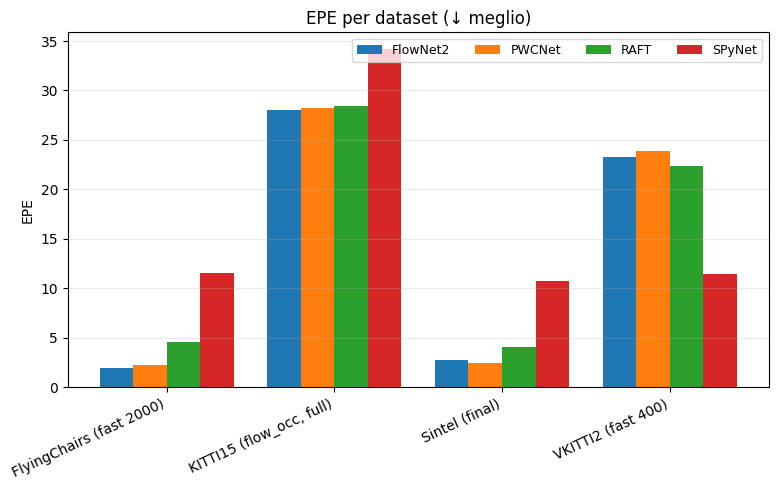

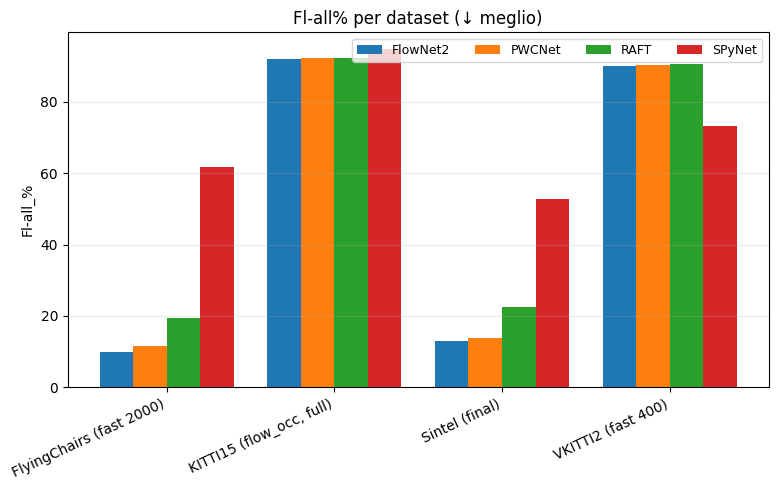

In [103]:
# B) BAR CHART (EPE e Fl-all%) per dataset
import matplotlib.pyplot as plt
import numpy as np

def grouped_bar(df, value_col, title):
    pivot = df.pivot(index='dataset', columns='model', values=value_col).sort_index()
    datasets = pivot.index.tolist()
    models   = pivot.columns.tolist()
    x = np.arange(len(datasets))
    w = 0.8 / max(1, len(models))

    plt.figure(figsize=(max(8, 1.5*len(datasets)), 5))
    for i, m in enumerate(models):
        y = pivot[m].values
        plt.bar(x + i*w - 0.4 + w/2, y, width=w, label=m)
    plt.xticks(x, datasets, rotation=25, ha='right')
    plt.ylabel(value_col)
    plt.title(title)
    plt.legend(ncol=min(len(models), 4), fontsize=9)
    plt.grid(axis='y', alpha=0.25)
    plt.tight_layout()
    plt.show()

grouped_bar(dfp, "EPE",        "EPE per dataset (↓ meglio)")
grouped_bar(dfp, "Fl-all_%",   "Fl-all% per dataset (↓ meglio)")


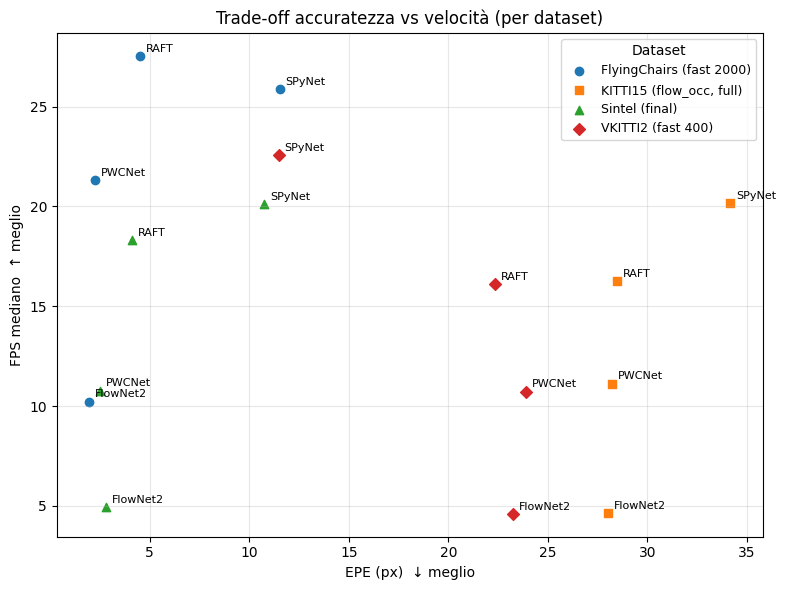

In [104]:
# C) SCATTER EPE vs FPS (↓ EPE, ↑ FPS = meglio in alto a sinistra)
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
datasets = sorted(dfp['dataset'].unique().tolist())
markers  = ['o', 's', '^', 'D', 'v', 'P', 'X', '*']  # ruota se servono

for i, ds in enumerate(datasets):
    sub = dfp[dfp['dataset']==ds]
    plt.scatter(sub['EPE'], sub['FPS_median'], marker=markers[i % len(markers)], label=ds)
    # annotazioni modello su ogni punto
    for _, r in sub.iterrows():
        plt.annotate(r['model'], (r['EPE'], r['FPS_median']), xytext=(4,3),
                     textcoords='offset points', fontsize=8)

plt.xlabel("EPE (px)  ↓ meglio")
plt.ylabel("FPS mediano  ↑ meglio")
plt.title("Trade-off accuratezza vs velocità (per dataset)")
plt.grid(True, alpha=0.3)
plt.legend(title="Dataset", fontsize=9)
plt.tight_layout()
plt.show()


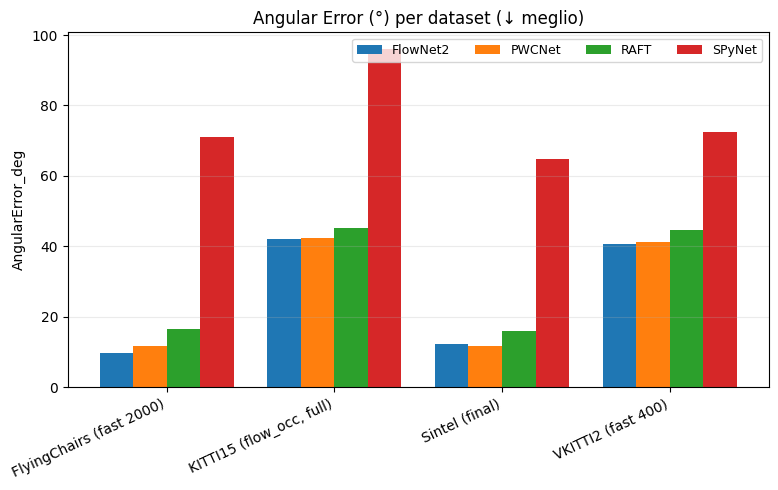

In [105]:
# D) BAR CHART Angular Error (°)
grouped_bar(dfp, "AngularError_deg", "Angular Error (°) per dataset (↓ meglio)")


diversi tipi di lanci per quanto riguarda le metriche

A) Leaderboard (snippet 1)

Scopo: tabellina rapida di confronto fisso tra modelli e dataset noti.

Selezione dataset: manuale tramite JOBS (Sintel-final, KITTI15-occ full, VKITTI2 fast=400, Chairs fast=2000).

Riproducibilità: più “deterministico” perché i job sono elencati a mano.

Output: una tabella ordinata per dataset con metriche, salvata in /content/outputs/leaderboard_2D.csv.

Uso tipico: slide/nota di confronto veloce; mostra “chi vince” su ciascun dataset.

B) Master Eval (snippet 2)

Scopo: pipeline generale per valutare tutto ciò che trova (auto-discovery dei dataset presenti).

Selezione dataset: automatica (cerca Sintel, Chairs subset locale, KITTI15, VKITTI2). Può includere più varianti (es. Sintel-final/clean, KITTI15-occ/noc).

Modalità FAST/full: un toggle (FAST=True/False) applica limiti per ridurre il tempo oppure esegue tutto.

Robustezza: unifica root di KITTI se i pacchetti sono in cartelle diverse (link/copy), quindi “si adatta” all’ambiente.

Output: log completo con timestamp, CSV aggregato (benchmark_all_*.csv) e tabella LaTeX media per dataset/modello (*.tex) pronta per la tesi.

Uso tipico: run “ufficiale”/finale e generazione dei materiali da consegna (CSV + LaTeX).

Cosa non cambia tra i due

Entrambi chiamano la stessa run_batch_eval(...): stesse metriche (EPE, Fl-all%, Angular Error, FPS) e stessa logica di calcolo quando c’è GT.

La differenza è solo nell’orchestrazione (come/quanto lanci i job, cosa esporti, automazione).


Abbiamo due lanci: una Leaderboard compatta e ripetibile, con un set fisso di job per confronto immediato, e una Master Eval che scopre automaticamente i dataset disponibili, gestisce modalità FAST/full, e produce sia CSV sia una tabella LaTeX aggregata per la tesi. Le metriche sono identiche perché usano lo stesso evaluator; cambia solo l’automazione e l’output.”